## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [3]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(np.array(self.df.iloc[index]))
        label = torch.tensor(np.array([self.price.iloc[index]]))
        return {"sample": sample, "label": label}
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=0)

#### Visualize Data Samples

In [4]:
pd.set_option('display.max_columns', None)
train_df.head(5)

host_is_superhost  latitude  longitude  property_type  room_type  \
0                  0 -0.396491   0.215068      -0.444532  -0.686927   
1                  0 -0.841516   0.095963       1.182045  -0.686927   
2                  0 -0.725178  -0.909397      -0.444532   1.329375   
3                  0 -0.048882   0.086232      -0.444532  -0.686927   
4                  0 -0.635052   0.094278      -0.444532  -0.686927   

   accommodates  bathrooms  bedrooms      beds     price  instant_bookable  \
0     -0.597957  -0.436242 -0.353343 -0.650700  0.438466                 0   
1     -0.597957  -0.436242 -0.353343 -0.650700  2.623250                 0   
2     -0.597957  -0.436242 -0.353343 -0.650700 -1.027833                 1   
3     -0.597957  -0.436242 -1.660357 -0.650700  1.171615                 0   
4     -0.030463  -0.436242  0.953672  0.389812  1.010322                 0   

   cancellation_policy  amenities_Kitchen  amenities_Heating  \
0             1.160642                  1                  1   
1            -1.125796                  1                  1   
2            -1.125796                  1                  1   
3            -0.422277                  1                  1   
4             1.160642                  1                  1   

   amenities_Washer  amenities_Wifi  amenities_Indoor fireplace  \
0                 1               1                           0   
1                 1               1                           0   
2                 1               1                           0   
3                 1               1                           0   
4                 1               1                           0   

   amenities_Iron  amenities_Laptop friendly workspace  amenities_Crib  \
0               1                                    1               0   
1               1                                    1               0   
2               0                                    0               0   
3               0                                    0               0   
4               1                                    1               0   

   amenities_Self check-in  amenities_Carbon monoxide detector  \
0                        0                                   0   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   1   

   amenities_Shampoo  amenities_Air conditioning  amenities_Dryer  \
0                  1                           1                1   
1                  1                           1                1   
2                  1                           1                1   
3                  0                           1                1   
4                  0                           1                1   

   amenities_Breakfast  amenities_Hangers  amenities_Hair dryer  amenities_TV  \
0                    1                  0                     1             1   
1                    0                  1                     1             1   
2                    0                  0                     0             1   
3                    0                  1                     0             1   
4                    0                  1                     1             1   

   amenities_High chair  amenities_Smoke detector  amenities_Private bathroom  \
0                     0                         1                           0   
1                     0                         1                           0   
2                     0                         1                           0   
3                     0                         1                           0   
4                     0                         1                           0   

   amenities_count  facilities_Free parking on premises  facilities_Gym  \
0         0.2

#### Import Mean and Std File

In [5]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

mean        std
price                120.097102  68.198942
latitude              43.677492   0.046110
longitude            -79.398326   0.059359
property_type          2.819879   1.844364
room_type              0.340686   0.495957
accommodates           3.053679   1.762132
bathrooms              1.200374   0.459320
bedrooms               1.270343   0.765102
beds                   1.625366   0.961066
cancellation_policy    7.400940   5.685699
amenities_count       12.185917   2.775618
facilities_count       1.065138   1.181071
house_rules_count      0.184610   0.449641

## Define Model

In [6]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 41*2)
        self.layer2 = nn.Linear(41*2, 41*2)
        self.layer3 = nn.Linear(41*2, 41*2)
        self.layer4 = nn.Linear(41*2, 41*1)
        self.layer5 = nn.Linear(41*1, 1)
        
        self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)
        x = torch.relu(self.layer4(x))
        return self.layer5(x)

## Training Function

In [7]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"].float()
            label = data["label"].float()
            output = net(sample)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [8]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [9]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 1.013302  time: 3.540
---[ITER 20] loss: 1.003001  time: 3.643
---[ITER 30] loss: 0.980198  time: 3.943
---[ITER 40] loss: 0.969687  time: 2.885
---[ITER 50] loss: 1.000814  time: 2.668
---[ITER 60] loss: 0.974996  time: 2.653
---[ITER 70] loss: 0.985591  time: 2.664
---[ITER 80] loss: 0.942570  time: 2.712
---[ITER 90] loss: 0.943143  time: 2.651
---[ITER 100] loss: 0.940998  time: 2.752
---[ITER 110] loss: 0.896850  time: 2.664
---[ITER 120] loss: 0.866304  time: 2.599
---[ITER 130] loss: 0.791149  time: 2.621
---[ITER 140] loss: 0.746549  time: 2.726
---[ITER 150] loss: 0.663973  time: 2.689
---[ITER 160] loss: 0.639324  time: 2.665
[EPOCH 1] loss: 0.883278  time: 48.182
---[ITER 10] loss: 0.617954  time: 2.670
---[ITER 20] loss: 0.577295  time: 2.652
---[ITER 30] loss: 0.602465  time: 2.636
---[ITER 40] loss: 0.606759  time: 2.641
---[ITER 50] loss: 0.586429  time: 2.652
---[ITER 60] loss: 0.569169  time: 2.692
---[ITER 70] loss: 0.567281  ti

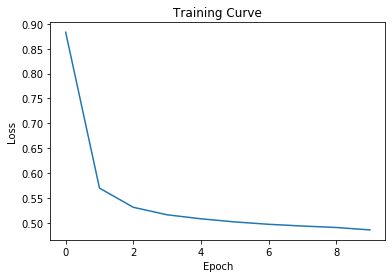

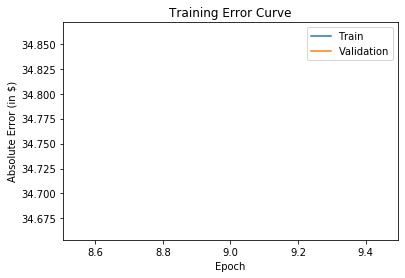

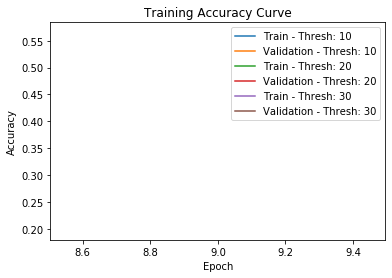

---[ITER 10] loss: 0.482182  time: 2.976
---[ITER 20] loss: 0.491182  time: 3.180
---[ITER 30] loss: 0.495335  time: 2.762
---[ITER 40] loss: 0.483852  time: 2.778
---[ITER 50] loss: 0.493449  time: 2.876
---[ITER 60] loss: 0.470250  time: 2.730
---[ITER 70] loss: 0.479711  time: 3.121
---[ITER 80] loss: 0.498345  time: 2.839
---[ITER 90] loss: 0.482198  time: 2.805
---[ITER 100] loss: 0.497031  time: 2.756
---[ITER 110] loss: 0.476547  time: 2.822
---[ITER 120] loss: 0.473033  time: 2.720
---[ITER 130] loss: 0.471053  time: 2.764
---[ITER 140] loss: 0.477900  time: 2.918
---[ITER 150] loss: 0.473715  time: 2.664
---[ITER 160] loss: 0.480333  time: 2.703
[EPOCH 11] loss: 0.482654  time: 47.646
---[ITER 10] loss: 0.480791  time: 2.740
---[ITER 20] loss: 0.485191  time: 2.709
---[ITER 30] loss: 0.474595  time: 2.669
---[ITER 40] loss: 0.482988  time: 2.770
---[ITER 50] loss: 0.491929  time: 2.640
---[ITER 60] loss: 0.490667  time: 2.609
---[ITER 70] loss: 0.468868  time: 2.599
---[ITER 8

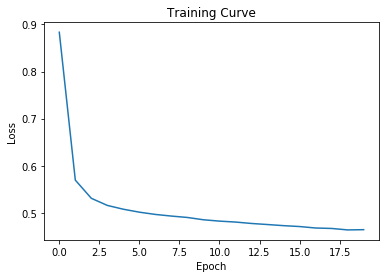

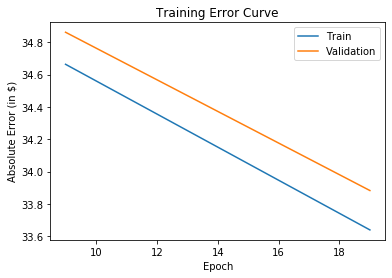

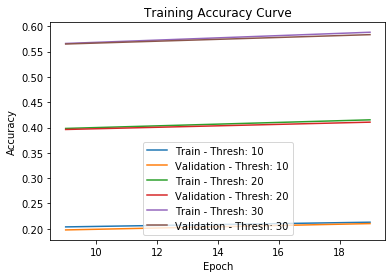

---[ITER 10] loss: 0.467264  time: 2.623
---[ITER 20] loss: 0.454356  time: 2.636
---[ITER 30] loss: 0.471344  time: 2.651
---[ITER 40] loss: 0.451417  time: 2.611
---[ITER 50] loss: 0.443184  time: 2.622
---[ITER 60] loss: 0.458047  time: 2.648
---[ITER 70] loss: 0.458273  time: 2.636
---[ITER 80] loss: 0.482924  time: 2.640
---[ITER 90] loss: 0.451537  time: 2.709
---[ITER 100] loss: 0.469500  time: 2.621
---[ITER 110] loss: 0.468901  time: 2.670
---[ITER 120] loss: 0.465396  time: 2.650
---[ITER 130] loss: 0.448580  time: 2.602
---[ITER 140] loss: 0.471499  time: 2.629
---[ITER 150] loss: 0.457800  time: 2.756
---[ITER 160] loss: 0.453862  time: 2.642
[EPOCH 21] loss: 0.460739  time: 44.366
---[ITER 10] loss: 0.456482  time: 2.591
---[ITER 20] loss: 0.466654  time: 2.647
---[ITER 30] loss: 0.462295  time: 2.637
---[ITER 40] loss: 0.462288  time: 2.604
---[ITER 50] loss: 0.443783  time: 2.608
---[ITER 60] loss: 0.458884  time: 2.631
---[ITER 70] loss: 0.460242  time: 2.658
---[ITER 8

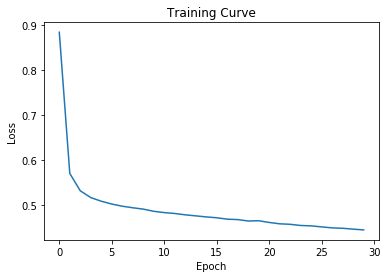

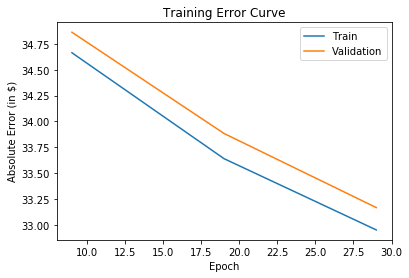

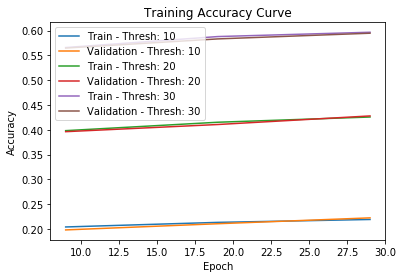

---[ITER 10] loss: 0.435560  time: 2.700
---[ITER 20] loss: 0.459164  time: 2.711
---[ITER 30] loss: 0.430677  time: 2.743
---[ITER 40] loss: 0.442582  time: 2.722
---[ITER 50] loss: 0.441200  time: 2.693
---[ITER 60] loss: 0.441213  time: 2.659
---[ITER 70] loss: 0.436655  time: 2.683
---[ITER 80] loss: 0.449321  time: 2.677
---[ITER 90] loss: 0.445935  time: 2.720
---[ITER 100] loss: 0.430199  time: 2.612
---[ITER 110] loss: 0.437891  time: 2.638
---[ITER 120] loss: 0.440653  time: 2.599
---[ITER 130] loss: 0.459030  time: 2.770
---[ITER 140] loss: 0.425247  time: 2.692
---[ITER 150] loss: 0.451095  time: 2.612
---[ITER 160] loss: 0.449271  time: 2.601
[EPOCH 31] loss: 0.442392  time: 44.867
---[ITER 10] loss: 0.438239  time: 2.689
---[ITER 20] loss: 0.431066  time: 2.676
---[ITER 30] loss: 0.441229  time: 2.615
---[ITER 40] loss: 0.438199  time: 2.648
---[ITER 50] loss: 0.458682  time: 2.635
---[ITER 60] loss: 0.429862  time: 2.630
---[ITER 70] loss: 0.430649  time: 2.595
---[ITER 8

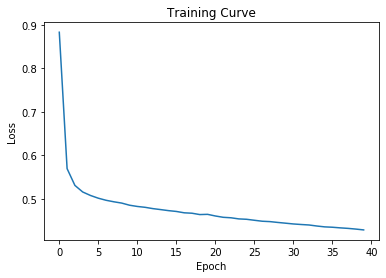

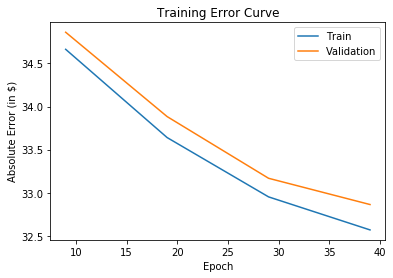

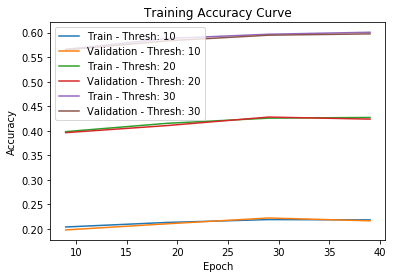

---[ITER 10] loss: 0.440606  time: 2.760
---[ITER 20] loss: 0.423167  time: 2.685
---[ITER 30] loss: 0.433104  time: 2.691
---[ITER 40] loss: 0.403255  time: 2.686
---[ITER 50] loss: 0.428609  time: 2.666
---[ITER 60] loss: 0.424028  time: 2.689
---[ITER 70] loss: 0.417834  time: 2.732
---[ITER 80] loss: 0.427464  time: 2.732
---[ITER 90] loss: 0.429861  time: 2.723
---[ITER 100] loss: 0.417303  time: 2.656
---[ITER 110] loss: 0.438378  time: 2.788
---[ITER 120] loss: 0.419297  time: 2.721
---[ITER 130] loss: 0.439778  time: 2.693
---[ITER 140] loss: 0.439855  time: 2.726
---[ITER 150] loss: 0.430739  time: 2.678
---[ITER 160] loss: 0.429435  time: 2.653
[EPOCH 41] loss: 0.428147  time: 45.304
---[ITER 10] loss: 0.420803  time: 2.583
---[ITER 20] loss: 0.415532  time: 2.575
---[ITER 30] loss: 0.426958  time: 2.597
---[ITER 40] loss: 0.411177  time: 2.562
---[ITER 50] loss: 0.442671  time: 2.627
---[ITER 60] loss: 0.412535  time: 2.613
---[ITER 70] loss: 0.436608  time: 2.641
---[ITER 8

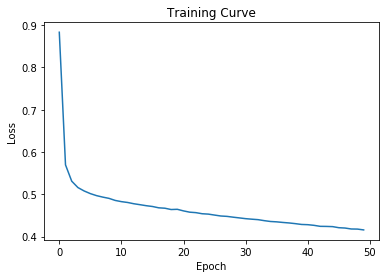

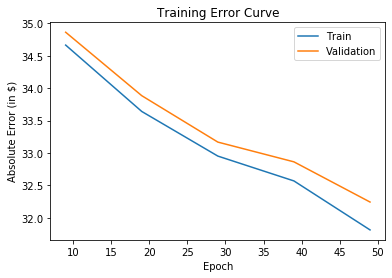

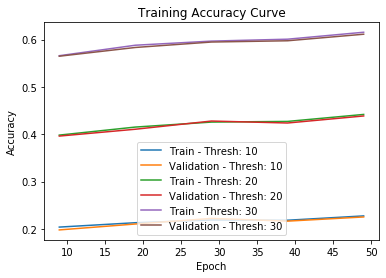

---[ITER 10] loss: 0.402326  time: 2.654
---[ITER 20] loss: 0.413411  time: 2.623
---[ITER 30] loss: 0.399274  time: 2.635
---[ITER 40] loss: 0.429804  time: 2.611
---[ITER 50] loss: 0.418251  time: 2.611
---[ITER 60] loss: 0.414957  time: 2.689
---[ITER 70] loss: 0.423115  time: 2.635
---[ITER 80] loss: 0.413222  time: 2.611
---[ITER 90] loss: 0.434907  time: 2.814
---[ITER 100] loss: 0.417825  time: 2.784
---[ITER 110] loss: 0.415492  time: 2.647
---[ITER 120] loss: 0.411113  time: 2.649
---[ITER 130] loss: 0.404509  time: 2.637
---[ITER 140] loss: 0.417442  time: 2.655
---[ITER 150] loss: 0.423980  time: 2.572
---[ITER 160] loss: 0.407082  time: 2.614
[EPOCH 51] loss: 0.415198  time: 44.443
---[ITER 10] loss: 0.416541  time: 2.606
---[ITER 20] loss: 0.406732  time: 2.621
---[ITER 30] loss: 0.410113  time: 2.573
---[ITER 40] loss: 0.405172  time: 2.586
---[ITER 50] loss: 0.428346  time: 2.584
---[ITER 60] loss: 0.416367  time: 2.599
---[ITER 70] loss: 0.433032  time: 2.618
---[ITER 8

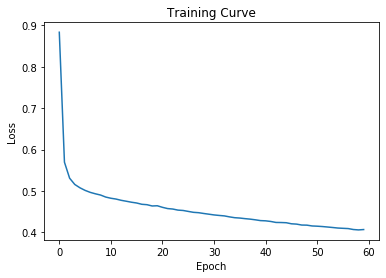

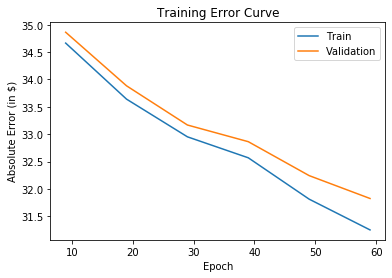

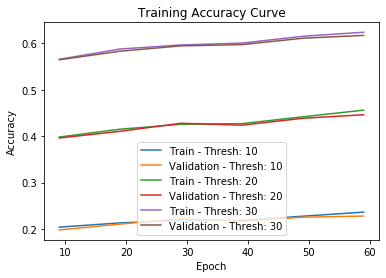

---[ITER 10] loss: 0.395792  time: 2.819
---[ITER 20] loss: 0.401701  time: 2.950
---[ITER 30] loss: 0.390529  time: 2.901
---[ITER 40] loss: 0.399874  time: 2.837
---[ITER 50] loss: 0.410774  time: 2.913
---[ITER 60] loss: 0.395989  time: 2.798
---[ITER 70] loss: 0.404366  time: 2.765
---[ITER 80] loss: 0.402587  time: 2.833
---[ITER 90] loss: 0.402846  time: 2.868
---[ITER 100] loss: 0.401728  time: 2.836
---[ITER 110] loss: 0.410902  time: 2.998
---[ITER 120] loss: 0.411690  time: 2.926
---[ITER 130] loss: 0.405558  time: 2.926
---[ITER 140] loss: 0.410042  time: 2.902
---[ITER 150] loss: 0.407120  time: 2.749
---[ITER 160] loss: 0.401544  time: 2.767
[EPOCH 61] loss: 0.403748  time: 47.904
---[ITER 10] loss: 0.396550  time: 2.791
---[ITER 20] loss: 0.395011  time: 2.942
---[ITER 30] loss: 0.407477  time: 2.818
---[ITER 40] loss: 0.404449  time: 2.780
---[ITER 50] loss: 0.392721  time: 2.834
---[ITER 60] loss: 0.394414  time: 2.828
---[ITER 70] loss: 0.408542  time: 2.963
---[ITER 8

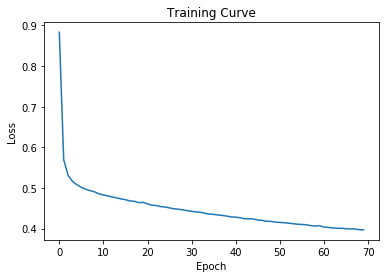

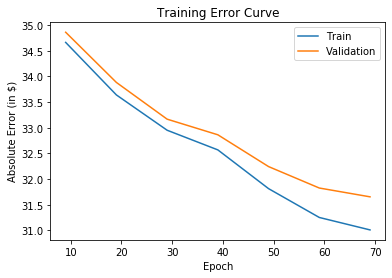

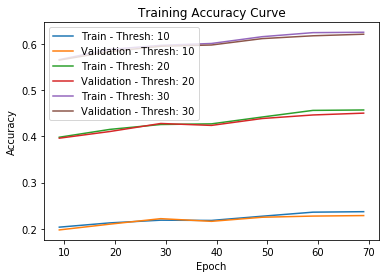

---[ITER 10] loss: 0.385235  time: 2.635
---[ITER 20] loss: 0.388218  time: 2.567
---[ITER 30] loss: 0.407982  time: 2.574
---[ITER 40] loss: 0.385731  time: 2.556
---[ITER 50] loss: 0.378608  time: 2.563
---[ITER 60] loss: 0.393706  time: 2.570
---[ITER 70] loss: 0.415029  time: 2.573
---[ITER 80] loss: 0.396608  time: 2.606
---[ITER 90] loss: 0.410553  time: 2.552
---[ITER 100] loss: 0.388152  time: 2.566
---[ITER 110] loss: 0.389750  time: 2.580
---[ITER 120] loss: 0.404156  time: 2.589
---[ITER 130] loss: 0.407221  time: 2.655
---[ITER 140] loss: 0.403829  time: 2.720
---[ITER 150] loss: 0.398726  time: 2.603
---[ITER 160] loss: 0.383879  time: 2.622
[EPOCH 71] loss: 0.396026  time: 43.618
---[ITER 10] loss: 0.387008  time: 2.603
---[ITER 20] loss: 0.385043  time: 2.562
---[ITER 30] loss: 0.403865  time: 2.566
---[ITER 40] loss: 0.388881  time: 2.612
---[ITER 50] loss: 0.396045  time: 2.621
---[ITER 60] loss: 0.408304  time: 2.600
---[ITER 70] loss: 0.382599  time: 2.628
---[ITER 8

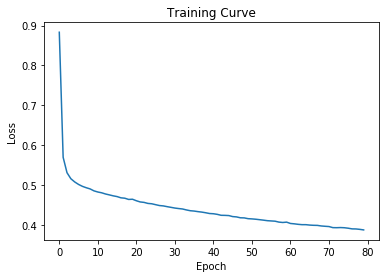

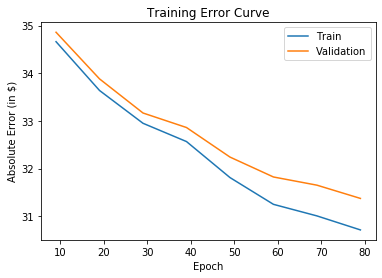

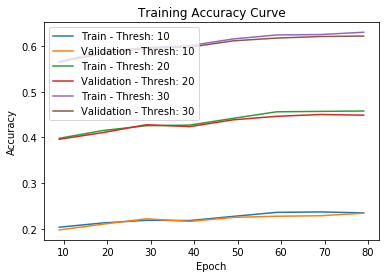

---[ITER 10] loss: 0.379304  time: 2.727
---[ITER 20] loss: 0.381341  time: 2.631
---[ITER 30] loss: 0.404269  time: 2.625
---[ITER 40] loss: 0.381069  time: 2.608
---[ITER 50] loss: 0.393254  time: 2.568
---[ITER 60] loss: 0.383939  time: 2.594
---[ITER 70] loss: 0.392532  time: 2.627
---[ITER 80] loss: 0.394919  time: 2.602
---[ITER 90] loss: 0.394552  time: 2.578
---[ITER 100] loss: 0.390089  time: 2.617
---[ITER 110] loss: 0.391159  time: 2.638
---[ITER 120] loss: 0.377437  time: 2.616
---[ITER 130] loss: 0.392185  time: 2.770
---[ITER 140] loss: 0.383914  time: 2.748
---[ITER 150] loss: 0.395811  time: 2.671
---[ITER 160] loss: 0.385917  time: 2.584
[EPOCH 81] loss: 0.388292  time: 44.360
---[ITER 10] loss: 0.391109  time: 2.702
---[ITER 20] loss: 0.389966  time: 2.787
---[ITER 30] loss: 0.367198  time: 2.677
---[ITER 40] loss: 0.398380  time: 2.611
---[ITER 50] loss: 0.383677  time: 2.603
---[ITER 60] loss: 0.371840  time: 2.600
---[ITER 70] loss: 0.387399  time: 2.617
---[ITER 8

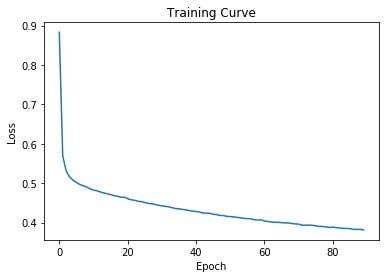

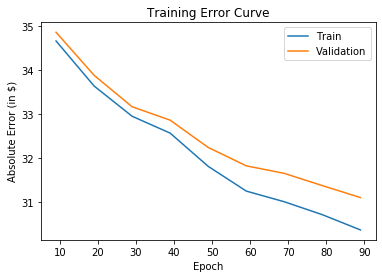

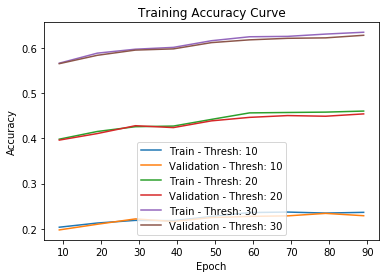

---[ITER 10] loss: 0.375476  time: 2.942
---[ITER 20] loss: 0.379900  time: 2.895
---[ITER 30] loss: 0.372654  time: 2.978
---[ITER 40] loss: 0.383077  time: 2.893
---[ITER 50] loss: 0.397586  time: 2.828
---[ITER 60] loss: 0.374023  time: 2.837
---[ITER 70] loss: 0.376709  time: 2.975
---[ITER 80] loss: 0.376967  time: 2.867
---[ITER 90] loss: 0.376640  time: 2.858
---[ITER 100] loss: 0.378538  time: 2.727
---[ITER 110] loss: 0.381459  time: 2.762
---[ITER 120] loss: 0.372201  time: 2.763
---[ITER 130] loss: 0.368365  time: 2.911
---[ITER 140] loss: 0.388198  time: 2.837
---[ITER 150] loss: 0.373912  time: 2.769
---[ITER 160] loss: 0.393383  time: 2.800
[EPOCH 91] loss: 0.380134  time: 47.838
---[ITER 10] loss: 0.360151  time: 3.035
---[ITER 20] loss: 0.386099  time: 2.826
---[ITER 30] loss: 0.390864  time: 2.845
---[ITER 40] loss: 0.378553  time: 2.999
---[ITER 50] loss: 0.375395  time: 2.961
---[ITER 60] loss: 0.363417  time: 2.908
---[ITER 70] loss: 0.383885  time: 2.730
---[ITER 8

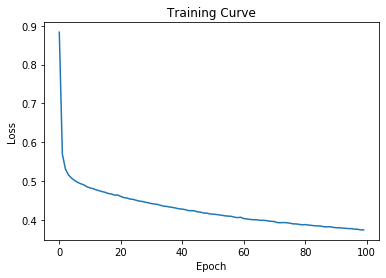

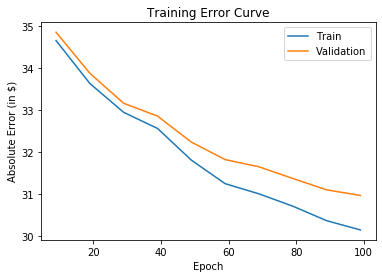

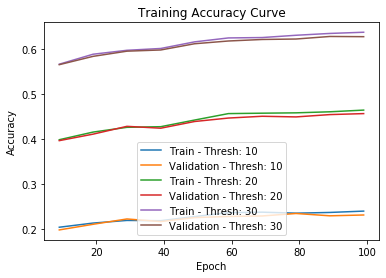

---[ITER 10] loss: 0.368675  time: 2.802
---[ITER 20] loss: 0.375995  time: 2.679
---[ITER 30] loss: 0.386553  time: 2.684
---[ITER 40] loss: 0.371111  time: 2.722
---[ITER 50] loss: 0.376598  time: 2.672
---[ITER 60] loss: 0.378772  time: 2.886
---[ITER 70] loss: 0.374404  time: 2.893
---[ITER 80] loss: 0.364285  time: 2.698
---[ITER 90] loss: 0.378154  time: 2.633
---[ITER 100] loss: 0.363508  time: 2.737
---[ITER 110] loss: 0.375286  time: 2.729
---[ITER 120] loss: 0.385417  time: 2.657
---[ITER 130] loss: 0.370589  time: 2.572
---[ITER 140] loss: 0.369463  time: 2.624
---[ITER 150] loss: 0.366741  time: 2.754
---[ITER 160] loss: 0.384720  time: 2.842
[EPOCH 101] loss: 0.374853  time: 45.711
---[ITER 10] loss: 0.360287  time: 2.760
---[ITER 20] loss: 0.373723  time: 2.715
---[ITER 30] loss: 0.375329  time: 2.710
---[ITER 40] loss: 0.384822  time: 2.629
---[ITER 50] loss: 0.381926  time: 2.789
---[ITER 60] loss: 0.376357  time: 2.874
---[ITER 70] loss: 0.381761  time: 2.639
---[ITER 

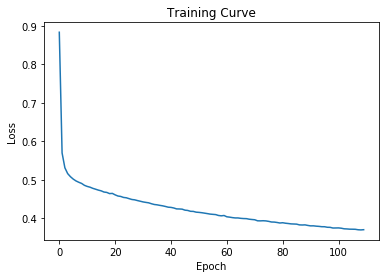

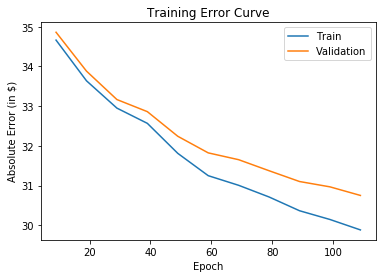

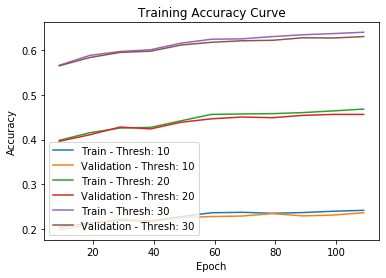

---[ITER 10] loss: 0.364560  time: 2.772
---[ITER 20] loss: 0.381457  time: 2.856
---[ITER 30] loss: 0.376712  time: 2.820
---[ITER 40] loss: 0.362792  time: 2.684
---[ITER 50] loss: 0.367091  time: 2.678
---[ITER 60] loss: 0.368222  time: 2.716
---[ITER 70] loss: 0.365529  time: 2.687
---[ITER 80] loss: 0.365573  time: 2.660
---[ITER 90] loss: 0.379950  time: 2.710
---[ITER 100] loss: 0.386357  time: 2.678
---[ITER 110] loss: 0.371454  time: 2.690
---[ITER 120] loss: 0.361496  time: 2.660
---[ITER 130] loss: 0.357201  time: 2.687
---[ITER 140] loss: 0.360931  time: 2.709
---[ITER 150] loss: 0.357185  time: 2.643
---[ITER 160] loss: 0.363091  time: 2.751
[EPOCH 111] loss: 0.367826  time: 45.524
---[ITER 10] loss: 0.364624  time: 2.759
---[ITER 20] loss: 0.372997  time: 2.681
---[ITER 30] loss: 0.362626  time: 2.627
---[ITER 40] loss: 0.371694  time: 2.659
---[ITER 50] loss: 0.372023  time: 2.660
---[ITER 60] loss: 0.364852  time: 2.676
---[ITER 70] loss: 0.371313  time: 2.591
---[ITER 

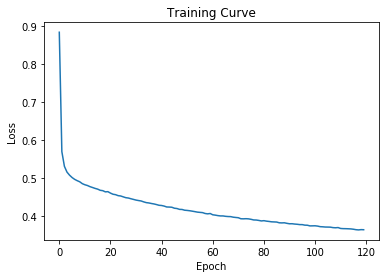

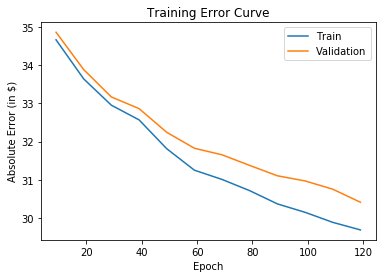

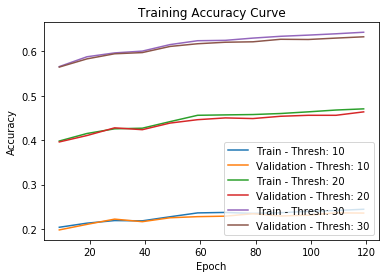

---[ITER 10] loss: 0.371021  time: 2.953
---[ITER 20] loss: 0.375366  time: 2.902
---[ITER 30] loss: 0.367560  time: 2.947
---[ITER 40] loss: 0.360659  time: 2.826
---[ITER 50] loss: 0.368501  time: 2.875
---[ITER 60] loss: 0.373899  time: 2.950
---[ITER 70] loss: 0.361682  time: 2.899
---[ITER 80] loss: 0.364202  time: 2.950
---[ITER 90] loss: 0.361137  time: 2.953
---[ITER 100] loss: 0.356735  time: 2.890
---[ITER 110] loss: 0.359788  time: 3.007
---[ITER 120] loss: 0.369645  time: 2.930
---[ITER 130] loss: 0.357824  time: 2.871
---[ITER 140] loss: 0.361593  time: 2.917
---[ITER 150] loss: 0.360490  time: 2.899
---[ITER 160] loss: 0.354792  time: 2.864
[EPOCH 121] loss: 0.363849  time: 48.865
---[ITER 10] loss: 0.379166  time: 2.937
---[ITER 20] loss: 0.356519  time: 2.954
---[ITER 30] loss: 0.360456  time: 2.916
---[ITER 40] loss: 0.351951  time: 2.931
---[ITER 50] loss: 0.368708  time: 2.822
---[ITER 60] loss: 0.364911  time: 2.620
---[ITER 70] loss: 0.370342  time: 2.636
---[ITER 

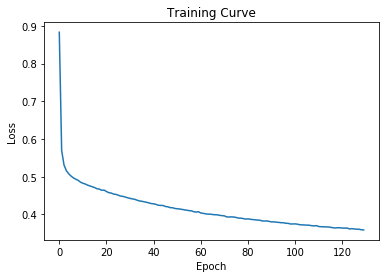

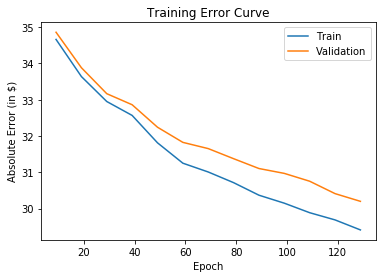

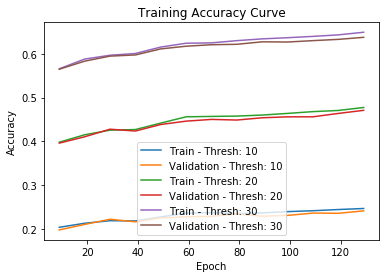

---[ITER 10] loss: 0.366757  time: 2.938
---[ITER 20] loss: 0.363331  time: 2.982
---[ITER 30] loss: 0.356515  time: 2.926
---[ITER 40] loss: 0.357551  time: 2.846
---[ITER 50] loss: 0.366266  time: 2.855
---[ITER 60] loss: 0.354583  time: 2.924
---[ITER 70] loss: 0.343263  time: 2.999
---[ITER 80] loss: 0.358542  time: 2.862
---[ITER 90] loss: 0.353092  time: 2.986
---[ITER 100] loss: 0.354848  time: 2.908
---[ITER 110] loss: 0.365465  time: 2.875
---[ITER 120] loss: 0.356505  time: 2.882
---[ITER 130] loss: 0.364276  time: 2.852
---[ITER 140] loss: 0.355743  time: 2.982
---[ITER 150] loss: 0.340394  time: 2.855
---[ITER 160] loss: 0.378760  time: 2.946
[EPOCH 131] loss: 0.358760  time: 48.930
---[ITER 10] loss: 0.360837  time: 3.006
---[ITER 20] loss: 0.355437  time: 2.903
---[ITER 30] loss: 0.362818  time: 2.988
---[ITER 40] loss: 0.354285  time: 3.093
---[ITER 50] loss: 0.349131  time: 3.121
---[ITER 60] loss: 0.358463  time: 2.993
---[ITER 70] loss: 0.365732  time: 2.884
---[ITER 

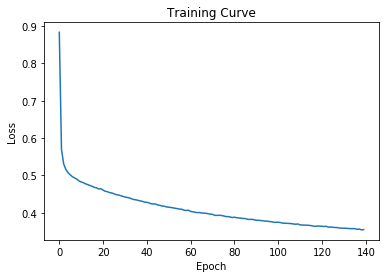

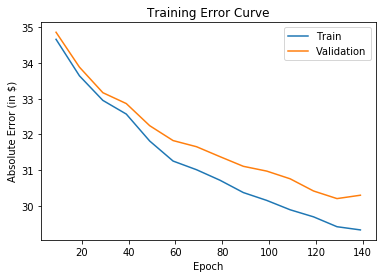

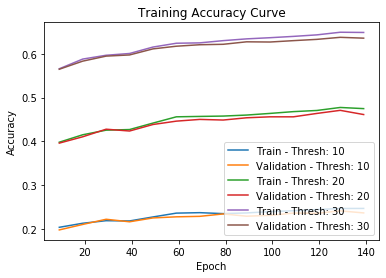

---[ITER 10] loss: 0.358638  time: 2.792
---[ITER 20] loss: 0.349311  time: 2.675
---[ITER 30] loss: 0.358041  time: 2.594
---[ITER 40] loss: 0.350399  time: 2.617
---[ITER 50] loss: 0.340209  time: 2.563
---[ITER 60] loss: 0.361047  time: 2.589
---[ITER 70] loss: 0.363747  time: 2.573
---[ITER 80] loss: 0.357470  time: 2.654
---[ITER 90] loss: 0.359861  time: 2.588
---[ITER 100] loss: 0.346766  time: 2.791
---[ITER 110] loss: 0.355814  time: 2.636
---[ITER 120] loss: 0.362722  time: 2.628
---[ITER 130] loss: 0.361656  time: 2.601
---[ITER 140] loss: 0.374913  time: 2.584
---[ITER 150] loss: 0.351842  time: 2.759
---[ITER 160] loss: 0.345856  time: 2.820
[EPOCH 141] loss: 0.355835  time: 44.452
---[ITER 10] loss: 0.341164  time: 2.560
---[ITER 20] loss: 0.345412  time: 2.544
---[ITER 30] loss: 0.363169  time: 2.579
---[ITER 40] loss: 0.353993  time: 2.563
---[ITER 50] loss: 0.354251  time: 2.581
---[ITER 60] loss: 0.349473  time: 2.547
---[ITER 70] loss: 0.357930  time: 2.551
---[ITER 

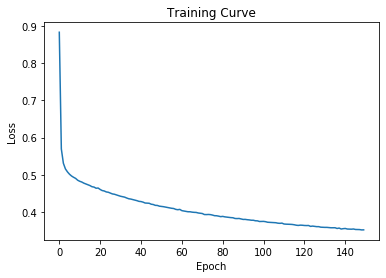

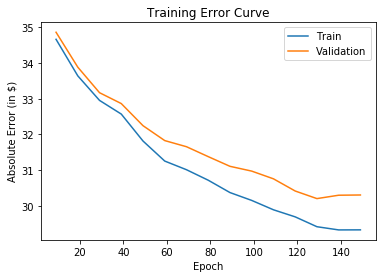

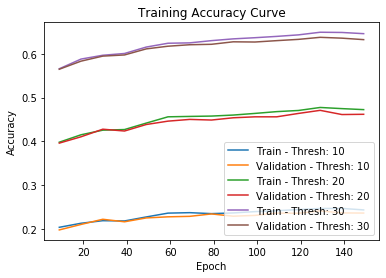

---[ITER 10] loss: 0.348023  time: 2.604
---[ITER 20] loss: 0.347804  time: 2.553
---[ITER 30] loss: 0.347713  time: 2.596
---[ITER 40] loss: 0.355206  time: 2.534
---[ITER 50] loss: 0.354341  time: 2.585
---[ITER 60] loss: 0.337541  time: 2.560
---[ITER 70] loss: 0.344517  time: 2.537
---[ITER 80] loss: 0.346799  time: 2.605
---[ITER 90] loss: 0.349325  time: 2.565
---[ITER 100] loss: 0.364384  time: 2.636
---[ITER 110] loss: 0.356407  time: 2.580
---[ITER 120] loss: 0.353984  time: 2.576
---[ITER 130] loss: 0.346658  time: 2.562
---[ITER 140] loss: 0.360360  time: 2.697
---[ITER 150] loss: 0.360861  time: 2.558
---[ITER 160] loss: 0.333275  time: 2.562
[EPOCH 151] loss: 0.350217  time: 43.315
---[ITER 10] loss: 0.354503  time: 2.602
---[ITER 20] loss: 0.350158  time: 2.574
---[ITER 30] loss: 0.362216  time: 2.569
---[ITER 40] loss: 0.353926  time: 2.558
---[ITER 50] loss: 0.346208  time: 2.554
---[ITER 60] loss: 0.355392  time: 2.555
---[ITER 70] loss: 0.342147  time: 2.555
---[ITER 

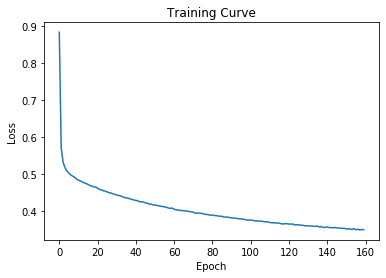

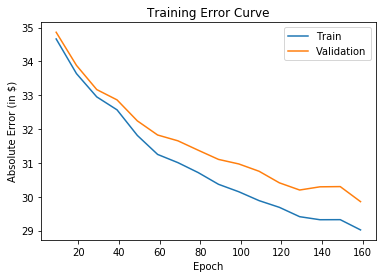

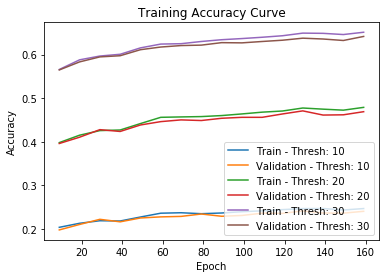

---[ITER 10] loss: 0.368567  time: 2.574
---[ITER 20] loss: 0.369559  time: 2.593
---[ITER 30] loss: 0.345038  time: 2.588
---[ITER 40] loss: 0.331933  time: 2.548
---[ITER 50] loss: 0.334850  time: 4.000
---[ITER 60] loss: 0.343403  time: 2.962
---[ITER 70] loss: 0.341320  time: 2.580
---[ITER 80] loss: 0.355036  time: 2.553
---[ITER 90] loss: 0.337825  time: 2.689
---[ITER 100] loss: 0.345567  time: 2.546
---[ITER 110] loss: 0.363205  time: 2.592
---[ITER 120] loss: 0.341755  time: 2.597
---[ITER 130] loss: 0.349120  time: 2.627
---[ITER 140] loss: 0.347016  time: 2.621
---[ITER 150] loss: 0.352755  time: 2.596
---[ITER 160] loss: 0.344761  time: 2.639
[EPOCH 161] loss: 0.348177  time: 45.305
---[ITER 10] loss: 0.345457  time: 2.588
---[ITER 20] loss: 0.347871  time: 2.629
---[ITER 30] loss: 0.341061  time: 2.636
---[ITER 40] loss: 0.339903  time: 2.566
---[ITER 50] loss: 0.346361  time: 2.578
---[ITER 60] loss: 0.347419  time: 2.586
---[ITER 70] loss: 0.365579  time: 2.554
---[ITER 

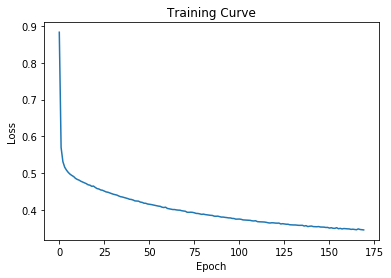

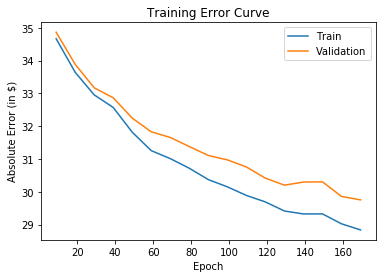

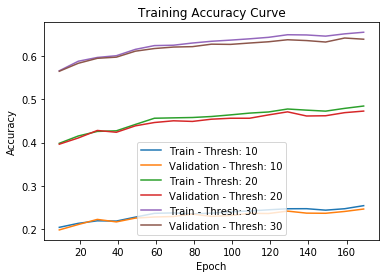

---[ITER 10] loss: 0.345285  time: 2.580
---[ITER 20] loss: 0.347343  time: 2.619
---[ITER 30] loss: 0.345962  time: 2.601
---[ITER 40] loss: 0.358526  time: 2.559
---[ITER 50] loss: 0.340142  time: 2.546
---[ITER 60] loss: 0.330664  time: 2.596
---[ITER 70] loss: 0.352388  time: 2.540
---[ITER 80] loss: 0.324770  time: 2.573
---[ITER 90] loss: 0.333485  time: 2.551
---[ITER 100] loss: 0.352457  time: 2.545
---[ITER 110] loss: 0.357532  time: 2.593
---[ITER 120] loss: 0.346650  time: 2.636
---[ITER 130] loss: 0.341186  time: 2.571
---[ITER 140] loss: 0.342811  time: 2.560
---[ITER 150] loss: 0.349274  time: 2.648
---[ITER 160] loss: 0.353412  time: 2.650
[EPOCH 171] loss: 0.345007  time: 43.369
---[ITER 10] loss: 0.344120  time: 2.631
---[ITER 20] loss: 0.344421  time: 2.786
---[ITER 30] loss: 0.353281  time: 2.643
---[ITER 40] loss: 0.326811  time: 2.608
---[ITER 50] loss: 0.341303  time: 2.597
---[ITER 60] loss: 0.336849  time: 2.637
---[ITER 70] loss: 0.349399  time: 2.620
---[ITER 

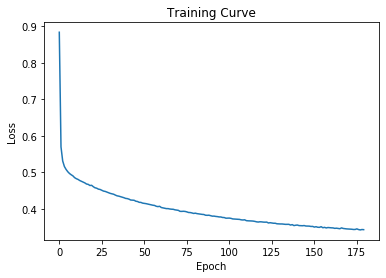

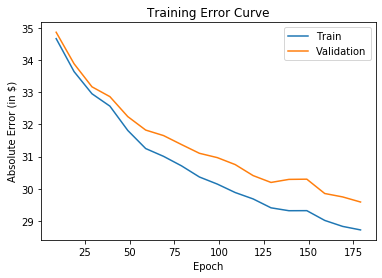

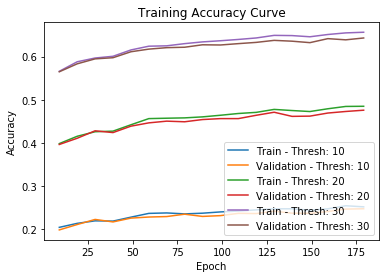

---[ITER 10] loss: 0.338644  time: 2.624
---[ITER 20] loss: 0.345580  time: 2.592
---[ITER 30] loss: 0.352940  time: 2.595
---[ITER 40] loss: 0.346439  time: 2.562
---[ITER 50] loss: 0.339447  time: 2.540
---[ITER 60] loss: 0.341952  time: 2.565
---[ITER 70] loss: 0.343256  time: 2.576
---[ITER 80] loss: 0.344037  time: 2.535
---[ITER 90] loss: 0.343781  time: 2.531
---[ITER 100] loss: 0.346681  time: 2.530
---[ITER 110] loss: 0.335494  time: 2.584
---[ITER 120] loss: 0.333947  time: 2.516
---[ITER 130] loss: 0.345876  time: 2.541
---[ITER 140] loss: 0.339346  time: 2.557
---[ITER 150] loss: 0.341940  time: 2.609
---[ITER 160] loss: 0.339767  time: 2.561
[EPOCH 181] loss: 0.342017  time: 43.124
---[ITER 10] loss: 0.343143  time: 2.620
---[ITER 20] loss: 0.334434  time: 2.576
---[ITER 30] loss: 0.330731  time: 2.577
---[ITER 40] loss: 0.338729  time: 2.725
---[ITER 50] loss: 0.343204  time: 2.567
---[ITER 60] loss: 0.341592  time: 2.521
---[ITER 70] loss: 0.346461  time: 2.522
---[ITER 

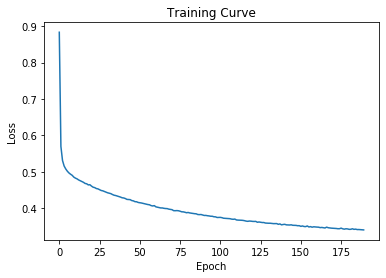

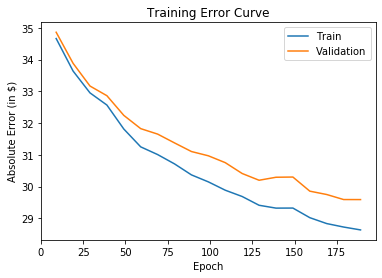

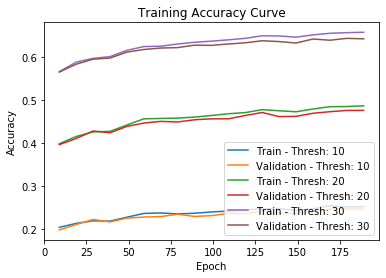

---[ITER 10] loss: 0.343611  time: 2.545
---[ITER 20] loss: 0.328249  time: 2.674
---[ITER 30] loss: 0.343040  time: 2.611
---[ITER 40] loss: 0.333179  time: 2.545
---[ITER 50] loss: 0.337998  time: 2.556
---[ITER 60] loss: 0.336822  time: 2.525
---[ITER 70] loss: 0.343594  time: 2.602
---[ITER 80] loss: 0.338667  time: 2.527
---[ITER 90] loss: 0.332080  time: 2.540
---[ITER 100] loss: 0.350058  time: 2.528
---[ITER 110] loss: 0.357546  time: 2.534
---[ITER 120] loss: 0.352751  time: 2.523
---[ITER 130] loss: 0.322252  time: 2.543
---[ITER 140] loss: 0.348795  time: 2.589
---[ITER 150] loss: 0.343314  time: 2.523
---[ITER 160] loss: 0.341578  time: 2.559
[EPOCH 191] loss: 0.340765  time: 42.914
---[ITER 10] loss: 0.325936  time: 2.540
---[ITER 20] loss: 0.336812  time: 2.598
---[ITER 30] loss: 0.335580  time: 2.523
---[ITER 40] loss: 0.341456  time: 2.569
---[ITER 50] loss: 0.347116  time: 2.558
---[ITER 60] loss: 0.340846  time: 2.637
---[ITER 70] loss: 0.337034  time: 2.571
---[ITER 

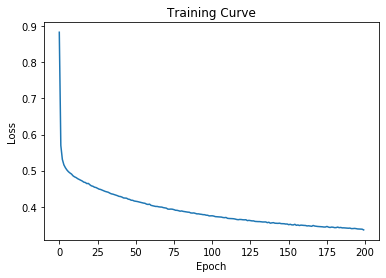

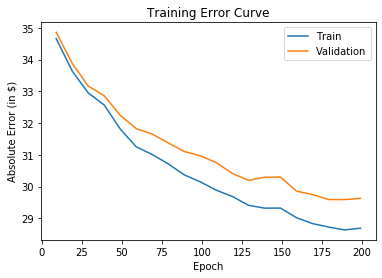

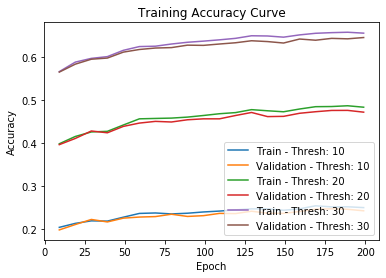

---[ITER 10] loss: 0.336260  time: 2.631
---[ITER 20] loss: 0.334254  time: 2.607
---[ITER 30] loss: 0.332821  time: 2.604
---[ITER 40] loss: 0.334056  time: 2.845
---[ITER 50] loss: 0.342797  time: 2.622
---[ITER 60] loss: 0.334463  time: 2.601
---[ITER 70] loss: 0.337414  time: 3.214
---[ITER 80] loss: 0.326730  time: 2.783
---[ITER 90] loss: 0.336238  time: 2.662
---[ITER 100] loss: 0.340617  time: 2.607
---[ITER 110] loss: 0.343508  time: 2.582
---[ITER 120] loss: 0.332510  time: 2.620
---[ITER 130] loss: 0.346713  time: 2.759
---[ITER 140] loss: 0.342866  time: 2.680
---[ITER 150] loss: 0.332199  time: 2.679
---[ITER 160] loss: 0.339164  time: 2.656
[EPOCH 201] loss: 0.337315  time: 45.331
---[ITER 10] loss: 0.344408  time: 2.783
---[ITER 20] loss: 0.331192  time: 2.779
---[ITER 30] loss: 0.328096  time: 2.737
---[ITER 40] loss: 0.334713  time: 2.656
---[ITER 50] loss: 0.342793  time: 2.886
---[ITER 60] loss: 0.329420  time: 2.882
---[ITER 70] loss: 0.326966  time: 2.847
---[ITER 

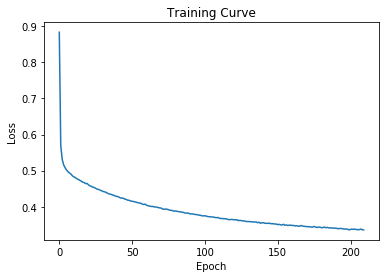

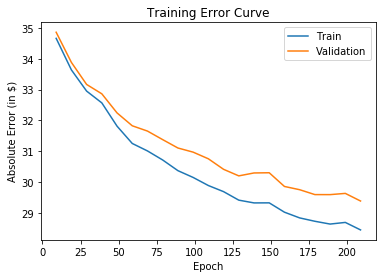

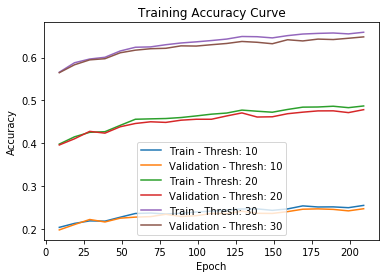

---[ITER 10] loss: 0.344185  time: 2.582
---[ITER 20] loss: 0.345959  time: 2.604
---[ITER 30] loss: 0.335954  time: 2.606
---[ITER 40] loss: 0.331749  time: 2.608
---[ITER 50] loss: 0.335814  time: 2.600
---[ITER 60] loss: 0.328678  time: 2.552
---[ITER 70] loss: 0.343441  time: 2.539
---[ITER 80] loss: 0.326533  time: 2.700
---[ITER 90] loss: 0.337513  time: 2.519
---[ITER 100] loss: 0.331830  time: 2.549
---[ITER 110] loss: 0.330330  time: 2.527
---[ITER 120] loss: 0.336569  time: 2.539
---[ITER 130] loss: 0.333064  time: 2.528
---[ITER 140] loss: 0.340691  time: 2.576
---[ITER 150] loss: 0.347465  time: 2.553
---[ITER 160] loss: 0.323240  time: 2.539
[EPOCH 211] loss: 0.335609  time: 43.094
---[ITER 10] loss: 0.335207  time: 2.552
---[ITER 20] loss: 0.342076  time: 2.594
---[ITER 30] loss: 0.342976  time: 2.561
---[ITER 40] loss: 0.341822  time: 2.555
---[ITER 50] loss: 0.325858  time: 2.577
---[ITER 60] loss: 0.333518  time: 2.551
---[ITER 70] loss: 0.338343  time: 2.576
---[ITER 

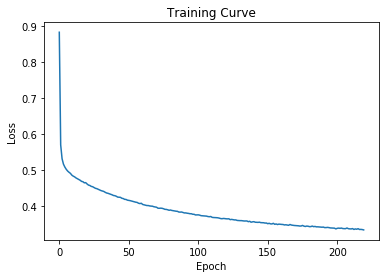

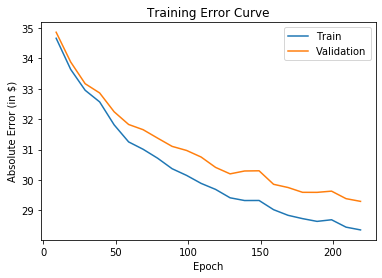

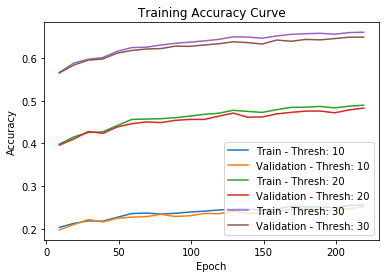

---[ITER 10] loss: 0.330092  time: 2.571
---[ITER 20] loss: 0.335324  time: 2.684
---[ITER 30] loss: 0.324841  time: 2.714
---[ITER 40] loss: 0.324558  time: 2.607
---[ITER 50] loss: 0.345556  time: 2.591
---[ITER 60] loss: 0.331678  time: 2.516
---[ITER 70] loss: 0.327881  time: 2.553
---[ITER 80] loss: 0.330311  time: 2.571
---[ITER 90] loss: 0.336307  time: 2.669
---[ITER 100] loss: 0.333345  time: 2.612
---[ITER 110] loss: 0.330639  time: 2.544
---[ITER 120] loss: 0.349282  time: 2.612
---[ITER 130] loss: 0.335409  time: 2.636
---[ITER 140] loss: 0.335825  time: 2.623
---[ITER 150] loss: 0.338498  time: 2.509
---[ITER 160] loss: 0.337845  time: 2.550
[EPOCH 221] loss: 0.334723  time: 43.517
---[ITER 10] loss: 0.343870  time: 2.527
---[ITER 20] loss: 0.325707  time: 2.621
---[ITER 30] loss: 0.326995  time: 2.534
---[ITER 40] loss: 0.339235  time: 2.567
---[ITER 50] loss: 0.329263  time: 2.530
---[ITER 60] loss: 0.332905  time: 2.524
---[ITER 70] loss: 0.331911  time: 2.590
---[ITER 

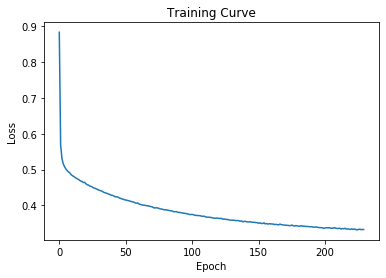

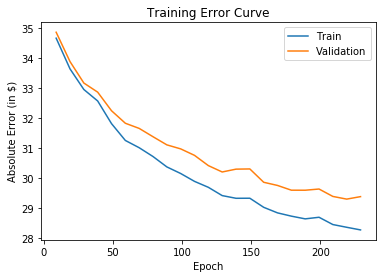

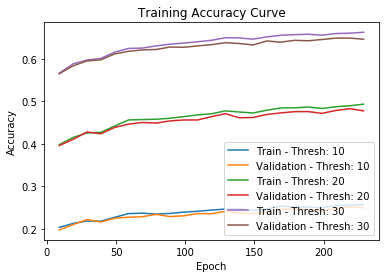

---[ITER 10] loss: 0.338243  time: 2.887
---[ITER 20] loss: 0.319698  time: 2.671
---[ITER 30] loss: 0.332463  time: 2.928
---[ITER 40] loss: 0.339629  time: 2.615
---[ITER 50] loss: 0.333085  time: 2.804
---[ITER 60] loss: 0.335915  time: 2.628
---[ITER 70] loss: 0.345424  time: 2.785
---[ITER 80] loss: 0.332321  time: 2.765
---[ITER 90] loss: 0.334316  time: 2.623
---[ITER 100] loss: 0.332514  time: 2.839
---[ITER 110] loss: 0.334330  time: 2.998
---[ITER 120] loss: 0.323047  time: 2.667
---[ITER 130] loss: 0.329807  time: 2.650
---[ITER 140] loss: 0.329009  time: 2.656
---[ITER 150] loss: 0.326295  time: 2.797
---[ITER 160] loss: 0.324971  time: 2.777
[EPOCH 231] loss: 0.331573  time: 46.305
---[ITER 10] loss: 0.338218  time: 2.687
---[ITER 20] loss: 0.338093  time: 2.625
---[ITER 30] loss: 0.332883  time: 2.628
---[ITER 40] loss: 0.338934  time: 2.543
---[ITER 50] loss: 0.321351  time: 2.568
---[ITER 60] loss: 0.325660  time: 2.542
---[ITER 70] loss: 0.342746  time: 2.579
---[ITER 

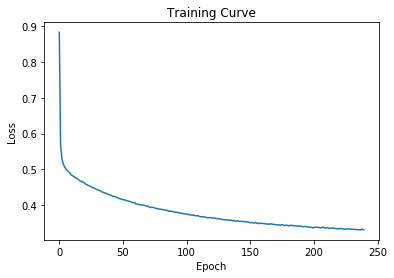

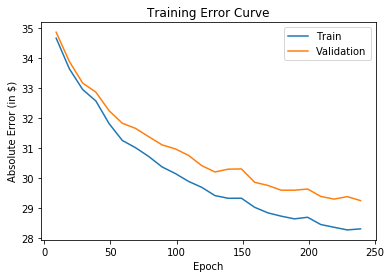

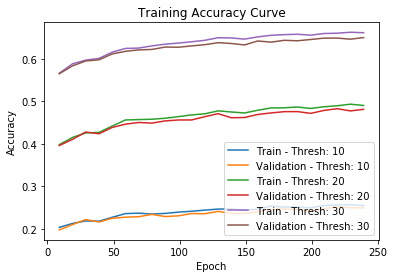

---[ITER 10] loss: 0.331973  time: 2.618
---[ITER 20] loss: 0.338486  time: 2.575
---[ITER 30] loss: 0.323336  time: 2.738
---[ITER 40] loss: 0.321500  time: 2.615
---[ITER 50] loss: 0.322216  time: 2.576
---[ITER 60] loss: 0.333563  time: 2.594
---[ITER 70] loss: 0.334523  time: 2.543
---[ITER 80] loss: 0.334328  time: 2.528
---[ITER 90] loss: 0.325025  time: 2.575
---[ITER 100] loss: 0.319189  time: 2.560
---[ITER 110] loss: 0.334842  time: 2.549
---[ITER 120] loss: 0.324377  time: 2.560
---[ITER 130] loss: 0.330183  time: 2.562
---[ITER 140] loss: 0.338951  time: 2.609
---[ITER 150] loss: 0.323856  time: 2.589
---[ITER 160] loss: 0.335481  time: 2.571
[EPOCH 241] loss: 0.330515  time: 43.344
---[ITER 10] loss: 0.343262  time: 2.739
---[ITER 20] loss: 0.339113  time: 2.573
---[ITER 30] loss: 0.332289  time: 2.533
---[ITER 40] loss: 0.342943  time: 2.562
---[ITER 50] loss: 0.320005  time: 2.525
---[ITER 60] loss: 0.333826  time: 2.548
---[ITER 70] loss: 0.321900  time: 2.541
---[ITER 

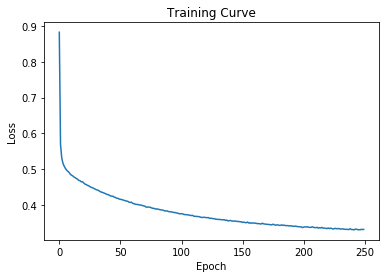

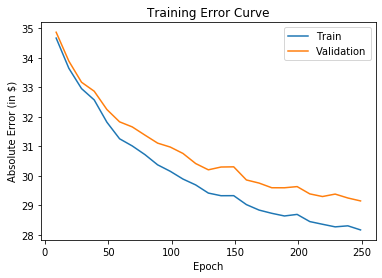

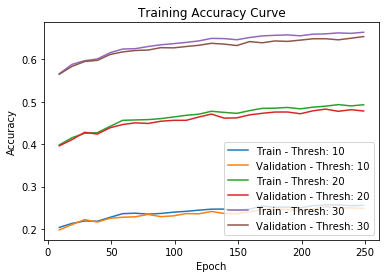

---[ITER 10] loss: 0.326272  time: 2.590
---[ITER 20] loss: 0.313752  time: 2.573
---[ITER 30] loss: 0.339723  time: 2.584
---[ITER 40] loss: 0.339282  time: 2.654
---[ITER 50] loss: 0.332005  time: 2.611
---[ITER 60] loss: 0.335109  time: 2.557
---[ITER 70] loss: 0.329890  time: 2.568
---[ITER 80] loss: 0.335793  time: 2.542
---[ITER 90] loss: 0.337459  time: 2.554
---[ITER 100] loss: 0.315424  time: 2.566
---[ITER 110] loss: 0.330623  time: 2.533
---[ITER 120] loss: 0.320697  time: 2.684
---[ITER 130] loss: 0.328301  time: 2.531
---[ITER 140] loss: 0.333998  time: 2.596
---[ITER 150] loss: 0.337771  time: 2.524
---[ITER 160] loss: 0.324748  time: 2.539
[EPOCH 251] loss: 0.329755  time: 43.206
---[ITER 10] loss: 0.323047  time: 2.659
---[ITER 20] loss: 0.317313  time: 2.620
---[ITER 30] loss: 0.331847  time: 2.528
---[ITER 40] loss: 0.333848  time: 2.517
---[ITER 50] loss: 0.335447  time: 2.688
---[ITER 60] loss: 0.322736  time: 2.542
---[ITER 70] loss: 0.333986  time: 2.507
---[ITER 

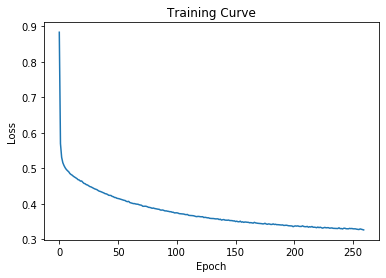

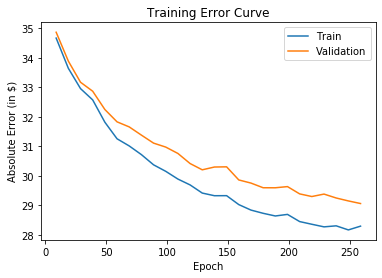

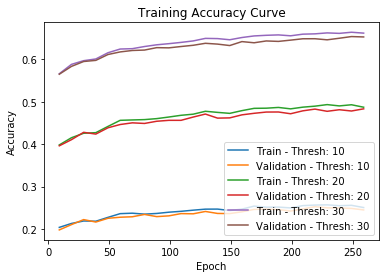

---[ITER 10] loss: 0.329033  time: 2.514
---[ITER 20] loss: 0.324924  time: 2.702
---[ITER 30] loss: 0.336050  time: 2.575
---[ITER 40] loss: 0.338828  time: 2.542
---[ITER 50] loss: 0.326853  time: 2.581
---[ITER 60] loss: 0.324607  time: 2.604
---[ITER 70] loss: 0.335831  time: 2.568
---[ITER 80] loss: 0.321016  time: 2.571
---[ITER 90] loss: 0.325505  time: 2.584
---[ITER 100] loss: 0.329095  time: 2.545
---[ITER 110] loss: 0.321428  time: 2.543
---[ITER 120] loss: 0.321792  time: 2.568
---[ITER 130] loss: 0.324375  time: 2.525
---[ITER 140] loss: 0.333766  time: 2.564
---[ITER 150] loss: 0.333445  time: 2.539
---[ITER 160] loss: 0.323779  time: 2.538
[EPOCH 261] loss: 0.328560  time: 43.017
---[ITER 10] loss: 0.333146  time: 2.557
---[ITER 20] loss: 0.329735  time: 2.583
---[ITER 30] loss: 0.322619  time: 2.548
---[ITER 40] loss: 0.323297  time: 2.534
---[ITER 50] loss: 0.319687  time: 2.612
---[ITER 60] loss: 0.326720  time: 2.601
---[ITER 70] loss: 0.324318  time: 2.561
---[ITER 

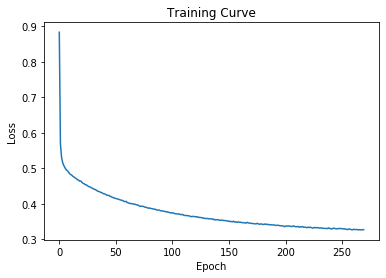

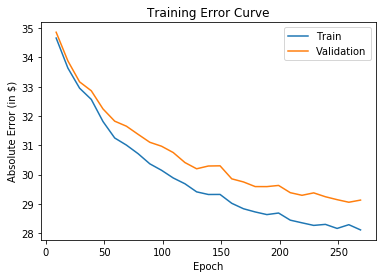

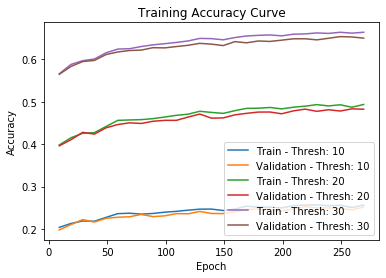

---[ITER 10] loss: 0.319266  time: 2.654
---[ITER 20] loss: 0.330785  time: 2.668
---[ITER 30] loss: 0.322876  time: 2.601
---[ITER 40] loss: 0.337661  time: 2.559
---[ITER 50] loss: 0.324774  time: 2.742
---[ITER 60] loss: 0.319596  time: 2.655
---[ITER 70] loss: 0.323180  time: 2.584
---[ITER 80] loss: 0.321373  time: 2.557
---[ITER 90] loss: 0.330249  time: 2.607
---[ITER 100] loss: 0.337345  time: 2.574
---[ITER 110] loss: 0.329401  time: 2.579
---[ITER 120] loss: 0.330949  time: 2.588
---[ITER 130] loss: 0.311787  time: 2.605
---[ITER 140] loss: 0.317220  time: 2.573
---[ITER 150] loss: 0.335212  time: 2.566
---[ITER 160] loss: 0.330179  time: 2.577
[EPOCH 271] loss: 0.326873  time: 43.717
---[ITER 10] loss: 0.329359  time: 2.579
---[ITER 20] loss: 0.324672  time: 2.594
---[ITER 30] loss: 0.336072  time: 2.592
---[ITER 40] loss: 0.320363  time: 2.580
---[ITER 50] loss: 0.316745  time: 2.560
---[ITER 60] loss: 0.326218  time: 2.563
---[ITER 70] loss: 0.324692  time: 2.580
---[ITER 

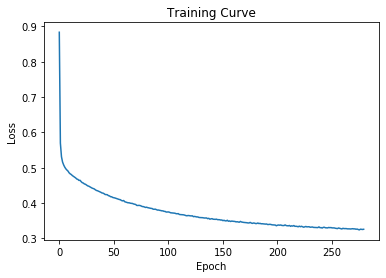

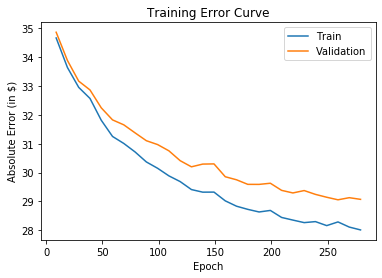

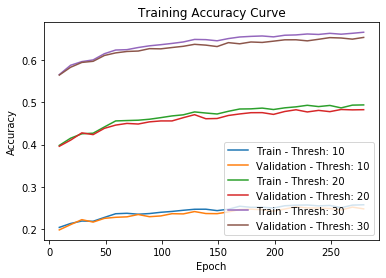

---[ITER 10] loss: 0.317944  time: 2.583
---[ITER 20] loss: 0.325629  time: 2.562
---[ITER 30] loss: 0.318894  time: 2.593
---[ITER 40] loss: 0.333792  time: 2.598
---[ITER 50] loss: 0.333155  time: 2.653
---[ITER 60] loss: 0.326853  time: 2.637
---[ITER 70] loss: 0.325382  time: 2.687
---[ITER 80] loss: 0.330131  time: 2.622
---[ITER 90] loss: 0.321744  time: 2.600
---[ITER 100] loss: 0.325217  time: 2.558
---[ITER 110] loss: 0.326764  time: 2.575
---[ITER 120] loss: 0.334168  time: 2.557
---[ITER 130] loss: 0.325058  time: 2.594
---[ITER 140] loss: 0.330880  time: 2.617
---[ITER 150] loss: 0.325937  time: 2.536
---[ITER 160] loss: 0.323123  time: 2.539
[EPOCH 281] loss: 0.325924  time: 43.475
---[ITER 10] loss: 0.325214  time: 2.552
---[ITER 20] loss: 0.326798  time: 2.630
---[ITER 30] loss: 0.312452  time: 2.582
---[ITER 40] loss: 0.330919  time: 2.548
---[ITER 50] loss: 0.322539  time: 2.588
---[ITER 60] loss: 0.330384  time: 2.575
---[ITER 70] loss: 0.323538  time: 2.590
---[ITER 

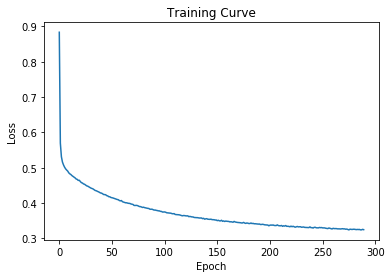

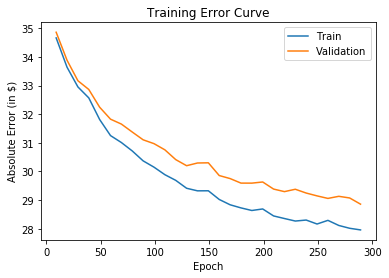

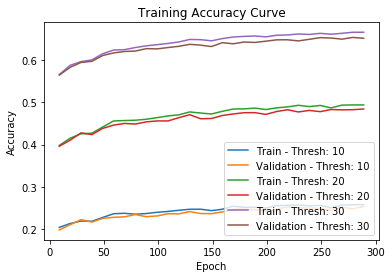

---[ITER 10] loss: 0.317049  time: 2.570
---[ITER 20] loss: 0.332917  time: 2.646
---[ITER 30] loss: 0.325010  time: 2.624
---[ITER 40] loss: 0.310782  time: 2.585
---[ITER 50] loss: 0.322937  time: 2.556
---[ITER 60] loss: 0.332988  time: 2.739
---[ITER 70] loss: 0.320720  time: 2.697
---[ITER 80] loss: 0.316312  time: 2.601
---[ITER 90] loss: 0.319556  time: 2.597
---[ITER 100] loss: 0.331196  time: 2.990
---[ITER 110] loss: 0.332138  time: 2.589
---[ITER 120] loss: 0.317186  time: 2.826
---[ITER 130] loss: 0.320520  time: 3.242
---[ITER 140] loss: 0.313411  time: 2.763
---[ITER 150] loss: 0.324065  time: 2.722
---[ITER 160] loss: 0.331758  time: 2.665
[EPOCH 291] loss: 0.322753  time: 45.485
---[ITER 10] loss: 0.324811  time: 2.945
---[ITER 20] loss: 0.329824  time: 2.788
---[ITER 30] loss: 0.312341  time: 2.877
---[ITER 40] loss: 0.347950  time: 2.804
---[ITER 50] loss: 0.327953  time: 2.944
---[ITER 60] loss: 0.319864  time: 3.289
---[ITER 70] loss: 0.325424  time: 2.820
---[ITER 

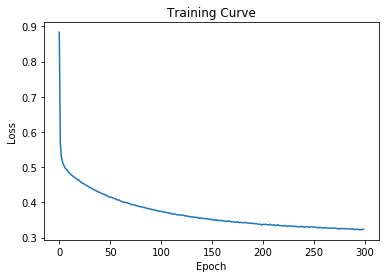

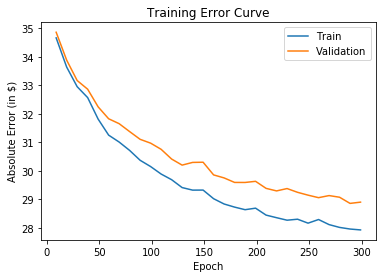

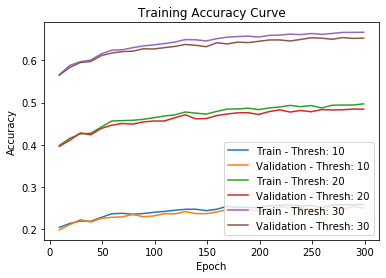

---[ITER 10] loss: 0.334840  time: 2.689
---[ITER 20] loss: 0.324628  time: 2.641
---[ITER 30] loss: 0.324275  time: 2.727
---[ITER 40] loss: 0.335746  time: 2.660
---[ITER 50] loss: 0.317284  time: 2.560
---[ITER 60] loss: 0.313932  time: 2.595
---[ITER 70] loss: 0.332355  time: 2.719
---[ITER 80] loss: 0.313672  time: 2.615
---[ITER 90] loss: 0.306556  time: 2.568
---[ITER 100] loss: 0.322552  time: 2.573
---[ITER 110] loss: 0.329591  time: 2.548
---[ITER 120] loss: 0.333656  time: 2.597
---[ITER 130] loss: 0.334200  time: 2.605
---[ITER 140] loss: 0.317890  time: 2.569
---[ITER 150] loss: 0.313775  time: 2.576
---[ITER 160] loss: 0.319641  time: 2.551
[EPOCH 301] loss: 0.323370  time: 43.791
---[ITER 10] loss: 0.334012  time: 2.580
---[ITER 20] loss: 0.320291  time: 2.598
---[ITER 30] loss: 0.325964  time: 2.589
---[ITER 40] loss: 0.315422  time: 2.590
---[ITER 50] loss: 0.320982  time: 2.645
---[ITER 60] loss: 0.326221  time: 2.562
---[ITER 70] loss: 0.317738  time: 2.581
---[ITER 

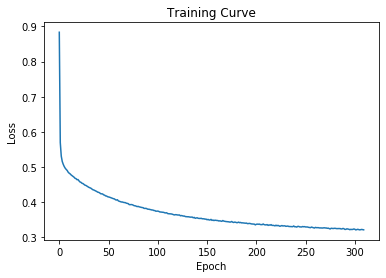

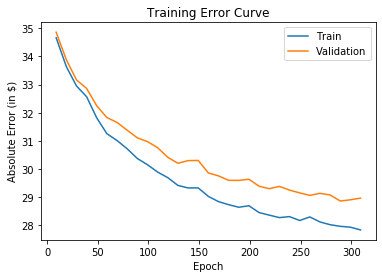

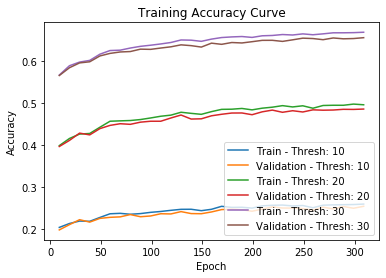

---[ITER 10] loss: 0.340138  time: 2.734
---[ITER 20] loss: 0.316340  time: 2.584
---[ITER 30] loss: 0.323998  time: 2.617
---[ITER 40] loss: 0.321769  time: 2.588
---[ITER 50] loss: 0.324088  time: 2.610
---[ITER 60] loss: 0.317566  time: 2.651
---[ITER 70] loss: 0.326962  time: 2.568
---[ITER 80] loss: 0.325446  time: 2.605
---[ITER 90] loss: 0.323612  time: 2.702
---[ITER 100] loss: 0.331067  time: 2.617
---[ITER 110] loss: 0.314100  time: 2.578
---[ITER 120] loss: 0.322848  time: 2.567
---[ITER 130] loss: 0.328011  time: 2.547
---[ITER 140] loss: 0.321687  time: 2.625
---[ITER 150] loss: 0.328649  time: 2.617
---[ITER 160] loss: 0.299350  time: 2.550
[EPOCH 311] loss: 0.323035  time: 43.729
---[ITER 10] loss: 0.310864  time: 2.599
---[ITER 20] loss: 0.314822  time: 2.597
---[ITER 30] loss: 0.331761  time: 2.579
---[ITER 40] loss: 0.324317  time: 2.591
---[ITER 50] loss: 0.318183  time: 2.661
---[ITER 60] loss: 0.327783  time: 2.536
---[ITER 70] loss: 0.311712  time: 2.591
---[ITER 

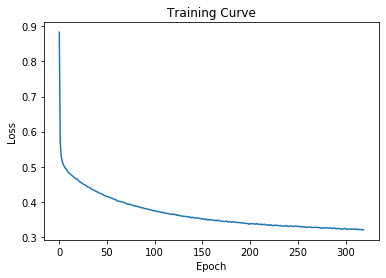

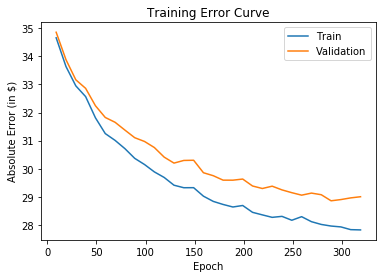

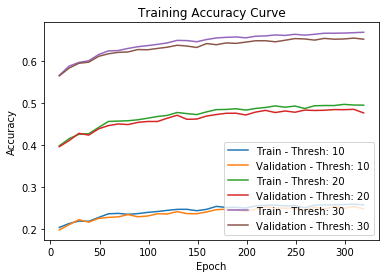

---[ITER 10] loss: 0.315130  time: 2.671
---[ITER 20] loss: 0.313447  time: 2.613
---[ITER 30] loss: 0.319476  time: 2.573
---[ITER 40] loss: 0.320331  time: 2.604
---[ITER 50] loss: 0.324821  time: 2.565
---[ITER 60] loss: 0.310787  time: 2.569
---[ITER 70] loss: 0.314640  time: 2.583
---[ITER 80] loss: 0.316448  time: 2.580
---[ITER 90] loss: 0.330759  time: 2.563
---[ITER 100] loss: 0.316615  time: 2.595
---[ITER 110] loss: 0.320448  time: 2.626
---[ITER 120] loss: 0.323527  time: 2.594
---[ITER 130] loss: 0.330890  time: 2.715
---[ITER 140] loss: 0.321301  time: 2.706
---[ITER 150] loss: 0.326290  time: 2.548
---[ITER 160] loss: 0.317905  time: 2.608
[EPOCH 321] loss: 0.320839  time: 43.717
---[ITER 10] loss: 0.326247  time: 2.602
---[ITER 20] loss: 0.328634  time: 2.565
---[ITER 30] loss: 0.330819  time: 2.541
---[ITER 40] loss: 0.314393  time: 2.565
---[ITER 50] loss: 0.323259  time: 2.567
---[ITER 60] loss: 0.326542  time: 2.548
---[ITER 70] loss: 0.311994  time: 2.568
---[ITER 

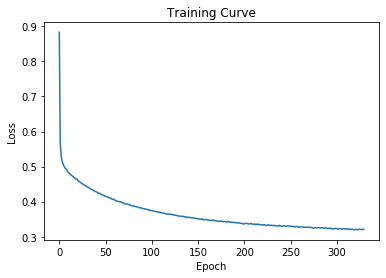

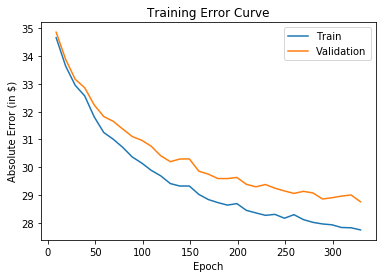

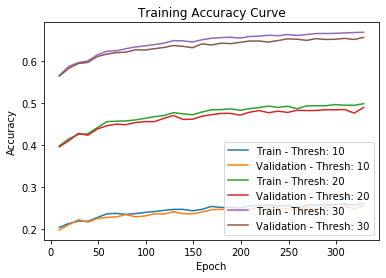

---[ITER 10] loss: 0.328910  time: 2.706
---[ITER 20] loss: 0.323108  time: 2.741
---[ITER 30] loss: 0.320675  time: 2.607
---[ITER 40] loss: 0.322096  time: 2.618
---[ITER 50] loss: 0.318679  time: 2.563
---[ITER 60] loss: 0.315895  time: 2.579
---[ITER 70] loss: 0.328098  time: 2.599
---[ITER 80] loss: 0.325022  time: 2.635
---[ITER 90] loss: 0.318326  time: 2.619
---[ITER 100] loss: 0.317938  time: 2.585
---[ITER 110] loss: 0.316149  time: 2.595
---[ITER 120] loss: 0.306669  time: 2.622
---[ITER 130] loss: 0.318149  time: 2.638
---[ITER 140] loss: 0.316370  time: 2.597
---[ITER 150] loss: 0.320971  time: 2.620
---[ITER 160] loss: 0.318448  time: 2.695
[EPOCH 331] loss: 0.320208  time: 44.051
---[ITER 10] loss: 0.329100  time: 2.596
---[ITER 20] loss: 0.322472  time: 2.582
---[ITER 30] loss: 0.312875  time: 2.518
---[ITER 40] loss: 0.330325  time: 2.559
---[ITER 50] loss: 0.321602  time: 2.563
---[ITER 60] loss: 0.319641  time: 2.558
---[ITER 70] loss: 0.322541  time: 2.555
---[ITER 

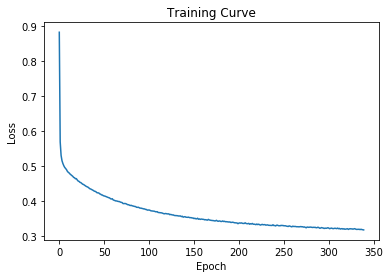

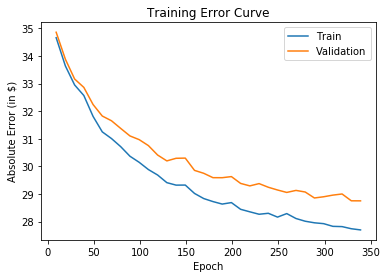

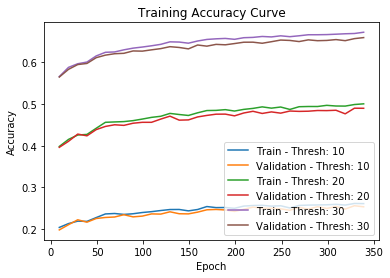

---[ITER 10] loss: 0.321320  time: 2.912
---[ITER 20] loss: 0.325194  time: 2.586
---[ITER 30] loss: 0.320449  time: 2.627
---[ITER 40] loss: 0.315876  time: 2.608
---[ITER 50] loss: 0.317768  time: 2.597
---[ITER 60] loss: 0.323386  time: 2.626
---[ITER 70] loss: 0.310308  time: 2.544
---[ITER 80] loss: 0.321945  time: 2.609
---[ITER 90] loss: 0.306738  time: 2.586
---[ITER 100] loss: 0.320263  time: 2.635
---[ITER 110] loss: 0.318838  time: 2.573
---[ITER 120] loss: 0.315322  time: 2.547
---[ITER 130] loss: 0.322051  time: 2.534
---[ITER 140] loss: 0.313234  time: 2.708
---[ITER 150] loss: 0.325598  time: 2.618
---[ITER 160] loss: 0.318547  time: 2.570
[EPOCH 341] loss: 0.318884  time: 43.866
---[ITER 10] loss: 0.311277  time: 2.703
---[ITER 20] loss: 0.331583  time: 2.582
---[ITER 30] loss: 0.307126  time: 2.589
---[ITER 40] loss: 0.316111  time: 2.574
---[ITER 50] loss: 0.318073  time: 2.578
---[ITER 60] loss: 0.308709  time: 2.547
---[ITER 70] loss: 0.325196  time: 2.582
---[ITER 

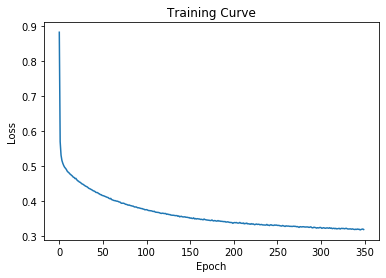

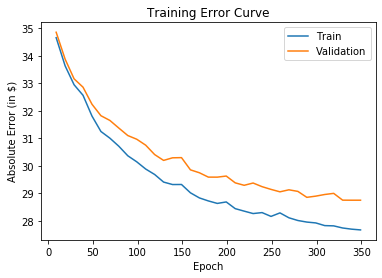

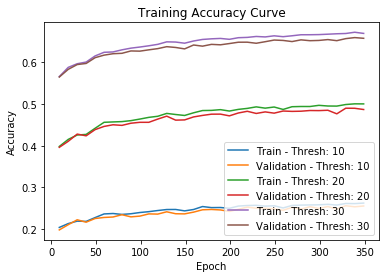

---[ITER 10] loss: 0.324954  time: 2.659
---[ITER 20] loss: 0.323871  time: 2.589
---[ITER 30] loss: 0.328481  time: 2.730
---[ITER 40] loss: 0.304033  time: 2.571
---[ITER 50] loss: 0.322361  time: 2.553
---[ITER 60] loss: 0.307266  time: 2.540
---[ITER 70] loss: 0.313444  time: 2.597
---[ITER 80] loss: 0.306605  time: 2.579
---[ITER 90] loss: 0.333812  time: 2.583
---[ITER 100] loss: 0.315097  time: 2.564
---[ITER 110] loss: 0.317832  time: 2.567
---[ITER 120] loss: 0.313919  time: 2.623
---[ITER 130] loss: 0.309450  time: 2.580
---[ITER 140] loss: 0.323347  time: 2.577
---[ITER 150] loss: 0.322112  time: 2.574
---[ITER 160] loss: 0.328831  time: 2.635
[EPOCH 351] loss: 0.318183  time: 43.580
---[ITER 10] loss: 0.318284  time: 2.627
---[ITER 20] loss: 0.321264  time: 2.561
---[ITER 30] loss: 0.316143  time: 2.716
---[ITER 40] loss: 0.333288  time: 2.553
---[ITER 50] loss: 0.298985  time: 2.578
---[ITER 60] loss: 0.320152  time: 2.548
---[ITER 70] loss: 0.331159  time: 2.593
---[ITER 

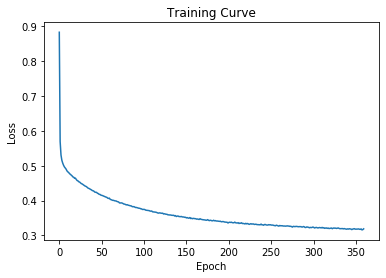

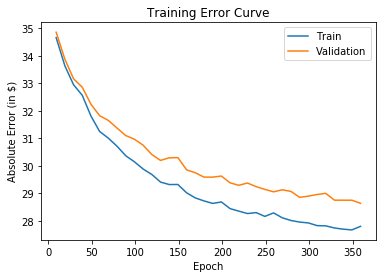

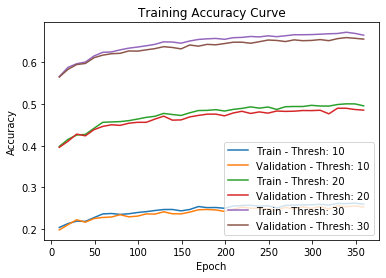

---[ITER 10] loss: 0.320065  time: 2.724
---[ITER 20] loss: 0.312199  time: 2.641
---[ITER 30] loss: 0.325989  time: 2.596
---[ITER 40] loss: 0.318366  time: 2.625
---[ITER 50] loss: 0.316062  time: 2.557
---[ITER 60] loss: 0.318196  time: 2.616
---[ITER 70] loss: 0.329778  time: 2.587
---[ITER 80] loss: 0.311822  time: 2.550
---[ITER 90] loss: 0.322851  time: 2.601
---[ITER 100] loss: 0.321451  time: 2.574
---[ITER 110] loss: 0.316073  time: 2.570
---[ITER 120] loss: 0.314847  time: 2.568
---[ITER 130] loss: 0.304908  time: 2.579
---[ITER 140] loss: 0.309898  time: 2.599
---[ITER 150] loss: 0.320100  time: 2.605
---[ITER 160] loss: 0.324154  time: 2.561
[EPOCH 361] loss: 0.317773  time: 43.518
---[ITER 10] loss: 0.322234  time: 2.590
---[ITER 20] loss: 0.314399  time: 2.622
---[ITER 30] loss: 0.305309  time: 2.646
---[ITER 40] loss: 0.323391  time: 2.614
---[ITER 50] loss: 0.329495  time: 2.568
---[ITER 60] loss: 0.311974  time: 2.768
---[ITER 70] loss: 0.317933  time: 2.607
---[ITER 

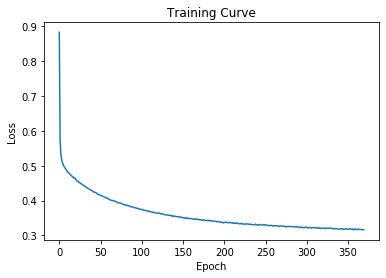

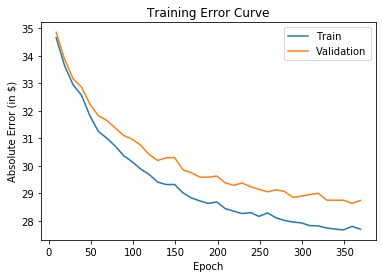

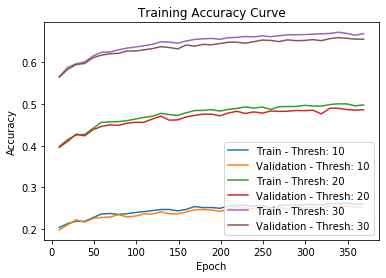

---[ITER 10] loss: 0.322631  time: 2.835
---[ITER 20] loss: 0.313185  time: 2.703
---[ITER 30] loss: 0.316888  time: 3.033
---[ITER 40] loss: 0.316357  time: 3.004
---[ITER 50] loss: 0.312152  time: 2.717
---[ITER 60] loss: 0.322192  time: 2.629
---[ITER 70] loss: 0.322052  time: 2.617
---[ITER 80] loss: 0.311027  time: 2.630
---[ITER 90] loss: 0.326437  time: 2.932
---[ITER 100] loss: 0.308219  time: 2.694
---[ITER 110] loss: 0.301300  time: 2.669
---[ITER 120] loss: 0.310770  time: 2.719
---[ITER 130] loss: 0.314897  time: 2.722
---[ITER 140] loss: 0.323747  time: 2.825
---[ITER 150] loss: 0.313353  time: 2.650
---[ITER 160] loss: 0.324049  time: 2.738
[EPOCH 371] loss: 0.315867  time: 46.132
---[ITER 10] loss: 0.305168  time: 2.724
---[ITER 20] loss: 0.310352  time: 2.705
---[ITER 30] loss: 0.330139  time: 2.967
---[ITER 40] loss: 0.327978  time: 3.044
---[ITER 50] loss: 0.319959  time: 2.874
---[ITER 60] loss: 0.319736  time: 2.931
---[ITER 70] loss: 0.309379  time: 2.806
---[ITER 

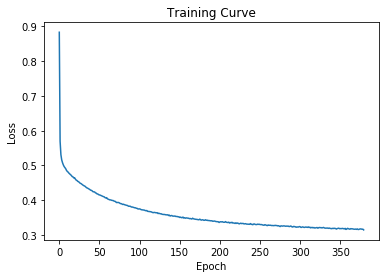

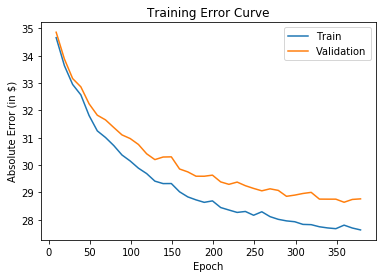

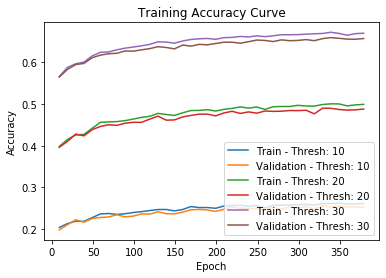

---[ITER 10] loss: 0.307363  time: 2.643
---[ITER 20] loss: 0.317073  time: 2.663
---[ITER 30] loss: 0.317285  time: 2.655
---[ITER 40] loss: 0.307155  time: 2.606
---[ITER 50] loss: 0.312039  time: 2.785
---[ITER 60] loss: 0.319399  time: 2.617
---[ITER 70] loss: 0.319655  time: 2.568
---[ITER 80] loss: 0.310847  time: 2.608
---[ITER 90] loss: 0.325182  time: 2.576
---[ITER 100] loss: 0.320100  time: 2.582
---[ITER 110] loss: 0.310175  time: 2.570
---[ITER 120] loss: 0.318362  time: 2.568
---[ITER 130] loss: 0.308086  time: 2.601
---[ITER 140] loss: 0.321242  time: 2.615
---[ITER 150] loss: 0.317151  time: 2.582
---[ITER 160] loss: 0.316762  time: 2.615
[EPOCH 381] loss: 0.315637  time: 43.909
---[ITER 10] loss: 0.320876  time: 2.672
---[ITER 20] loss: 0.325910  time: 2.644
---[ITER 30] loss: 0.320609  time: 2.602
---[ITER 40] loss: 0.315245  time: 2.550
---[ITER 50] loss: 0.299491  time: 2.698
---[ITER 60] loss: 0.315668  time: 2.643
---[ITER 70] loss: 0.312838  time: 2.572
---[ITER 

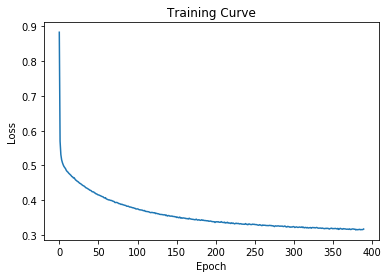

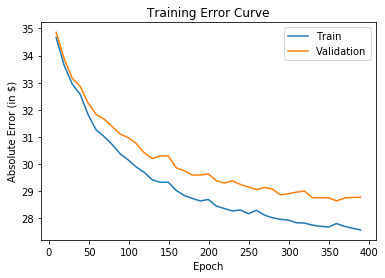

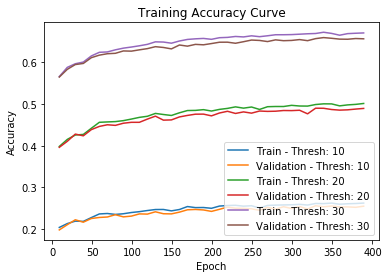

---[ITER 10] loss: 0.314171  time: 2.712
---[ITER 20] loss: 0.319636  time: 2.601
---[ITER 30] loss: 0.332625  time: 2.595
---[ITER 40] loss: 0.324672  time: 2.601
---[ITER 50] loss: 0.320513  time: 2.519
---[ITER 60] loss: 0.310689  time: 2.586
---[ITER 70] loss: 0.306817  time: 2.611
---[ITER 80] loss: 0.320735  time: 2.571
---[ITER 90] loss: 0.323104  time: 2.580
---[ITER 100] loss: 0.322215  time: 2.565
---[ITER 110] loss: 0.315416  time: 2.549
---[ITER 120] loss: 0.317636  time: 2.549
---[ITER 130] loss: 0.309144  time: 2.582
---[ITER 140] loss: 0.310207  time: 2.604
---[ITER 150] loss: 0.303884  time: 2.595
---[ITER 160] loss: 0.315242  time: 2.623
[EPOCH 391] loss: 0.316652  time: 43.477
---[ITER 10] loss: 0.316044  time: 2.596
---[ITER 20] loss: 0.318893  time: 2.592
---[ITER 30] loss: 0.305330  time: 2.545
---[ITER 40] loss: 0.316051  time: 2.590
---[ITER 50] loss: 0.316572  time: 2.620
---[ITER 60] loss: 0.321993  time: 2.613
---[ITER 70] loss: 0.321344  time: 2.668
---[ITER 

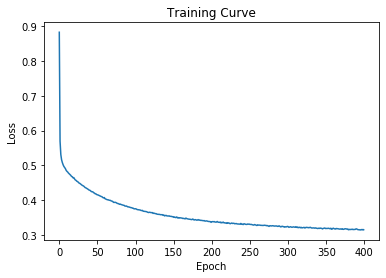

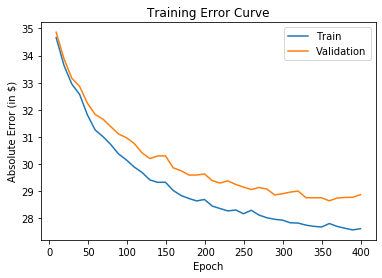

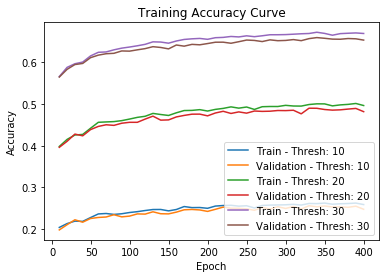

---[ITER 10] loss: 0.304577  time: 2.624
---[ITER 20] loss: 0.315040  time: 2.717
---[ITER 30] loss: 0.314185  time: 2.611
---[ITER 40] loss: 0.323577  time: 2.724
---[ITER 50] loss: 0.319829  time: 2.607
---[ITER 60] loss: 0.321131  time: 2.580
---[ITER 70] loss: 0.324250  time: 2.600
---[ITER 80] loss: 0.306774  time: 2.549
---[ITER 90] loss: 0.317498  time: 2.566
---[ITER 100] loss: 0.314114  time: 2.637
---[ITER 110] loss: 0.309941  time: 2.544
---[ITER 120] loss: 0.311594  time: 2.574
---[ITER 130] loss: 0.322080  time: 2.618
---[ITER 140] loss: 0.311615  time: 2.627
---[ITER 150] loss: 0.314023  time: 2.539
---[ITER 160] loss: 0.315711  time: 2.552
[EPOCH 401] loss: 0.315393  time: 43.656
---[ITER 10] loss: 0.307854  time: 2.567
---[ITER 20] loss: 0.309094  time: 2.635
---[ITER 30] loss: 0.315898  time: 2.557
---[ITER 40] loss: 0.321010  time: 2.578
---[ITER 50] loss: 0.313153  time: 2.589
---[ITER 60] loss: 0.302878  time: 2.615
---[ITER 70] loss: 0.329318  time: 2.594
---[ITER 

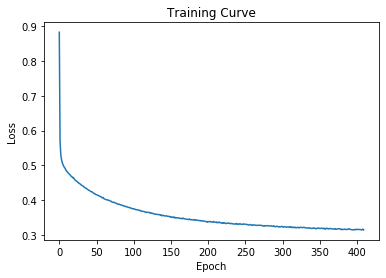

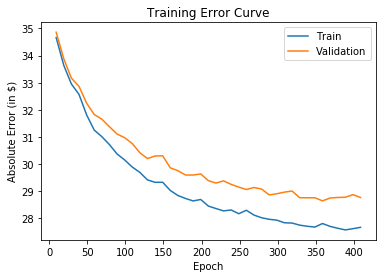

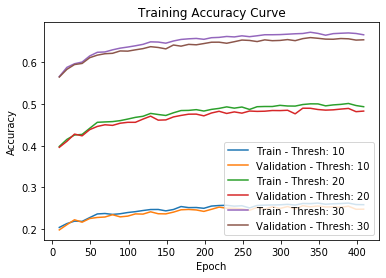

---[ITER 10] loss: 0.321561  time: 2.710
---[ITER 20] loss: 0.310986  time: 2.729
---[ITER 30] loss: 0.319759  time: 2.560
---[ITER 40] loss: 0.303585  time: 2.560
---[ITER 50] loss: 0.317958  time: 2.702
---[ITER 60] loss: 0.316905  time: 2.575
---[ITER 70] loss: 0.315168  time: 2.614
---[ITER 80] loss: 0.321243  time: 2.603
---[ITER 90] loss: 0.318305  time: 2.600
---[ITER 100] loss: 0.308726  time: 2.577
---[ITER 110] loss: 0.312743  time: 2.575
---[ITER 120] loss: 0.303298  time: 2.568
---[ITER 130] loss: 0.311377  time: 2.617
---[ITER 140] loss: 0.318912  time: 2.625
---[ITER 150] loss: 0.319048  time: 2.619
---[ITER 160] loss: 0.310325  time: 2.581
[EPOCH 411] loss: 0.314074  time: 43.804
---[ITER 10] loss: 0.310157  time: 2.598
---[ITER 20] loss: 0.311386  time: 2.581
---[ITER 30] loss: 0.326794  time: 2.559
---[ITER 40] loss: 0.307499  time: 2.707
---[ITER 50] loss: 0.322629  time: 2.571
---[ITER 60] loss: 0.310277  time: 2.564
---[ITER 70] loss: 0.313183  time: 2.561
---[ITER 

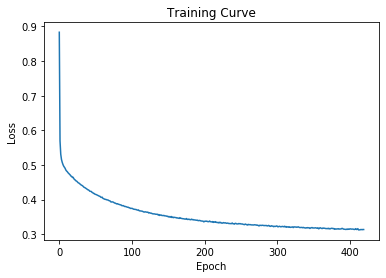

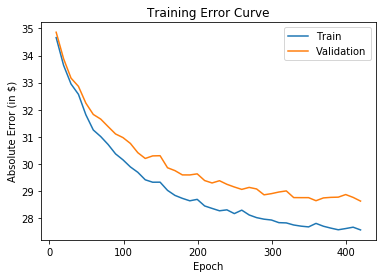

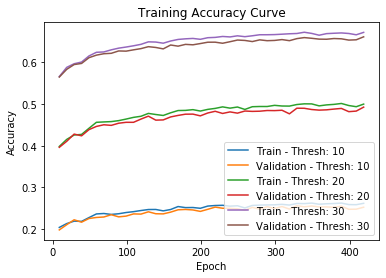

---[ITER 10] loss: 0.313916  time: 2.624
---[ITER 20] loss: 0.319882  time: 2.626
---[ITER 30] loss: 0.315303  time: 2.646
---[ITER 40] loss: 0.316322  time: 2.621
---[ITER 50] loss: 0.322578  time: 2.616
---[ITER 60] loss: 0.304674  time: 2.604
---[ITER 70] loss: 0.312551  time: 2.616
---[ITER 80] loss: 0.311677  time: 2.699
---[ITER 90] loss: 0.320839  time: 2.577
---[ITER 100] loss: 0.319143  time: 2.564
---[ITER 110] loss: 0.318048  time: 2.575
---[ITER 120] loss: 0.303591  time: 2.563
---[ITER 130] loss: 0.308892  time: 2.560
---[ITER 140] loss: 0.309023  time: 2.586
---[ITER 150] loss: 0.321451  time: 2.581
---[ITER 160] loss: 0.295940  time: 2.588
[EPOCH 421] loss: 0.313193  time: 43.687
---[ITER 10] loss: 0.320567  time: 2.565
---[ITER 20] loss: 0.314034  time: 2.611
---[ITER 30] loss: 0.316496  time: 2.588
---[ITER 40] loss: 0.333082  time: 2.559
---[ITER 50] loss: 0.300064  time: 2.532
---[ITER 60] loss: 0.314901  time: 2.563
---[ITER 70] loss: 0.305290  time: 2.581
---[ITER 

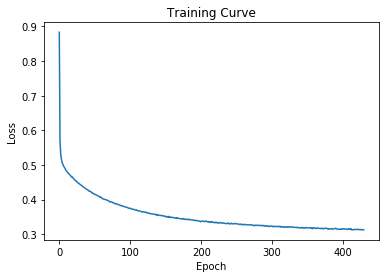

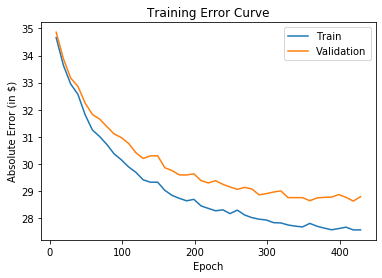

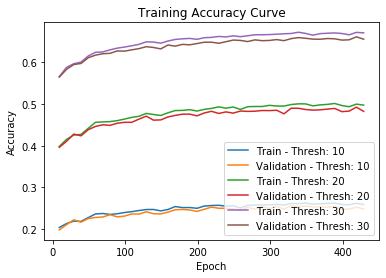

---[ITER 10] loss: 0.308260  time: 2.691
---[ITER 20] loss: 0.314803  time: 2.702
---[ITER 30] loss: 0.323242  time: 2.637
---[ITER 40] loss: 0.312966  time: 2.766
---[ITER 50] loss: 0.316574  time: 2.870
---[ITER 60] loss: 0.311822  time: 2.752
---[ITER 70] loss: 0.318298  time: 2.749
---[ITER 80] loss: 0.312520  time: 2.720
---[ITER 90] loss: 0.307280  time: 2.843
---[ITER 100] loss: 0.321093  time: 2.866
---[ITER 110] loss: 0.306208  time: 2.732
---[ITER 120] loss: 0.318272  time: 2.712
---[ITER 130] loss: 0.308591  time: 2.788
---[ITER 140] loss: 0.323082  time: 2.880
---[ITER 150] loss: 0.311551  time: 3.084
---[ITER 160] loss: 0.318879  time: 2.903
[EPOCH 431] loss: 0.314493  time: 46.783
---[ITER 10] loss: 0.317549  time: 2.808
---[ITER 20] loss: 0.316824  time: 2.969
---[ITER 30] loss: 0.312722  time: 2.830
---[ITER 40] loss: 0.305257  time: 2.741
---[ITER 50] loss: 0.307506  time: 2.719
---[ITER 60] loss: 0.325324  time: 2.817
---[ITER 70] loss: 0.315662  time: 2.722
---[ITER 

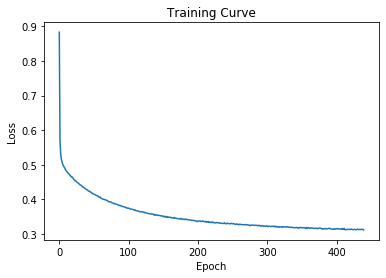

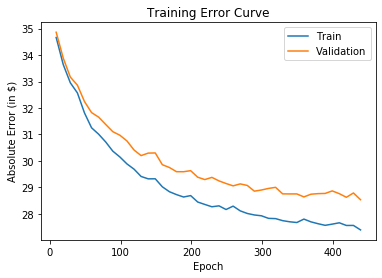

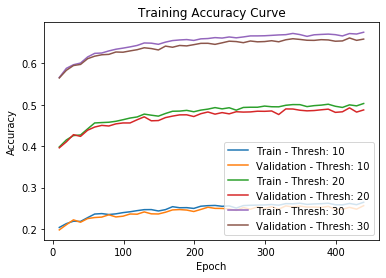

---[ITER 10] loss: 0.310047  time: 2.653
---[ITER 20] loss: 0.311176  time: 2.563
---[ITER 30] loss: 0.313752  time: 2.606
---[ITER 40] loss: 0.312168  time: 2.602
---[ITER 50] loss: 0.313155  time: 2.645
---[ITER 60] loss: 0.321458  time: 2.682
---[ITER 70] loss: 0.314448  time: 2.574
---[ITER 80] loss: 0.314054  time: 2.624
---[ITER 90] loss: 0.314335  time: 3.221
---[ITER 100] loss: 0.323848  time: 2.596
---[ITER 110] loss: 0.304903  time: 2.553
---[ITER 120] loss: 0.299837  time: 2.572
---[ITER 130] loss: 0.306742  time: 2.568
---[ITER 140] loss: 0.309732  time: 2.621
---[ITER 150] loss: 0.322062  time: 2.615
---[ITER 160] loss: 0.323211  time: 2.598
[EPOCH 441] loss: 0.312843  time: 44.414
---[ITER 10] loss: 0.308597  time: 2.585
---[ITER 20] loss: 0.320802  time: 2.584
---[ITER 30] loss: 0.323172  time: 2.618
---[ITER 40] loss: 0.305563  time: 2.536
---[ITER 50] loss: 0.314068  time: 2.537
---[ITER 60] loss: 0.312714  time: 2.615
---[ITER 70] loss: 0.304114  time: 2.607
---[ITER 

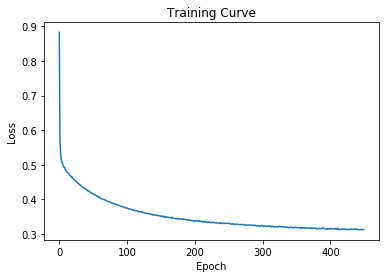

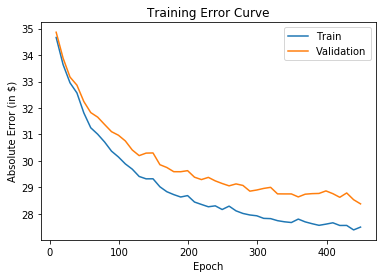

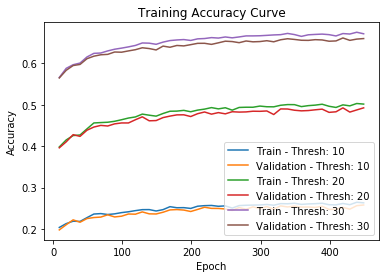

---[ITER 10] loss: 0.316957  time: 2.593
---[ITER 20] loss: 0.303733  time: 2.567
---[ITER 30] loss: 0.312630  time: 2.616
---[ITER 40] loss: 0.318246  time: 2.583
---[ITER 50] loss: 0.303797  time: 2.558
---[ITER 60] loss: 0.333145  time: 2.572
---[ITER 70] loss: 0.315821  time: 2.632
---[ITER 80] loss: 0.306591  time: 2.638
---[ITER 90] loss: 0.308913  time: 2.622
---[ITER 100] loss: 0.311581  time: 2.585
---[ITER 110] loss: 0.299777  time: 2.706
---[ITER 120] loss: 0.313398  time: 2.563
---[ITER 130] loss: 0.310054  time: 2.564
---[ITER 140] loss: 0.308873  time: 2.631
---[ITER 150] loss: 0.306960  time: 2.587
---[ITER 160] loss: 0.313697  time: 2.572
[EPOCH 451] loss: 0.311300  time: 43.594
---[ITER 10] loss: 0.316052  time: 2.580
---[ITER 20] loss: 0.314702  time: 2.561
---[ITER 30] loss: 0.304434  time: 2.585
---[ITER 40] loss: 0.310308  time: 2.547
---[ITER 50] loss: 0.318934  time: 2.572
---[ITER 60] loss: 0.315049  time: 2.550
---[ITER 70] loss: 0.301545  time: 2.549
---[ITER 

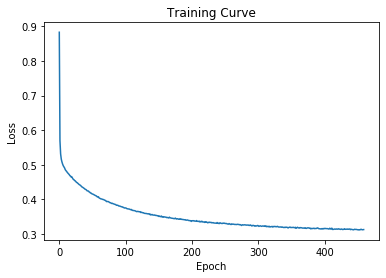

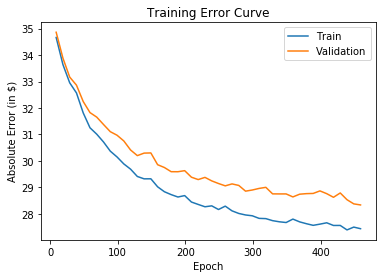

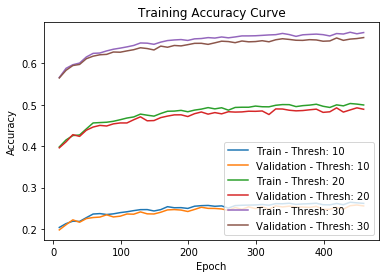

---[ITER 10] loss: 0.312342  time: 2.623
---[ITER 20] loss: 0.301164  time: 2.578
---[ITER 30] loss: 0.315317  time: 2.564
---[ITER 40] loss: 0.304642  time: 2.569
---[ITER 50] loss: 0.303984  time: 3.390
---[ITER 60] loss: 0.306879  time: 4.038
---[ITER 70] loss: 0.311484  time: 2.535
---[ITER 80] loss: 0.314057  time: 2.539
---[ITER 90] loss: 0.326769  time: 2.697
---[ITER 100] loss: 0.319353  time: 2.707
---[ITER 110] loss: 0.311550  time: 2.536
---[ITER 120] loss: 0.310457  time: 2.528
---[ITER 130] loss: 0.302595  time: 2.683
---[ITER 140] loss: 0.314762  time: 2.628
---[ITER 150] loss: 0.317265  time: 2.538
---[ITER 160] loss: 0.298321  time: 2.537
[EPOCH 461] loss: 0.310575  time: 45.664
---[ITER 10] loss: 0.305841  time: 2.516
---[ITER 20] loss: 0.315842  time: 2.595
---[ITER 30] loss: 0.311244  time: 2.524
---[ITER 40] loss: 0.317803  time: 2.643
---[ITER 50] loss: 0.304698  time: 2.500
---[ITER 60] loss: 0.312207  time: 2.561
---[ITER 70] loss: 0.318561  time: 2.575
---[ITER 

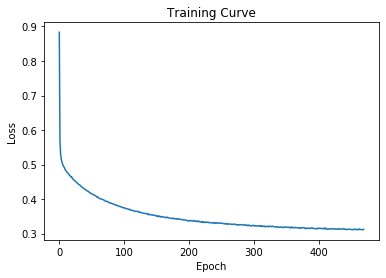

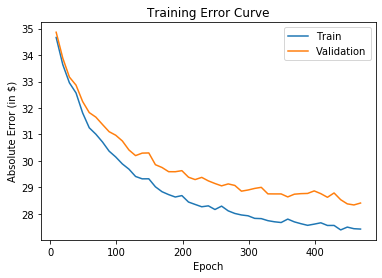

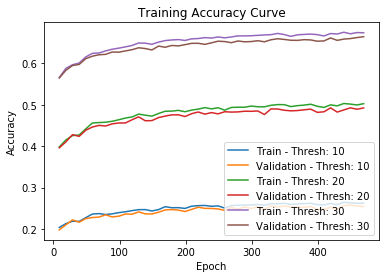

---[ITER 10] loss: 0.309360  time: 2.559
---[ITER 20] loss: 0.316878  time: 2.548
---[ITER 30] loss: 0.313625  time: 2.564
---[ITER 40] loss: 0.315615  time: 2.549
---[ITER 50] loss: 0.310417  time: 2.542
---[ITER 60] loss: 0.314585  time: 2.542
---[ITER 70] loss: 0.303732  time: 2.544
---[ITER 80] loss: 0.320148  time: 2.535
---[ITER 90] loss: 0.318383  time: 2.525
---[ITER 100] loss: 0.299421  time: 2.558
---[ITER 110] loss: 0.307373  time: 2.554
---[ITER 120] loss: 0.295842  time: 2.553
---[ITER 130] loss: 0.308705  time: 2.535
---[ITER 140] loss: 0.307086  time: 2.652
---[ITER 150] loss: 0.324039  time: 2.558
---[ITER 160] loss: 0.309874  time: 2.571
[EPOCH 471] loss: 0.310970  time: 42.868
---[ITER 10] loss: 0.322928  time: 2.699
---[ITER 20] loss: 0.318481  time: 2.552
---[ITER 30] loss: 0.309915  time: 2.540
---[ITER 40] loss: 0.322615  time: 2.527
---[ITER 50] loss: 0.306982  time: 2.526
---[ITER 60] loss: 0.316266  time: 2.519
---[ITER 70] loss: 0.301389  time: 2.516
---[ITER 

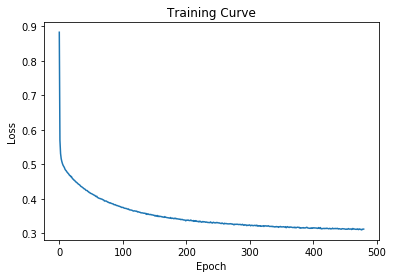

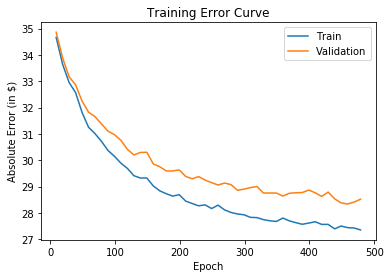

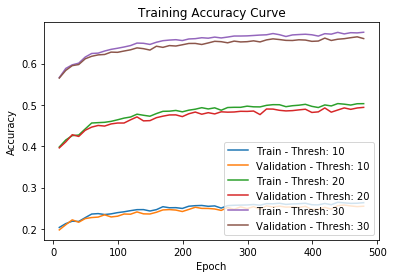

---[ITER 10] loss: 0.315160  time: 2.608
---[ITER 20] loss: 0.299744  time: 2.531
---[ITER 30] loss: 0.307929  time: 2.611
---[ITER 40] loss: 0.318500  time: 2.590
---[ITER 50] loss: 0.307517  time: 2.564
---[ITER 60] loss: 0.305323  time: 2.580
---[ITER 70] loss: 0.319249  time: 2.540
---[ITER 80] loss: 0.322590  time: 2.555
---[ITER 90] loss: 0.305506  time: 2.542
---[ITER 100] loss: 0.307381  time: 2.549
---[ITER 110] loss: 0.304784  time: 2.577
---[ITER 120] loss: 0.322094  time: 2.550
---[ITER 130] loss: 0.316952  time: 2.530
---[ITER 140] loss: 0.314942  time: 2.585
---[ITER 150] loss: 0.318000  time: 2.604
---[ITER 160] loss: 0.309440  time: 2.556
[EPOCH 481] loss: 0.312203  time: 43.047
---[ITER 10] loss: 0.319647  time: 2.541
---[ITER 20] loss: 0.314438  time: 2.548
---[ITER 30] loss: 0.303948  time: 2.567
---[ITER 40] loss: 0.308173  time: 2.569
---[ITER 50] loss: 0.305542  time: 2.546
---[ITER 60] loss: 0.319120  time: 2.573
---[ITER 70] loss: 0.320203  time: 2.685
---[ITER 

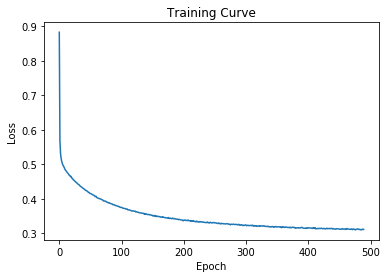

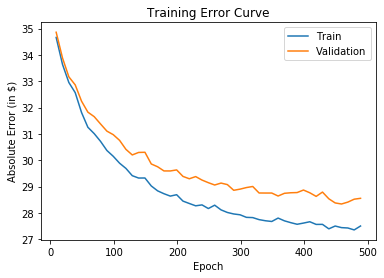

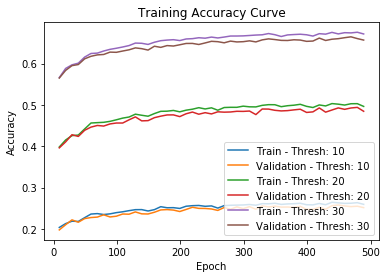

---[ITER 10] loss: 0.310977  time: 2.657
---[ITER 20] loss: 0.309848  time: 2.604
---[ITER 30] loss: 0.305489  time: 2.641
---[ITER 40] loss: 0.303530  time: 2.551
---[ITER 50] loss: 0.319880  time: 2.750
---[ITER 60] loss: 0.317601  time: 2.544
---[ITER 70] loss: 0.316457  time: 2.554
---[ITER 80] loss: 0.309619  time: 2.576
---[ITER 90] loss: 0.307607  time: 2.543
---[ITER 100] loss: 0.308713  time: 2.558
---[ITER 110] loss: 0.317102  time: 2.493
---[ITER 120] loss: 0.314794  time: 2.500
---[ITER 130] loss: 0.303039  time: 2.522
---[ITER 140] loss: 0.312546  time: 2.550
---[ITER 150] loss: 0.314153  time: 2.547
---[ITER 160] loss: 0.302846  time: 2.529
[EPOCH 491] loss: 0.310446  time: 43.096
---[ITER 10] loss: 0.311593  time: 2.616
---[ITER 20] loss: 0.307561  time: 2.589
---[ITER 30] loss: 0.319109  time: 2.548
---[ITER 40] loss: 0.297492  time: 2.528
---[ITER 50] loss: 0.312559  time: 2.538
---[ITER 60] loss: 0.305578  time: 2.538
---[ITER 70] loss: 0.298660  time: 2.534
---[ITER 

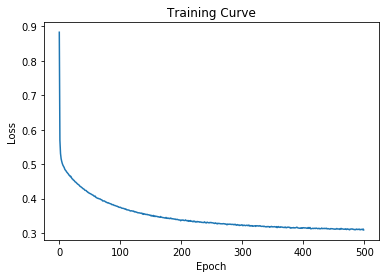

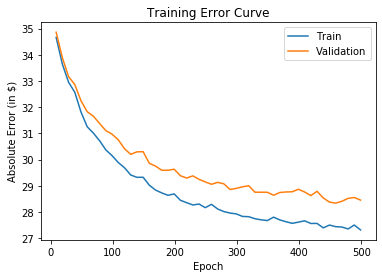

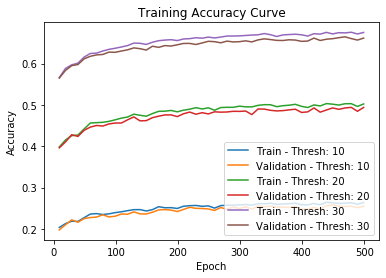

---[ITER 10] loss: 0.302426  time: 2.586
---[ITER 20] loss: 0.314477  time: 2.625
---[ITER 30] loss: 0.297451  time: 2.605
---[ITER 40] loss: 0.303139  time: 2.516
---[ITER 50] loss: 0.315297  time: 2.897
---[ITER 60] loss: 0.302694  time: 2.548
---[ITER 70] loss: 0.306899  time: 2.667
---[ITER 80] loss: 0.317283  time: 2.950
---[ITER 90] loss: 0.313951  time: 2.928
---[ITER 100] loss: 0.309282  time: 2.618
---[ITER 110] loss: 0.310968  time: 2.577
---[ITER 120] loss: 0.311173  time: 2.640
---[ITER 130] loss: 0.318658  time: 2.791
---[ITER 140] loss: 0.310660  time: 2.720
---[ITER 150] loss: 0.317888  time: 2.710
---[ITER 160] loss: 0.310791  time: 2.846
[EPOCH 501] loss: 0.310761  time: 45.371
---[ITER 10] loss: 0.306638  time: 2.684
---[ITER 20] loss: 0.315694  time: 2.680
---[ITER 30] loss: 0.295847  time: 2.689
---[ITER 40] loss: 0.303740  time: 3.011
---[ITER 50] loss: 0.316645  time: 2.978
---[ITER 60] loss: 0.301473  time: 2.750
---[ITER 70] loss: 0.312130  time: 2.814
---[ITER 

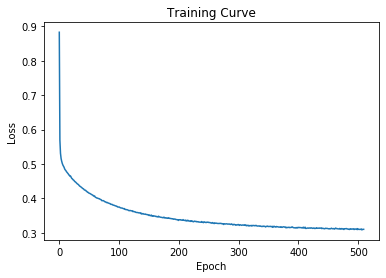

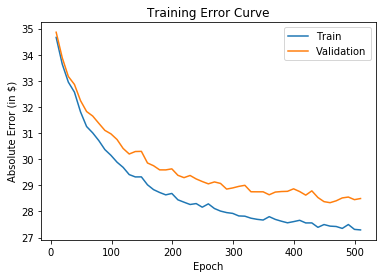

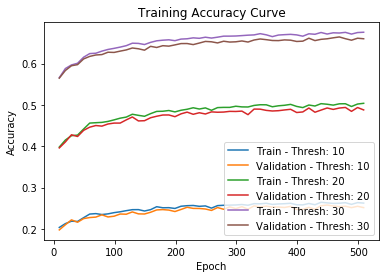

---[ITER 10] loss: 0.304339  time: 2.574
---[ITER 20] loss: 0.315263  time: 2.665
---[ITER 30] loss: 0.304795  time: 2.634
---[ITER 40] loss: 0.303093  time: 2.544
---[ITER 50] loss: 0.295464  time: 2.607
---[ITER 60] loss: 0.306205  time: 2.524
---[ITER 70] loss: 0.311701  time: 2.562
---[ITER 80] loss: 0.301609  time: 2.543
---[ITER 90] loss: 0.296553  time: 2.621
---[ITER 100] loss: 0.314837  time: 2.581
---[ITER 110] loss: 0.317651  time: 2.577
---[ITER 120] loss: 0.319366  time: 2.611
---[ITER 130] loss: 0.308989  time: 2.551
---[ITER 140] loss: 0.312517  time: 2.685
---[ITER 150] loss: 0.320629  time: 2.501
---[ITER 160] loss: 0.322028  time: 2.577
[EPOCH 511] loss: 0.309267  time: 43.322
---[ITER 10] loss: 0.310720  time: 2.539
---[ITER 20] loss: 0.305729  time: 2.582
---[ITER 30] loss: 0.304722  time: 2.544
---[ITER 40] loss: 0.312908  time: 2.480
---[ITER 50] loss: 0.310926  time: 2.505
---[ITER 60] loss: 0.293815  time: 2.506
---[ITER 70] loss: 0.320265  time: 2.568
---[ITER 

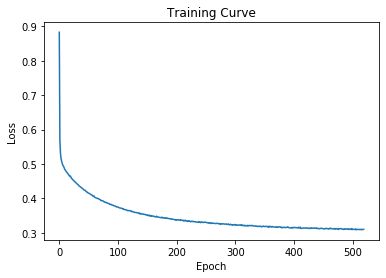

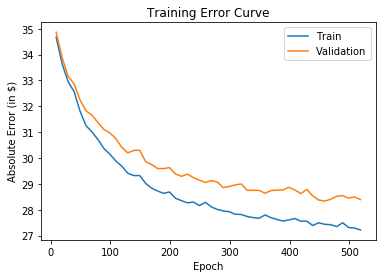

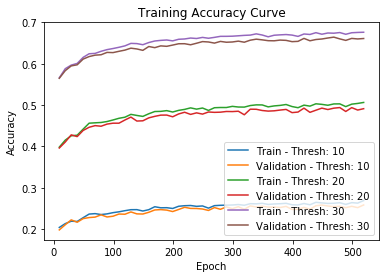

---[ITER 10] loss: 0.315749  time: 2.518
---[ITER 20] loss: 0.329700  time: 2.530
---[ITER 30] loss: 0.300929  time: 2.573
---[ITER 40] loss: 0.313002  time: 2.676
---[ITER 50] loss: 0.304905  time: 2.553
---[ITER 60] loss: 0.301783  time: 2.521
---[ITER 70] loss: 0.316221  time: 2.572
---[ITER 80] loss: 0.311475  time: 2.582
---[ITER 90] loss: 0.289788  time: 2.507
---[ITER 100] loss: 0.305629  time: 2.546
---[ITER 110] loss: 0.309519  time: 2.566
---[ITER 120] loss: 0.312643  time: 2.529
---[ITER 130] loss: 0.309188  time: 2.516
---[ITER 140] loss: 0.303508  time: 2.573
---[ITER 150] loss: 0.318951  time: 2.571
---[ITER 160] loss: 0.304298  time: 2.566
[EPOCH 521] loss: 0.309145  time: 42.896
---[ITER 10] loss: 0.313093  time: 2.508
---[ITER 20] loss: 0.307560  time: 2.622
---[ITER 30] loss: 0.306427  time: 2.583
---[ITER 40] loss: 0.313463  time: 2.521
---[ITER 50] loss: 0.299280  time: 2.511
---[ITER 60] loss: 0.318662  time: 2.502
---[ITER 70] loss: 0.321035  time: 2.446
---[ITER 

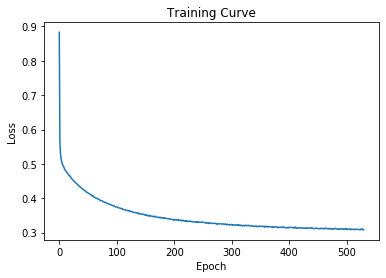

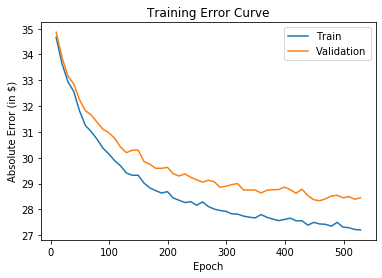

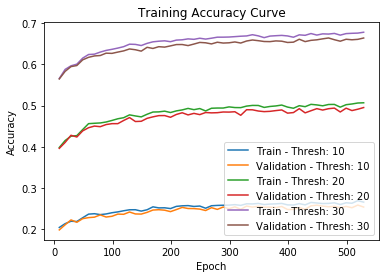

---[ITER 10] loss: 0.314294  time: 2.513
---[ITER 20] loss: 0.317048  time: 2.715
---[ITER 30] loss: 0.307661  time: 2.575
---[ITER 40] loss: 0.312113  time: 2.536
---[ITER 50] loss: 0.312024  time: 2.533
---[ITER 60] loss: 0.296306  time: 2.517
---[ITER 70] loss: 0.314629  time: 2.536
---[ITER 80] loss: 0.307153  time: 2.500
---[ITER 90] loss: 0.320088  time: 2.618
---[ITER 100] loss: 0.306229  time: 2.553
---[ITER 110] loss: 0.309452  time: 2.569
---[ITER 120] loss: 0.314270  time: 2.591
---[ITER 130] loss: 0.306570  time: 2.519
---[ITER 140] loss: 0.306604  time: 2.538
---[ITER 150] loss: 0.303908  time: 2.535
---[ITER 160] loss: 0.307623  time: 2.547
[EPOCH 531] loss: 0.309107  time: 42.862
---[ITER 10] loss: 0.309304  time: 2.528
---[ITER 20] loss: 0.301455  time: 2.683
---[ITER 30] loss: 0.307655  time: 2.540
---[ITER 40] loss: 0.310131  time: 2.540
---[ITER 50] loss: 0.313045  time: 2.572
---[ITER 60] loss: 0.303851  time: 2.583
---[ITER 70] loss: 0.304832  time: 2.533
---[ITER 

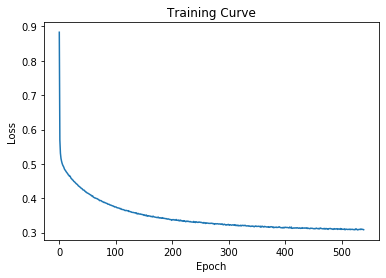

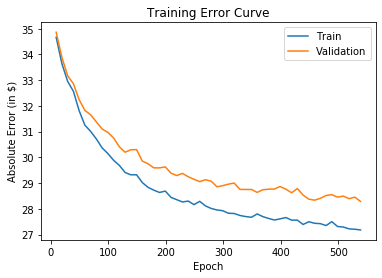

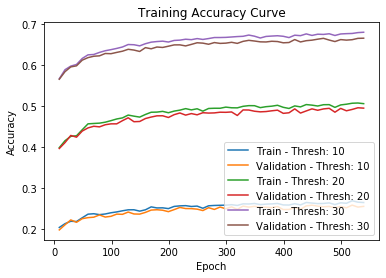

---[ITER 10] loss: 0.297386  time: 2.536
---[ITER 20] loss: 0.306702  time: 2.538
---[ITER 30] loss: 0.319789  time: 2.567
---[ITER 40] loss: 0.314030  time: 2.512
---[ITER 50] loss: 0.310491  time: 2.568
---[ITER 60] loss: 0.305551  time: 2.569
---[ITER 70] loss: 0.313806  time: 2.548
---[ITER 80] loss: 0.306337  time: 2.517
---[ITER 90] loss: 0.298792  time: 2.642
---[ITER 100] loss: 0.303355  time: 2.517
---[ITER 110] loss: 0.306842  time: 2.514
---[ITER 120] loss: 0.302729  time: 2.514
---[ITER 130] loss: 0.311312  time: 2.648
---[ITER 140] loss: 0.304889  time: 2.571
---[ITER 150] loss: 0.311385  time: 2.538
---[ITER 160] loss: 0.308889  time: 2.544
[EPOCH 541] loss: 0.307829  time: 42.828
---[ITER 10] loss: 0.313577  time: 2.536
---[ITER 20] loss: 0.305632  time: 2.542
---[ITER 30] loss: 0.312730  time: 2.522
---[ITER 40] loss: 0.298387  time: 2.528
---[ITER 50] loss: 0.314413  time: 2.535
---[ITER 60] loss: 0.318977  time: 2.560
---[ITER 70] loss: 0.301337  time: 2.525
---[ITER 

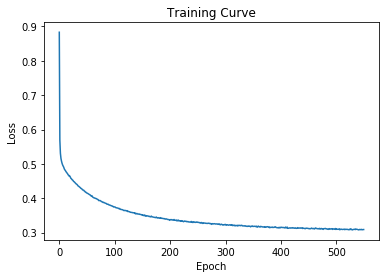

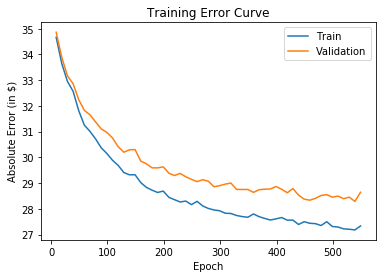

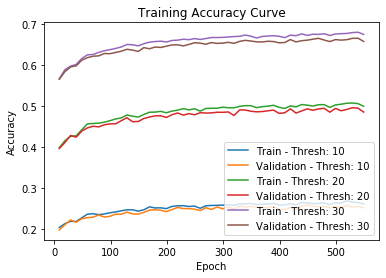

---[ITER 10] loss: 0.302377  time: 2.520
---[ITER 20] loss: 0.306512  time: 2.531
---[ITER 30] loss: 0.284279  time: 2.540
---[ITER 40] loss: 0.310568  time: 2.523
---[ITER 50] loss: 0.304527  time: 2.506
---[ITER 60] loss: 0.308620  time: 2.514
---[ITER 70] loss: 0.319930  time: 2.524
---[ITER 80] loss: 0.313407  time: 2.520
---[ITER 90] loss: 0.308598  time: 2.508
---[ITER 100] loss: 0.304414  time: 2.541
---[ITER 110] loss: 0.317164  time: 2.557
---[ITER 120] loss: 0.309720  time: 2.574
---[ITER 130] loss: 0.302863  time: 2.562
---[ITER 140] loss: 0.305058  time: 2.554
---[ITER 150] loss: 0.308882  time: 2.508
---[ITER 160] loss: 0.314337  time: 2.641
[EPOCH 551] loss: 0.307874  time: 42.574
---[ITER 10] loss: 0.306393  time: 2.623
---[ITER 20] loss: 0.320710  time: 2.543
---[ITER 30] loss: 0.306175  time: 2.535
---[ITER 40] loss: 0.308424  time: 2.550
---[ITER 50] loss: 0.309967  time: 2.525
---[ITER 60] loss: 0.313185  time: 2.488
---[ITER 70] loss: 0.315133  time: 2.511
---[ITER 

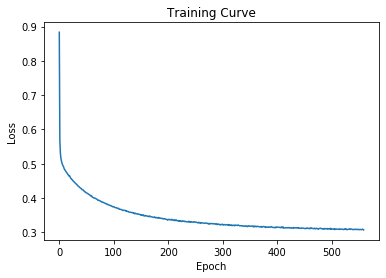

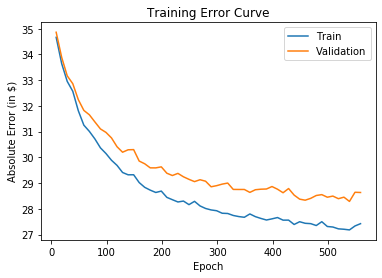

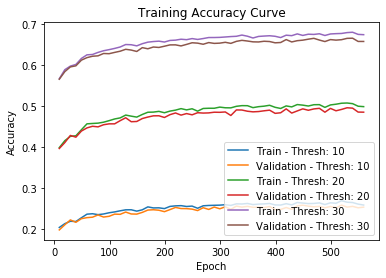

---[ITER 10] loss: 0.308602  time: 2.537
---[ITER 20] loss: 0.309383  time: 2.500
---[ITER 30] loss: 0.311298  time: 2.554
---[ITER 40] loss: 0.305913  time: 2.526
---[ITER 50] loss: 0.303726  time: 2.531
---[ITER 60] loss: 0.310213  time: 2.520
---[ITER 70] loss: 0.304462  time: 2.535
---[ITER 80] loss: 0.304217  time: 2.536
---[ITER 90] loss: 0.302064  time: 2.511
---[ITER 100] loss: 0.314864  time: 2.504
---[ITER 110] loss: 0.323357  time: 2.477
---[ITER 120] loss: 0.303431  time: 2.518
---[ITER 130] loss: 0.321677  time: 2.516
---[ITER 140] loss: 0.317255  time: 2.543
---[ITER 150] loss: 0.299838  time: 2.513
---[ITER 160] loss: 0.312963  time: 2.531
[EPOCH 561] loss: 0.309032  time: 42.309
---[ITER 10] loss: 0.301621  time: 2.589
---[ITER 20] loss: 0.311584  time: 2.581
---[ITER 30] loss: 0.306557  time: 2.559
---[ITER 40] loss: 0.297833  time: 2.553
---[ITER 50] loss: 0.315079  time: 2.755
---[ITER 60] loss: 0.303794  time: 2.638
---[ITER 70] loss: 0.316682  time: 2.516
---[ITER 

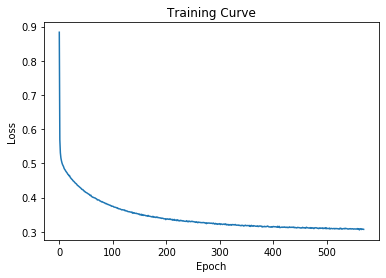

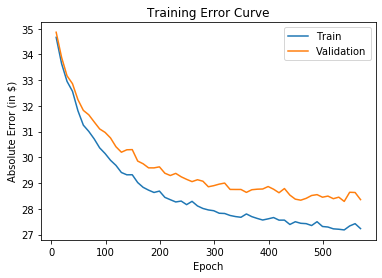

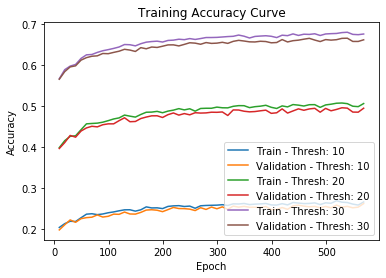

---[ITER 10] loss: 0.310591  time: 2.551
---[ITER 20] loss: 0.309983  time: 2.573
---[ITER 30] loss: 0.306296  time: 2.590
---[ITER 40] loss: 0.308052  time: 2.513
---[ITER 50] loss: 0.301318  time: 2.663
---[ITER 60] loss: 0.293957  time: 2.501
---[ITER 70] loss: 0.305293  time: 2.583
---[ITER 80] loss: 0.316829  time: 2.552
---[ITER 90] loss: 0.301113  time: 2.516
---[ITER 100] loss: 0.324295  time: 2.476
---[ITER 110] loss: 0.307174  time: 2.496
---[ITER 120] loss: 0.310653  time: 2.487
---[ITER 130] loss: 0.305651  time: 2.528
---[ITER 140] loss: 0.301724  time: 2.531
---[ITER 150] loss: 0.304294  time: 2.502
---[ITER 160] loss: 0.317677  time: 2.510
[EPOCH 571] loss: 0.308067  time: 42.518
---[ITER 10] loss: 0.317191  time: 2.545
---[ITER 20] loss: 0.301148  time: 2.534
---[ITER 30] loss: 0.309516  time: 2.485
---[ITER 40] loss: 0.300268  time: 2.514
---[ITER 50] loss: 0.309337  time: 2.510
---[ITER 60] loss: 0.299478  time: 2.513
---[ITER 70] loss: 0.291776  time: 2.625
---[ITER 

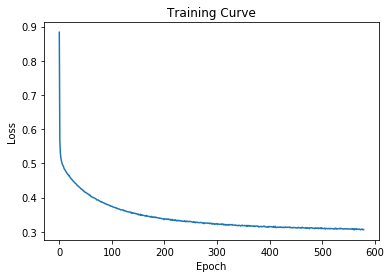

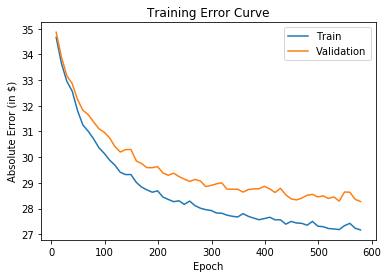

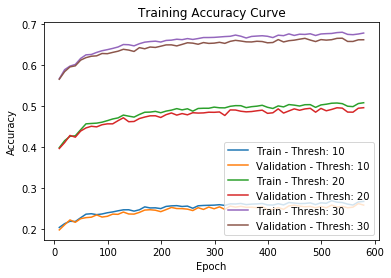

---[ITER 10] loss: 0.326101  time: 7.099
---[ITER 20] loss: 0.303238  time: 3.457
---[ITER 30] loss: 0.307628  time: 3.482
---[ITER 40] loss: 0.300477  time: 3.464
---[ITER 50] loss: 0.314152  time: 3.439
---[ITER 60] loss: 0.298105  time: 4.018
---[ITER 70] loss: 0.312601  time: 3.449
---[ITER 80] loss: 0.301943  time: 3.406
---[ITER 90] loss: 0.296179  time: 3.092
---[ITER 100] loss: 0.313484  time: 2.909
---[ITER 110] loss: 0.316274  time: 3.320
---[ITER 120] loss: 0.305585  time: 3.062
---[ITER 130] loss: 0.294954  time: 2.893
---[ITER 140] loss: 0.304639  time: 2.864
---[ITER 150] loss: 0.315156  time: 3.126
---[ITER 160] loss: 0.305185  time: 3.024
[EPOCH 581] loss: 0.307234  time: 58.387
---[ITER 10] loss: 0.312025  time: 2.728
---[ITER 20] loss: 0.299793  time: 2.751
---[ITER 30] loss: 0.306648  time: 2.957
---[ITER 40] loss: 0.309068  time: 3.142
---[ITER 50] loss: 0.310684  time: 3.425
---[ITER 60] loss: 0.308073  time: 3.579
---[ITER 70] loss: 0.306645  time: 3.040
---[ITER 

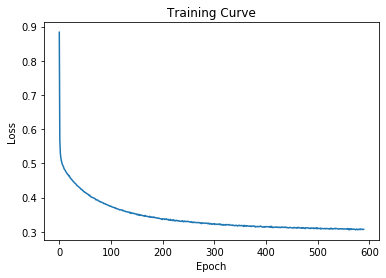

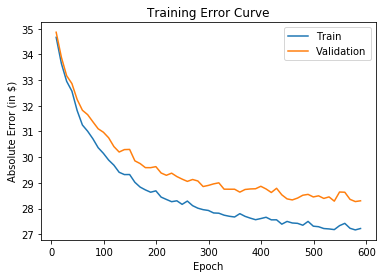

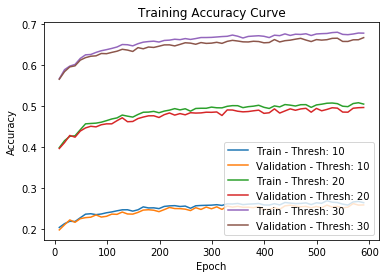

---[ITER 10] loss: 0.312835  time: 2.846
---[ITER 20] loss: 0.307483  time: 2.796
---[ITER 30] loss: 0.314925  time: 2.788
---[ITER 40] loss: 0.308626  time: 2.818
---[ITER 50] loss: 0.309058  time: 2.788
---[ITER 60] loss: 0.301849  time: 3.061
---[ITER 70] loss: 0.315790  time: 2.771
---[ITER 80] loss: 0.300972  time: 2.812
---[ITER 90] loss: 0.299999  time: 2.783
---[ITER 100] loss: 0.304492  time: 2.815
---[ITER 110] loss: 0.303498  time: 2.810
---[ITER 120] loss: 0.305576  time: 2.812
---[ITER 130] loss: 0.300904  time: 3.065
---[ITER 140] loss: 0.305584  time: 2.801
---[ITER 150] loss: 0.315081  time: 2.687
---[ITER 160] loss: 0.311830  time: 2.786
[EPOCH 591] loss: 0.308042  time: 47.411
---[ITER 10] loss: 0.309150  time: 2.826
---[ITER 20] loss: 0.311354  time: 2.845
---[ITER 30] loss: 0.299660  time: 2.785
---[ITER 40] loss: 0.297328  time: 2.874
---[ITER 50] loss: 0.313241  time: 3.248
---[ITER 60] loss: 0.297211  time: 2.764
---[ITER 70] loss: 0.303949  time: 2.782
---[ITER 

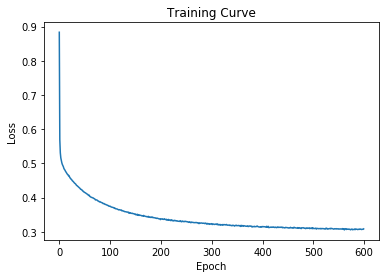

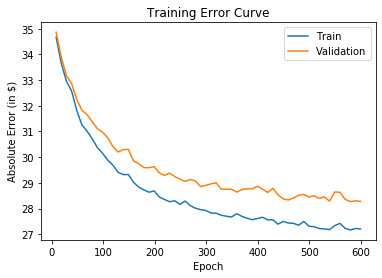

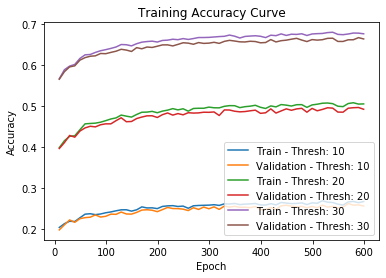

---[ITER 10] loss: 0.291309  time: 2.740
---[ITER 20] loss: 0.323146  time: 2.806
---[ITER 30] loss: 0.310979  time: 2.828
---[ITER 40] loss: 0.300718  time: 2.789
---[ITER 50] loss: 0.300292  time: 2.737
---[ITER 60] loss: 0.304235  time: 2.756
---[ITER 70] loss: 0.314045  time: 2.723
---[ITER 80] loss: 0.310202  time: 2.769
---[ITER 90] loss: 0.296178  time: 2.786
---[ITER 100] loss: 0.302140  time: 2.771
---[ITER 110] loss: 0.294717  time: 2.762
---[ITER 120] loss: 0.310607  time: 2.782
---[ITER 130] loss: 0.302784  time: 2.785
---[ITER 140] loss: 0.315777  time: 2.779
---[ITER 150] loss: 0.309964  time: 2.742
---[ITER 160] loss: 0.315059  time: 2.769
[EPOCH 601] loss: 0.306263  time: 46.486
---[ITER 10] loss: 0.308420  time: 2.822
---[ITER 20] loss: 0.314805  time: 2.862
---[ITER 30] loss: 0.307090  time: 2.786
---[ITER 40] loss: 0.301236  time: 2.879
---[ITER 50] loss: 0.314761  time: 2.840
---[ITER 60] loss: 0.313624  time: 2.805
---[ITER 70] loss: 0.308465  time: 2.822
---[ITER 

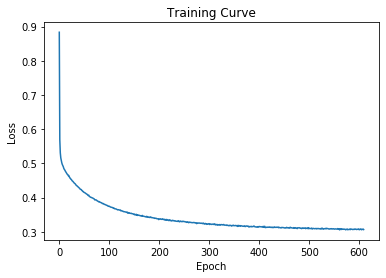

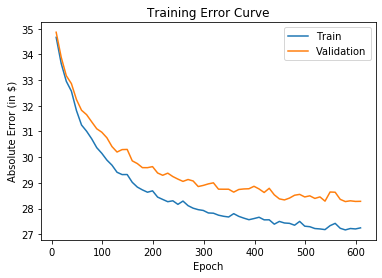

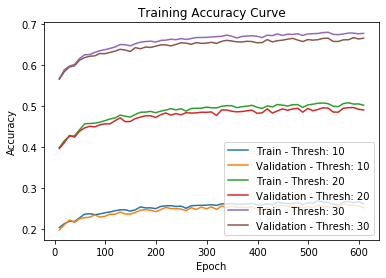

---[ITER 10] loss: 0.293407  time: 2.752
---[ITER 20] loss: 0.321060  time: 2.811
---[ITER 30] loss: 0.307832  time: 2.836
---[ITER 40] loss: 0.308895  time: 2.762
---[ITER 50] loss: 0.307108  time: 2.721
---[ITER 60] loss: 0.307498  time: 2.809
---[ITER 70] loss: 0.287116  time: 2.798
---[ITER 80] loss: 0.316953  time: 2.781
---[ITER 90] loss: 0.308768  time: 2.803
---[ITER 100] loss: 0.307167  time: 2.796
---[ITER 110] loss: 0.304010  time: 2.769
---[ITER 120] loss: 0.295075  time: 2.944
---[ITER 130] loss: 0.310100  time: 2.756
---[ITER 140] loss: 0.310285  time: 2.783
---[ITER 150] loss: 0.313478  time: 2.765
---[ITER 160] loss: 0.296183  time: 2.754
[EPOCH 611] loss: 0.305738  time: 46.787
---[ITER 10] loss: 0.294033  time: 2.848
---[ITER 20] loss: 0.309749  time: 2.812
---[ITER 30] loss: 0.305598  time: 2.923
---[ITER 40] loss: 0.302599  time: 2.768
---[ITER 50] loss: 0.311339  time: 2.732
---[ITER 60] loss: 0.299596  time: 2.780
---[ITER 70] loss: 0.302314  time: 2.830
---[ITER 

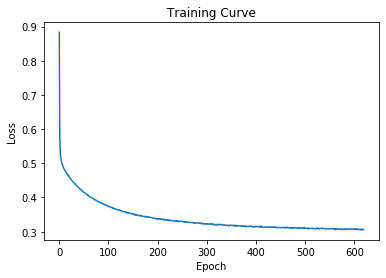

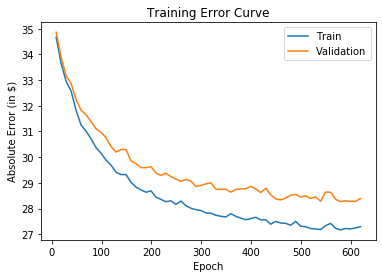

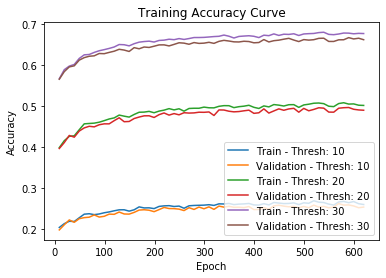

---[ITER 10] loss: 0.310049  time: 2.945
---[ITER 20] loss: 0.295734  time: 2.795
---[ITER 30] loss: 0.315748  time: 2.767
---[ITER 40] loss: 0.305970  time: 2.778
---[ITER 50] loss: 0.297511  time: 2.758
---[ITER 60] loss: 0.302027  time: 2.900
---[ITER 70] loss: 0.311203  time: 2.747
---[ITER 80] loss: 0.312239  time: 2.799
---[ITER 90] loss: 0.308890  time: 2.771
---[ITER 100] loss: 0.310938  time: 2.787
---[ITER 110] loss: 0.314748  time: 2.741
---[ITER 120] loss: 0.310192  time: 2.754
---[ITER 130] loss: 0.304787  time: 2.805
---[ITER 140] loss: 0.307646  time: 2.822
---[ITER 150] loss: 0.297575  time: 2.747
---[ITER 160] loss: 0.300229  time: 2.770
[EPOCH 621] loss: 0.306487  time: 46.874
---[ITER 10] loss: 0.310072  time: 2.786
---[ITER 20] loss: 0.300909  time: 2.870
---[ITER 30] loss: 0.304343  time: 2.872
---[ITER 40] loss: 0.307563  time: 2.823
---[ITER 50] loss: 0.308087  time: 2.771
---[ITER 60] loss: 0.312820  time: 2.929
---[ITER 70] loss: 0.315159  time: 2.778
---[ITER 

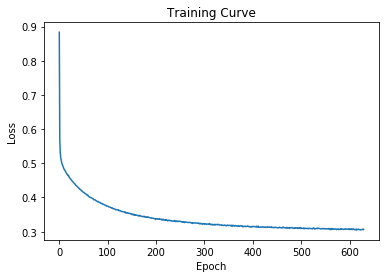

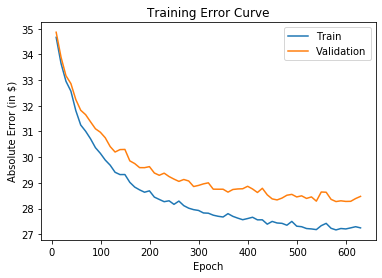

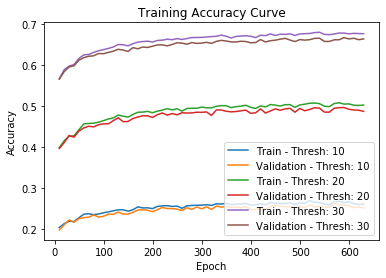

---[ITER 10] loss: 0.292415  time: 2.862
---[ITER 20] loss: 0.312845  time: 2.792
---[ITER 30] loss: 0.306303  time: 2.814
---[ITER 40] loss: 0.298589  time: 2.773
---[ITER 50] loss: 0.299630  time: 2.771
---[ITER 60] loss: 0.311797  time: 2.802
---[ITER 70] loss: 0.315032  time: 2.737
---[ITER 80] loss: 0.307088  time: 2.843
---[ITER 90] loss: 0.305779  time: 2.850
---[ITER 100] loss: 0.303804  time: 2.787
---[ITER 110] loss: 0.308323  time: 2.914
---[ITER 120] loss: 0.308237  time: 2.855
---[ITER 130] loss: 0.302125  time: 2.806
---[ITER 140] loss: 0.310103  time: 2.768
---[ITER 150] loss: 0.313131  time: 2.745
---[ITER 160] loss: 0.305012  time: 2.800
[EPOCH 631] loss: 0.306352  time: 47.048
---[ITER 10] loss: 0.302490  time: 2.778
---[ITER 20] loss: 0.304023  time: 2.783
---[ITER 30] loss: 0.318941  time: 2.733
---[ITER 40] loss: 0.307837  time: 2.750
---[ITER 50] loss: 0.305516  time: 2.766
---[ITER 60] loss: 0.318998  time: 2.780
---[ITER 70] loss: 0.305086  time: 2.718
---[ITER 

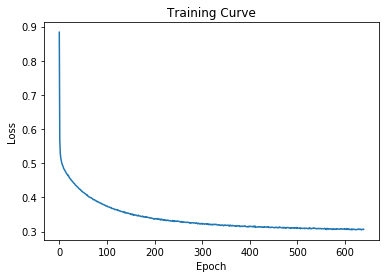

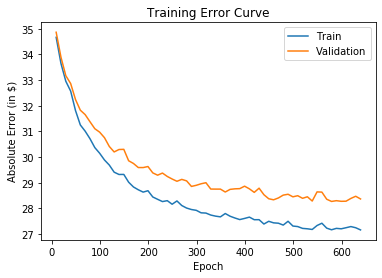

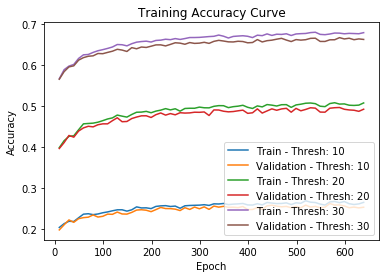

---[ITER 10] loss: 0.298917  time: 2.838
---[ITER 20] loss: 0.304817  time: 2.781
---[ITER 30] loss: 0.299304  time: 2.828
---[ITER 40] loss: 0.302189  time: 2.789
---[ITER 50] loss: 0.314854  time: 2.772
---[ITER 60] loss: 0.301954  time: 2.772
---[ITER 70] loss: 0.305122  time: 2.748
---[ITER 80] loss: 0.304447  time: 2.805
---[ITER 90] loss: 0.305755  time: 2.983
---[ITER 100] loss: 0.315773  time: 2.825
---[ITER 110] loss: 0.315857  time: 2.769
---[ITER 120] loss: 0.300253  time: 3.037
---[ITER 130] loss: 0.313042  time: 2.738
---[ITER 140] loss: 0.305859  time: 2.802
---[ITER 150] loss: 0.305586  time: 2.775
---[ITER 160] loss: 0.298112  time: 2.773
[EPOCH 641] loss: 0.306436  time: 47.168
---[ITER 10] loss: 0.313462  time: 2.809
---[ITER 20] loss: 0.308879  time: 2.827
---[ITER 30] loss: 0.300469  time: 2.801
---[ITER 40] loss: 0.303842  time: 2.799
---[ITER 50] loss: 0.298826  time: 3.249
---[ITER 60] loss: 0.303164  time: 2.811
---[ITER 70] loss: 0.297071  time: 2.811
---[ITER 

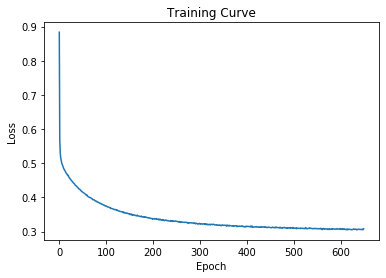

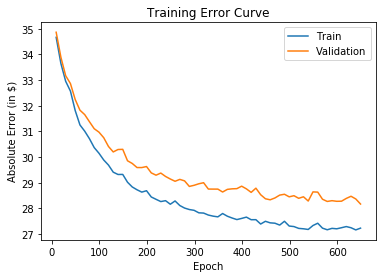

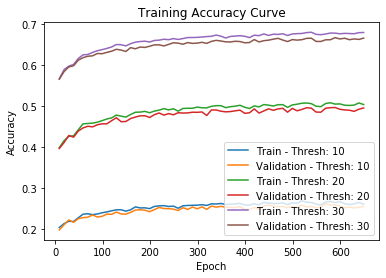

---[ITER 10] loss: 0.308700  time: 2.759
---[ITER 20] loss: 0.312474  time: 2.739
---[ITER 30] loss: 0.305840  time: 2.815
---[ITER 40] loss: 0.309477  time: 2.783
---[ITER 50] loss: 0.308055  time: 2.825
---[ITER 60] loss: 0.309448  time: 2.845
---[ITER 70] loss: 0.296236  time: 2.905
---[ITER 80] loss: 0.308039  time: 2.997
---[ITER 90] loss: 0.301682  time: 2.819
---[ITER 100] loss: 0.310195  time: 2.950
---[ITER 110] loss: 0.305506  time: 2.840
---[ITER 120] loss: 0.296128  time: 2.811
---[ITER 130] loss: 0.312048  time: 2.776
---[ITER 140] loss: 0.293399  time: 2.794
---[ITER 150] loss: 0.311293  time: 2.733
---[ITER 160] loss: 0.312990  time: 2.782
[EPOCH 651] loss: 0.306209  time: 47.288
---[ITER 10] loss: 0.319019  time: 2.866
---[ITER 20] loss: 0.317191  time: 2.833
---[ITER 30] loss: 0.308062  time: 2.739
---[ITER 40] loss: 0.300760  time: 2.768
---[ITER 50] loss: 0.304505  time: 2.781
---[ITER 60] loss: 0.299656  time: 2.823
---[ITER 70] loss: 0.304464  time: 2.797
---[ITER 

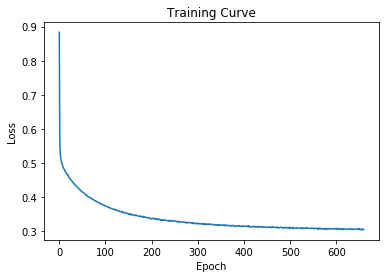

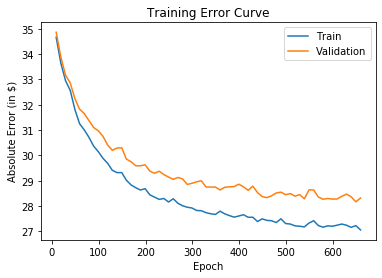

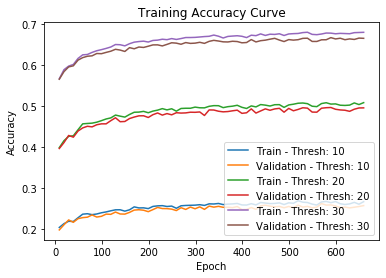

---[ITER 10] loss: 0.302261  time: 2.733
---[ITER 20] loss: 0.298553  time: 2.805
---[ITER 30] loss: 0.308775  time: 2.841
---[ITER 40] loss: 0.315540  time: 2.793
---[ITER 50] loss: 0.300482  time: 2.780
---[ITER 60] loss: 0.309344  time: 2.766
---[ITER 70] loss: 0.313847  time: 2.763
---[ITER 80] loss: 0.310859  time: 2.780
---[ITER 90] loss: 0.295440  time: 2.947
---[ITER 100] loss: 0.312448  time: 3.138
---[ITER 110] loss: 0.302357  time: 2.807
---[ITER 120] loss: 0.309691  time: 2.747
---[ITER 130] loss: 0.298416  time: 2.746
---[ITER 140] loss: 0.303555  time: 2.931
---[ITER 150] loss: 0.307204  time: 2.831
---[ITER 160] loss: 0.305897  time: 2.864
[EPOCH 661] loss: 0.305718  time: 47.454
---[ITER 10] loss: 0.308006  time: 2.825
---[ITER 20] loss: 0.314487  time: 2.811
---[ITER 30] loss: 0.303564  time: 2.921
---[ITER 40] loss: 0.302546  time: 2.765
---[ITER 50] loss: 0.308381  time: 2.785
---[ITER 60] loss: 0.302165  time: 2.809
---[ITER 70] loss: 0.300021  time: 2.783
---[ITER 

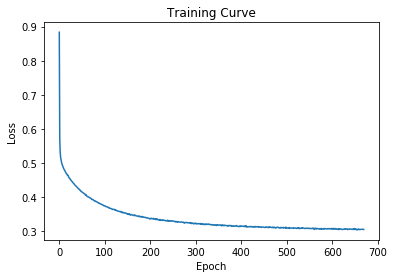

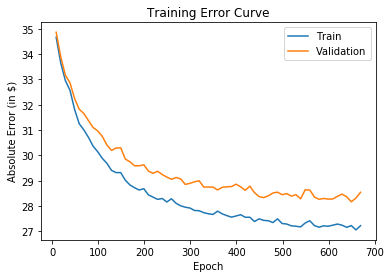

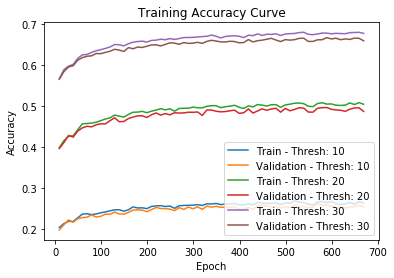

---[ITER 10] loss: 0.306256  time: 2.749
---[ITER 20] loss: 0.308951  time: 2.744
---[ITER 30] loss: 0.309676  time: 2.811
---[ITER 40] loss: 0.294096  time: 2.807
---[ITER 50] loss: 0.300741  time: 2.862
---[ITER 60] loss: 0.306926  time: 2.824
---[ITER 70] loss: 0.306145  time: 2.772
---[ITER 80] loss: 0.306284  time: 2.957
---[ITER 90] loss: 0.299021  time: 2.734
---[ITER 100] loss: 0.294029  time: 2.729
---[ITER 110] loss: 0.300424  time: 2.768
---[ITER 120] loss: 0.294834  time: 2.755
---[ITER 130] loss: 0.307253  time: 2.727
---[ITER 140] loss: 0.305449  time: 2.779
---[ITER 150] loss: 0.309455  time: 2.776
---[ITER 160] loss: 0.292574  time: 2.725
[EPOCH 671] loss: 0.303896  time: 46.673
---[ITER 10] loss: 0.298157  time: 2.795
---[ITER 20] loss: 0.304876  time: 2.755
---[ITER 30] loss: 0.300514  time: 2.756
---[ITER 40] loss: 0.314005  time: 2.763
---[ITER 50] loss: 0.301089  time: 2.744
---[ITER 60] loss: 0.304194  time: 2.938
---[ITER 70] loss: 0.318321  time: 2.776
---[ITER 

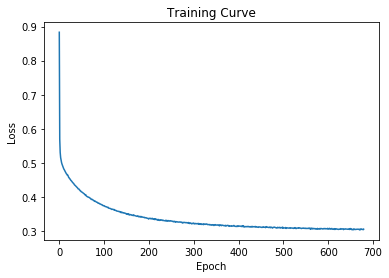

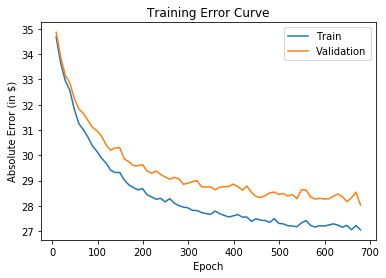

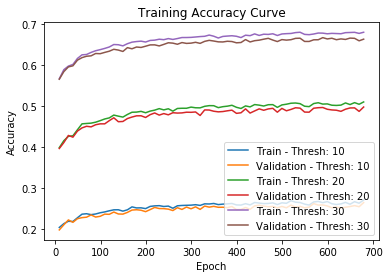

---[ITER 10] loss: 0.315392  time: 2.771
---[ITER 20] loss: 0.293540  time: 2.793
---[ITER 30] loss: 0.305394  time: 2.739
---[ITER 40] loss: 0.319914  time: 2.755
---[ITER 50] loss: 0.308008  time: 2.697
---[ITER 60] loss: 0.304331  time: 2.724
---[ITER 70] loss: 0.306584  time: 2.764
---[ITER 80] loss: 0.301016  time: 2.786
---[ITER 90] loss: 0.297518  time: 3.036
---[ITER 100] loss: 0.291137  time: 2.745
---[ITER 110] loss: 0.313729  time: 2.735
---[ITER 120] loss: 0.303400  time: 2.854
---[ITER 130] loss: 0.316319  time: 2.785
---[ITER 140] loss: 0.314783  time: 2.735
---[ITER 150] loss: 0.299391  time: 2.798
---[ITER 160] loss: 0.312113  time: 2.823
[EPOCH 681] loss: 0.306210  time: 46.751
---[ITER 10] loss: 0.296689  time: 2.764
---[ITER 20] loss: 0.296498  time: 3.003
---[ITER 30] loss: 0.304739  time: 2.762
---[ITER 40] loss: 0.290752  time: 2.778
---[ITER 50] loss: 0.306925  time: 2.734
---[ITER 60] loss: 0.300914  time: 2.758
---[ITER 70] loss: 0.300385  time: 2.763
---[ITER 

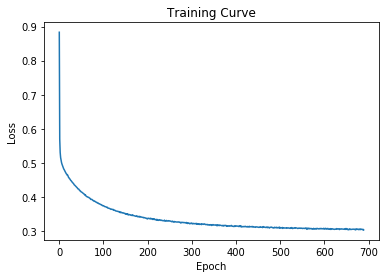

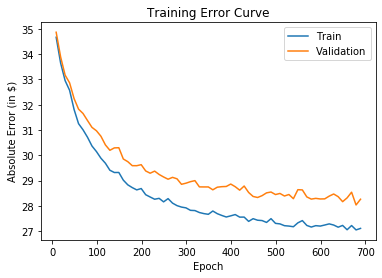

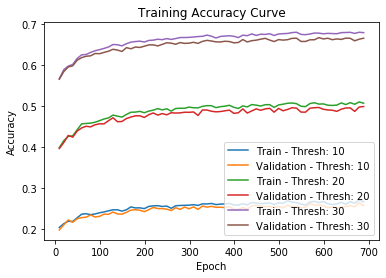

---[ITER 10] loss: 0.309090  time: 2.738
---[ITER 20] loss: 0.298158  time: 2.787
---[ITER 30] loss: 0.311022  time: 2.795
---[ITER 40] loss: 0.291217  time: 2.830
---[ITER 50] loss: 0.305967  time: 2.782
---[ITER 60] loss: 0.311582  time: 2.769
---[ITER 70] loss: 0.305353  time: 2.818
---[ITER 80] loss: 0.301794  time: 2.970
---[ITER 90] loss: 0.297289  time: 2.794
---[ITER 100] loss: 0.315737  time: 2.749
---[ITER 110] loss: 0.299687  time: 2.784
---[ITER 120] loss: 0.300288  time: 2.758
---[ITER 130] loss: 0.303471  time: 2.766
---[ITER 140] loss: 0.302912  time: 2.826
---[ITER 150] loss: 0.311055  time: 2.734
---[ITER 160] loss: 0.309675  time: 2.800
[EPOCH 691] loss: 0.304629  time: 46.849
---[ITER 10] loss: 0.303915  time: 2.746
---[ITER 20] loss: 0.316975  time: 2.809
---[ITER 30] loss: 0.292316  time: 2.778
---[ITER 40] loss: 0.319535  time: 2.746
---[ITER 50] loss: 0.319190  time: 2.755
---[ITER 60] loss: 0.308077  time: 2.766
---[ITER 70] loss: 0.308458  time: 2.757
---[ITER 

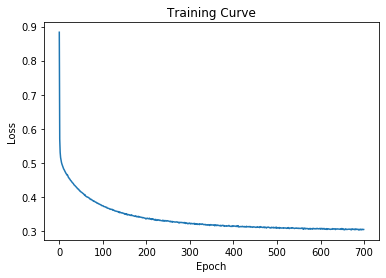

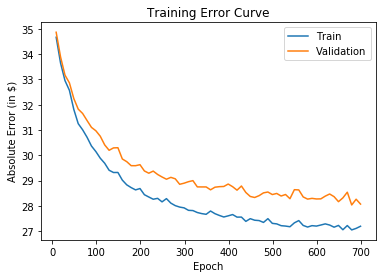

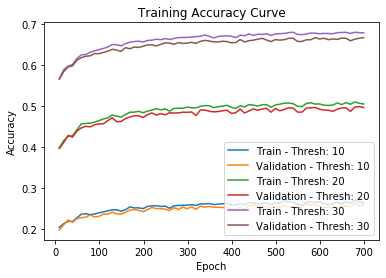

---[ITER 10] loss: 0.298508  time: 2.745
---[ITER 20] loss: 0.307384  time: 2.872
---[ITER 30] loss: 0.297861  time: 2.795
---[ITER 40] loss: 0.312163  time: 2.807
---[ITER 50] loss: 0.311591  time: 2.743
---[ITER 60] loss: 0.312816  time: 2.772
---[ITER 70] loss: 0.314960  time: 2.800
---[ITER 80] loss: 0.296505  time: 2.777
---[ITER 90] loss: 0.303847  time: 2.734
---[ITER 100] loss: 0.302768  time: 2.721
---[ITER 110] loss: 0.303115  time: 2.805
---[ITER 120] loss: 0.316740  time: 2.901
---[ITER 130] loss: 0.320083  time: 2.775
---[ITER 140] loss: 0.300125  time: 2.866
---[ITER 150] loss: 0.302554  time: 2.837
---[ITER 160] loss: 0.292250  time: 2.785
[EPOCH 701] loss: 0.305036  time: 46.892
---[ITER 10] loss: 0.301166  time: 3.010
---[ITER 20] loss: 0.319532  time: 2.784
---[ITER 30] loss: 0.303569  time: 2.793
---[ITER 40] loss: 0.310534  time: 2.788
---[ITER 50] loss: 0.308171  time: 2.734
---[ITER 60] loss: 0.309875  time: 2.776
---[ITER 70] loss: 0.308860  time: 2.785
---[ITER 

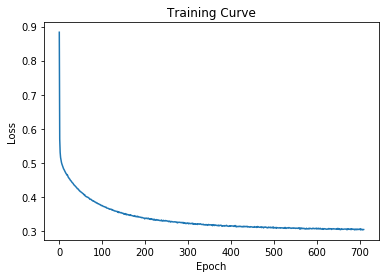

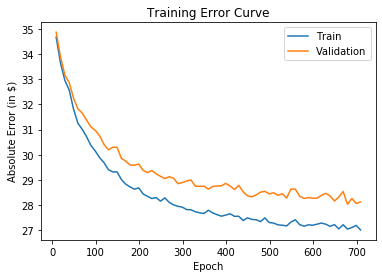

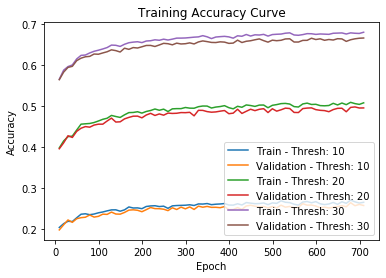

---[ITER 10] loss: 0.307223  time: 2.778
---[ITER 20] loss: 0.295393  time: 2.852
---[ITER 30] loss: 0.297506  time: 2.828
---[ITER 40] loss: 0.312492  time: 2.802
---[ITER 50] loss: 0.306545  time: 2.819
---[ITER 60] loss: 0.309478  time: 2.913
---[ITER 70] loss: 0.305274  time: 2.795
---[ITER 80] loss: 0.311466  time: 2.761
---[ITER 90] loss: 0.301539  time: 2.804
---[ITER 100] loss: 0.301456  time: 2.915
---[ITER 110] loss: 0.300285  time: 2.956
---[ITER 120] loss: 0.298732  time: 2.766
---[ITER 130] loss: 0.311235  time: 2.791
---[ITER 140] loss: 0.309467  time: 2.808
---[ITER 150] loss: 0.311167  time: 2.760
---[ITER 160] loss: 0.309313  time: 2.771
[EPOCH 711] loss: 0.305463  time: 47.242
---[ITER 10] loss: 0.307093  time: 2.736
---[ITER 20] loss: 0.309416  time: 2.771
---[ITER 30] loss: 0.294199  time: 2.770
---[ITER 40] loss: 0.304356  time: 2.810
---[ITER 50] loss: 0.288507  time: 2.776
---[ITER 60] loss: 0.310357  time: 2.739
---[ITER 70] loss: 0.287521  time: 2.841
---[ITER 

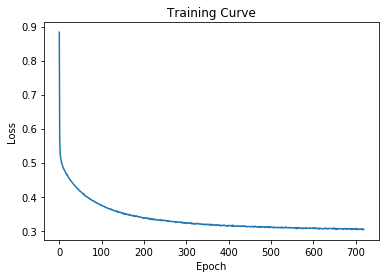

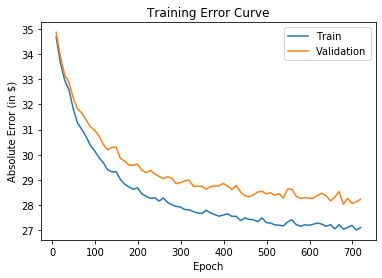

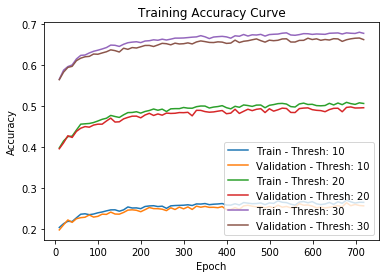

---[ITER 10] loss: 0.296718  time: 2.780
---[ITER 20] loss: 0.308714  time: 2.841
---[ITER 30] loss: 0.306461  time: 2.800
---[ITER 40] loss: 0.306758  time: 2.777
---[ITER 50] loss: 0.305374  time: 2.789
---[ITER 60] loss: 0.301894  time: 2.741
---[ITER 70] loss: 0.297302  time: 2.811
---[ITER 80] loss: 0.308589  time: 2.786
---[ITER 90] loss: 0.305326  time: 2.731
---[ITER 100] loss: 0.295094  time: 2.810
---[ITER 110] loss: 0.314042  time: 2.823
---[ITER 120] loss: 0.307187  time: 2.849
---[ITER 130] loss: 0.301582  time: 2.878
---[ITER 140] loss: 0.302925  time: 2.858
---[ITER 150] loss: 0.304172  time: 2.762
---[ITER 160] loss: 0.293945  time: 2.920
[EPOCH 721] loss: 0.303585  time: 47.130
---[ITER 10] loss: 0.311911  time: 2.770
---[ITER 20] loss: 0.290169  time: 2.791
---[ITER 30] loss: 0.316844  time: 2.785
---[ITER 40] loss: 0.290502  time: 2.790
---[ITER 50] loss: 0.307962  time: 2.760
---[ITER 60] loss: 0.308986  time: 2.760
---[ITER 70] loss: 0.301804  time: 2.797
---[ITER 

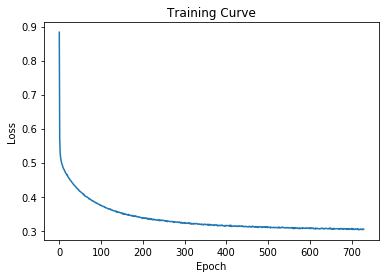

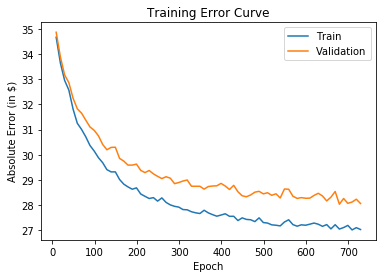

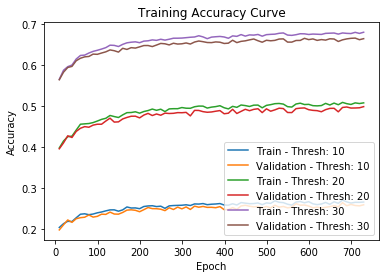

---[ITER 10] loss: 0.302579  time: 2.903
---[ITER 20] loss: 0.299874  time: 2.863
---[ITER 30] loss: 0.312378  time: 2.729
---[ITER 40] loss: 0.306324  time: 2.946
---[ITER 50] loss: 0.308440  time: 2.795
---[ITER 60] loss: 0.305763  time: 2.796
---[ITER 70] loss: 0.292502  time: 2.794
---[ITER 80] loss: 0.312167  time: 2.743
---[ITER 90] loss: 0.293656  time: 2.722
---[ITER 100] loss: 0.315623  time: 2.826
---[ITER 110] loss: 0.295348  time: 2.808
---[ITER 120] loss: 0.313055  time: 2.870
---[ITER 130] loss: 0.312242  time: 2.833
---[ITER 140] loss: 0.304621  time: 2.718
---[ITER 150] loss: 0.302825  time: 2.869
---[ITER 160] loss: 0.304966  time: 2.753
[EPOCH 731] loss: 0.304748  time: 47.087
---[ITER 10] loss: 0.307471  time: 2.801
---[ITER 20] loss: 0.311860  time: 2.779
---[ITER 30] loss: 0.299559  time: 2.753
---[ITER 40] loss: 0.305730  time: 2.758
---[ITER 50] loss: 0.301753  time: 2.798
---[ITER 60] loss: 0.307041  time: 2.844
---[ITER 70] loss: 0.292207  time: 2.782
---[ITER 

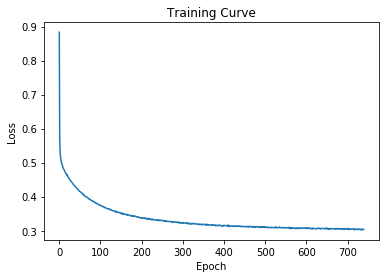

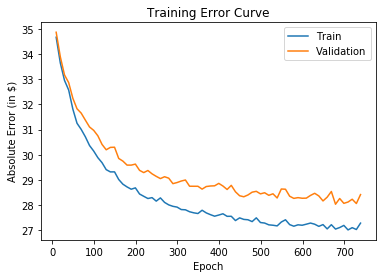

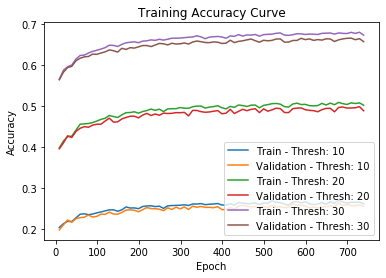

---[ITER 10] loss: 0.315319  time: 2.722
---[ITER 20] loss: 0.305889  time: 2.806
---[ITER 30] loss: 0.299667  time: 2.791
---[ITER 40] loss: 0.302213  time: 2.808
---[ITER 50] loss: 0.298140  time: 2.790
---[ITER 60] loss: 0.310692  time: 2.802
---[ITER 70] loss: 0.313292  time: 2.763
---[ITER 80] loss: 0.298929  time: 2.794
---[ITER 90] loss: 0.298515  time: 2.778
---[ITER 100] loss: 0.302260  time: 2.840
---[ITER 110] loss: 0.304624  time: 2.936
---[ITER 120] loss: 0.304437  time: 3.026
---[ITER 130] loss: 0.309370  time: 2.749
---[ITER 140] loss: 0.304154  time: 3.083
---[ITER 150] loss: 0.303518  time: 2.768
---[ITER 160] loss: 0.303086  time: 2.823
[EPOCH 741] loss: 0.304248  time: 47.437
---[ITER 10] loss: 0.303915  time: 2.761
---[ITER 20] loss: 0.289669  time: 2.794
---[ITER 30] loss: 0.299135  time: 2.737
---[ITER 40] loss: 0.291877  time: 2.804
---[ITER 50] loss: 0.292700  time: 2.770
---[ITER 60] loss: 0.295239  time: 2.766
---[ITER 70] loss: 0.303990  time: 2.752
---[ITER 

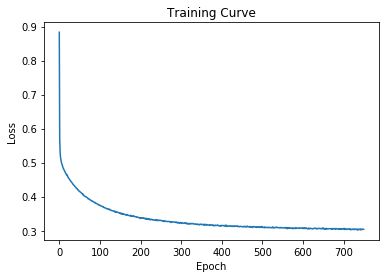

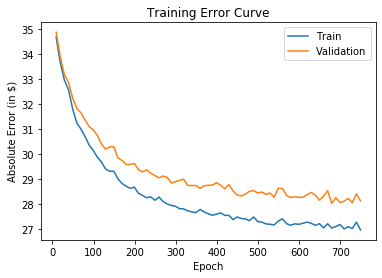

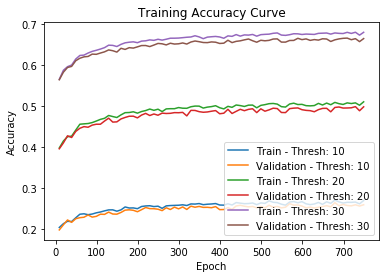

---[ITER 10] loss: 0.298684  time: 2.909
---[ITER 20] loss: 0.309792  time: 2.924
---[ITER 30] loss: 0.297574  time: 2.776
---[ITER 40] loss: 0.311384  time: 2.767
---[ITER 50] loss: 0.305209  time: 2.740
---[ITER 60] loss: 0.300360  time: 2.793
---[ITER 70] loss: 0.303134  time: 2.733
---[ITER 80] loss: 0.314866  time: 2.783
---[ITER 90] loss: 0.309554  time: 2.786
---[ITER 100] loss: 0.313382  time: 2.742
---[ITER 110] loss: 0.297723  time: 2.767
---[ITER 120] loss: 0.318721  time: 2.793
---[ITER 130] loss: 0.297618  time: 2.788
---[ITER 140] loss: 0.306406  time: 2.753
---[ITER 150] loss: 0.297288  time: 2.760
---[ITER 160] loss: 0.293072  time: 2.781
[EPOCH 751] loss: 0.304850  time: 46.773
---[ITER 10] loss: 0.303706  time: 2.808
---[ITER 20] loss: 0.316466  time: 2.845
---[ITER 30] loss: 0.290288  time: 2.844
---[ITER 40] loss: 0.303525  time: 2.776
---[ITER 50] loss: 0.297009  time: 2.741
---[ITER 60] loss: 0.316587  time: 2.879
---[ITER 70] loss: 0.297302  time: 2.846
---[ITER 

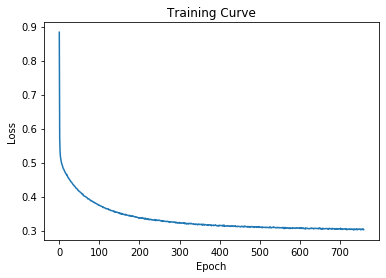

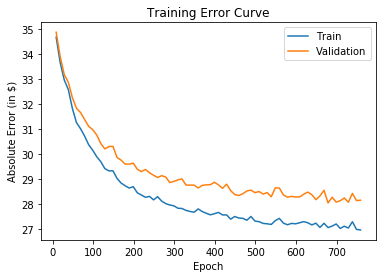

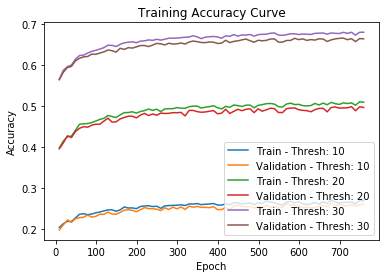

---[ITER 10] loss: 0.307306  time: 2.743
---[ITER 20] loss: 0.311528  time: 2.805
---[ITER 30] loss: 0.302516  time: 2.800
---[ITER 40] loss: 0.294832  time: 2.801
---[ITER 50] loss: 0.304392  time: 2.752
---[ITER 60] loss: 0.312873  time: 2.753
---[ITER 70] loss: 0.293653  time: 2.819
---[ITER 80] loss: 0.306705  time: 2.874
---[ITER 90] loss: 0.309426  time: 2.783
---[ITER 100] loss: 0.302077  time: 2.745
---[ITER 110] loss: 0.297236  time: 3.011
---[ITER 120] loss: 0.298066  time: 2.712
---[ITER 130] loss: 0.297622  time: 2.789
---[ITER 140] loss: 0.308119  time: 2.827
---[ITER 150] loss: 0.298460  time: 2.741
---[ITER 160] loss: 0.305967  time: 2.775
[EPOCH 761] loss: 0.302911  time: 46.895
---[ITER 10] loss: 0.296461  time: 2.731
---[ITER 20] loss: 0.306406  time: 2.754
---[ITER 30] loss: 0.304561  time: 2.803
---[ITER 40] loss: 0.306238  time: 2.725
---[ITER 50] loss: 0.303715  time: 2.718
---[ITER 60] loss: 0.293721  time: 2.774
---[ITER 70] loss: 0.305402  time: 2.812
---[ITER 

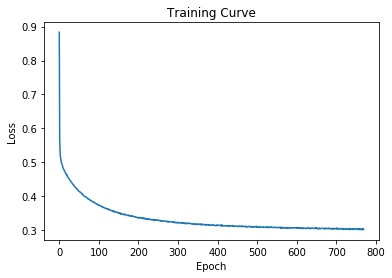

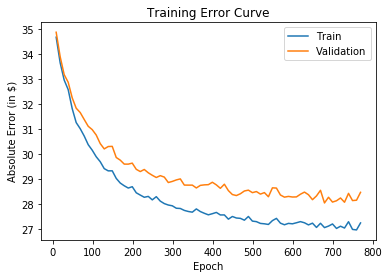

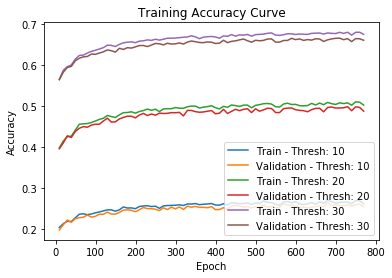

---[ITER 10] loss: 0.299236  time: 2.761
---[ITER 20] loss: 0.299095  time: 2.835
---[ITER 30] loss: 0.296576  time: 2.808
---[ITER 40] loss: 0.279362  time: 2.737
---[ITER 50] loss: 0.299609  time: 2.714
---[ITER 60] loss: 0.306437  time: 2.833
---[ITER 70] loss: 0.301711  time: 2.794
---[ITER 80] loss: 0.307382  time: 2.735
---[ITER 90] loss: 0.300989  time: 2.771
---[ITER 100] loss: 0.300774  time: 2.742
---[ITER 110] loss: 0.317236  time: 3.052
---[ITER 120] loss: 0.318219  time: 2.855
---[ITER 130] loss: 0.291025  time: 2.790
---[ITER 140] loss: 0.310733  time: 2.830
---[ITER 150] loss: 0.310718  time: 2.721
---[ITER 160] loss: 0.308843  time: 2.812
[EPOCH 771] loss: 0.302841  time: 46.951
---[ITER 10] loss: 0.303251  time: 2.825
---[ITER 20] loss: 0.288305  time: 2.874
---[ITER 30] loss: 0.298755  time: 2.796
---[ITER 40] loss: 0.296731  time: 2.986
---[ITER 50] loss: 0.304802  time: 2.781
---[ITER 60] loss: 0.299707  time: 2.747
---[ITER 70] loss: 0.313231  time: 2.741
---[ITER 

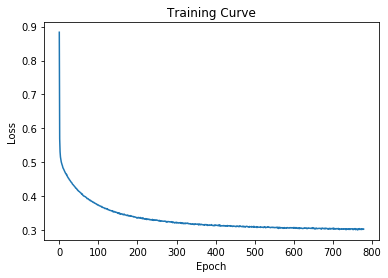

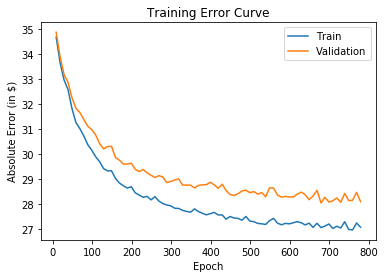

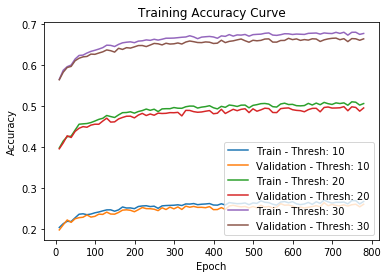

---[ITER 10] loss: 0.307482  time: 2.842
---[ITER 20] loss: 0.309489  time: 2.815
---[ITER 30] loss: 0.311484  time: 2.822
---[ITER 40] loss: 0.295134  time: 2.802
---[ITER 50] loss: 0.303640  time: 2.747
---[ITER 60] loss: 0.306334  time: 2.833
---[ITER 70] loss: 0.302541  time: 2.856
---[ITER 80] loss: 0.305124  time: 2.773
---[ITER 90] loss: 0.310892  time: 2.768
---[ITER 100] loss: 0.298258  time: 2.977
---[ITER 110] loss: 0.297914  time: 2.819
---[ITER 120] loss: 0.302191  time: 2.769
---[ITER 130] loss: 0.298187  time: 2.780
---[ITER 140] loss: 0.293800  time: 2.828
---[ITER 150] loss: 0.303735  time: 2.763
---[ITER 160] loss: 0.299343  time: 2.747
[EPOCH 781] loss: 0.302485  time: 47.088
---[ITER 10] loss: 0.301859  time: 2.812
---[ITER 20] loss: 0.302029  time: 2.780
---[ITER 30] loss: 0.307413  time: 2.797
---[ITER 40] loss: 0.307363  time: 2.779
---[ITER 50] loss: 0.307688  time: 2.721
---[ITER 60] loss: 0.310075  time: 2.763
---[ITER 70] loss: 0.283529  time: 2.785
---[ITER 

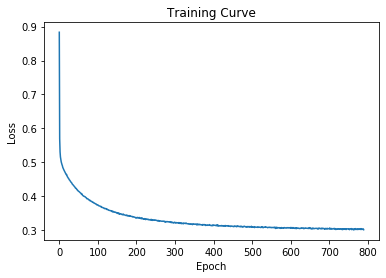

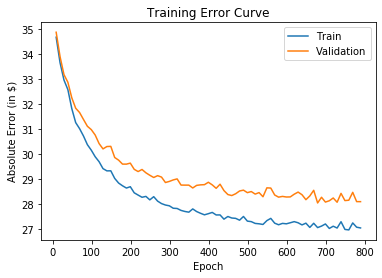

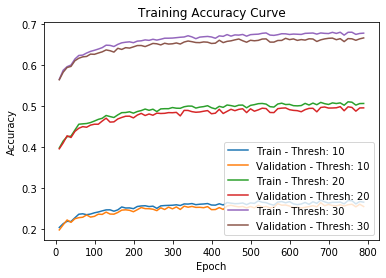

---[ITER 10] loss: 0.304120  time: 2.736
---[ITER 20] loss: 0.303148  time: 2.799
---[ITER 30] loss: 0.318352  time: 2.760
---[ITER 40] loss: 0.305553  time: 2.831
---[ITER 50] loss: 0.309366  time: 2.786
---[ITER 60] loss: 0.311306  time: 2.777
---[ITER 70] loss: 0.315903  time: 2.767
---[ITER 80] loss: 0.290586  time: 2.800
---[ITER 90] loss: 0.303450  time: 2.771
---[ITER 100] loss: 0.298458  time: 2.738
---[ITER 110] loss: 0.297199  time: 2.785
---[ITER 120] loss: 0.301407  time: 2.801
---[ITER 130] loss: 0.303616  time: 2.797
---[ITER 140] loss: 0.313187  time: 2.817
---[ITER 150] loss: 0.303751  time: 2.774
---[ITER 160] loss: 0.286758  time: 2.794
[EPOCH 791] loss: 0.303510  time: 46.757
---[ITER 10] loss: 0.310020  time: 2.814
---[ITER 20] loss: 0.291513  time: 2.797
---[ITER 30] loss: 0.309252  time: 2.954
---[ITER 40] loss: 0.301785  time: 2.783
---[ITER 50] loss: 0.299327  time: 2.761
---[ITER 60] loss: 0.304473  time: 2.778
---[ITER 70] loss: 0.303947  time: 2.789
---[ITER 

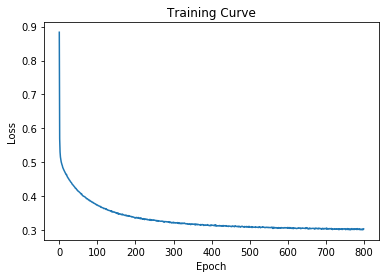

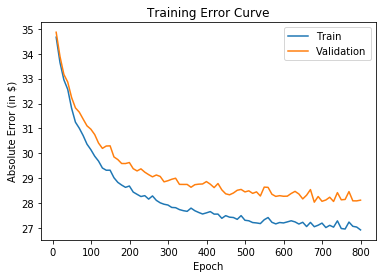

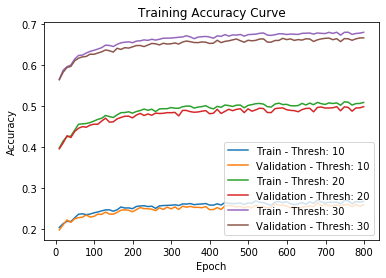

---[ITER 10] loss: 0.292419  time: 2.770
---[ITER 20] loss: 0.305679  time: 2.797
---[ITER 30] loss: 0.304870  time: 2.779
---[ITER 40] loss: 0.304303  time: 2.795
---[ITER 50] loss: 0.308357  time: 2.797
---[ITER 60] loss: 0.294491  time: 2.807
---[ITER 70] loss: 0.301728  time: 2.803
---[ITER 80] loss: 0.312426  time: 2.972
---[ITER 90] loss: 0.301343  time: 2.805
---[ITER 100] loss: 0.298747  time: 2.807
---[ITER 110] loss: 0.291830  time: 2.772
---[ITER 120] loss: 0.307525  time: 2.791
---[ITER 130] loss: 0.300654  time: 2.976
---[ITER 140] loss: 0.296915  time: 2.836
---[ITER 150] loss: 0.312445  time: 2.793
---[ITER 160] loss: 0.302056  time: 2.835
[EPOCH 801] loss: 0.302134  time: 47.262
---[ITER 10] loss: 0.310531  time: 2.764
---[ITER 20] loss: 0.289252  time: 2.759
---[ITER 30] loss: 0.300821  time: 2.797
---[ITER 40] loss: 0.300705  time: 2.761
---[ITER 50] loss: 0.305556  time: 2.795
---[ITER 60] loss: 0.311231  time: 2.751
---[ITER 70] loss: 0.301731  time: 2.731
---[ITER 

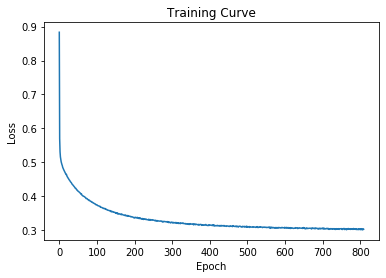

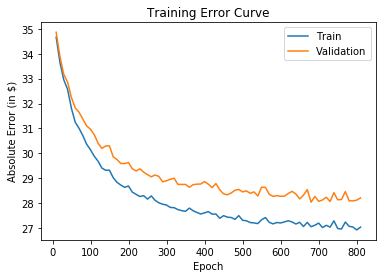

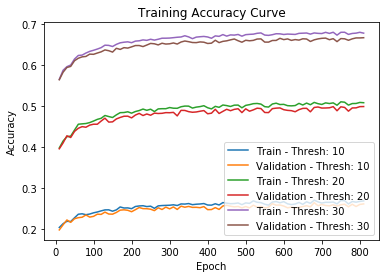

---[ITER 10] loss: 0.297535  time: 2.791
---[ITER 20] loss: 0.296631  time: 2.871
---[ITER 30] loss: 0.306125  time: 2.772
---[ITER 40] loss: 0.321246  time: 2.778
---[ITER 50] loss: 0.298640  time: 2.783
---[ITER 60] loss: 0.296183  time: 2.819
---[ITER 70] loss: 0.298017  time: 2.759
---[ITER 80] loss: 0.308014  time: 2.746
---[ITER 90] loss: 0.298379  time: 2.766
---[ITER 100] loss: 0.304598  time: 2.808
---[ITER 110] loss: 0.310469  time: 2.811
---[ITER 120] loss: 0.288061  time: 2.767
---[ITER 130] loss: 0.310010  time: 2.733
---[ITER 140] loss: 0.306411  time: 2.793
---[ITER 150] loss: 0.301348  time: 2.906
---[ITER 160] loss: 0.310265  time: 2.821
[EPOCH 811] loss: 0.303085  time: 46.853
---[ITER 10] loss: 0.308366  time: 2.830
---[ITER 20] loss: 0.297912  time: 2.986
---[ITER 30] loss: 0.309562  time: 2.747
---[ITER 40] loss: 0.311387  time: 2.747
---[ITER 50] loss: 0.303929  time: 2.768
---[ITER 60] loss: 0.299767  time: 2.769
---[ITER 70] loss: 0.300510  time: 2.737
---[ITER 

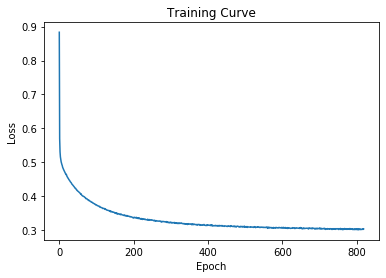

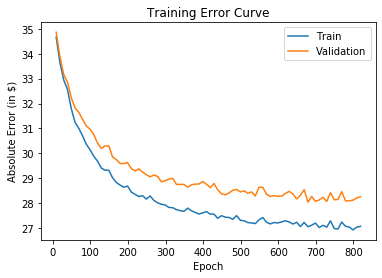

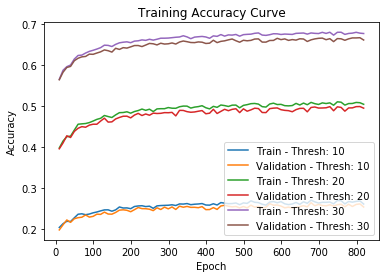

---[ITER 10] loss: 0.312180  time: 2.763
---[ITER 20] loss: 0.311901  time: 2.751
---[ITER 30] loss: 0.316714  time: 2.899
---[ITER 40] loss: 0.291916  time: 2.785
---[ITER 50] loss: 0.297094  time: 2.782
---[ITER 60] loss: 0.308266  time: 2.941
---[ITER 70] loss: 0.298756  time: 2.783
---[ITER 80] loss: 0.303282  time: 2.763
---[ITER 90] loss: 0.303901  time: 2.750
---[ITER 100] loss: 0.298758  time: 2.763
---[ITER 110] loss: 0.305956  time: 2.757
---[ITER 120] loss: 0.297645  time: 2.711
---[ITER 130] loss: 0.307039  time: 2.760
---[ITER 140] loss: 0.297027  time: 2.787
---[ITER 150] loss: 0.296133  time: 2.797
---[ITER 160] loss: 0.309545  time: 2.762
[EPOCH 821] loss: 0.303882  time: 46.678
---[ITER 10] loss: 0.296676  time: 2.759
---[ITER 20] loss: 0.316385  time: 2.768
---[ITER 30] loss: 0.300429  time: 2.776
---[ITER 40] loss: 0.298404  time: 2.776
---[ITER 50] loss: 0.297984  time: 2.750
---[ITER 60] loss: 0.291918  time: 2.761
---[ITER 70] loss: 0.307432  time: 2.770
---[ITER 

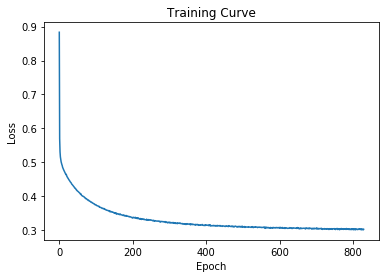

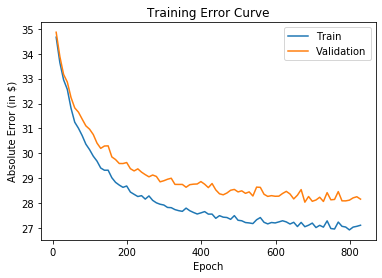

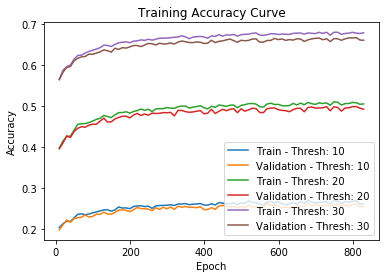

---[ITER 10] loss: 0.299575  time: 2.736
---[ITER 20] loss: 0.307684  time: 2.787
---[ITER 30] loss: 0.285034  time: 2.808
---[ITER 40] loss: 0.304919  time: 2.750
---[ITER 50] loss: 0.314487  time: 2.815
---[ITER 60] loss: 0.309970  time: 2.774
---[ITER 70] loss: 0.288893  time: 2.781
---[ITER 80] loss: 0.302167  time: 2.789
---[ITER 90] loss: 0.299896  time: 2.772
---[ITER 100] loss: 0.318632  time: 2.782
---[ITER 110] loss: 0.312681  time: 2.800
---[ITER 120] loss: 0.300180  time: 2.779
---[ITER 130] loss: 0.311406  time: 2.883
---[ITER 140] loss: 0.306285  time: 3.162
---[ITER 150] loss: 0.295167  time: 2.855
---[ITER 160] loss: 0.296433  time: 2.821
[EPOCH 831] loss: 0.303770  time: 47.467
---[ITER 10] loss: 0.309575  time: 2.794
---[ITER 20] loss: 0.310156  time: 2.813
---[ITER 30] loss: 0.300520  time: 2.763
---[ITER 40] loss: 0.305194  time: 2.725
---[ITER 50] loss: 0.303996  time: 2.832
---[ITER 60] loss: 0.296704  time: 2.786
---[ITER 70] loss: 0.298601  time: 2.780
---[ITER 

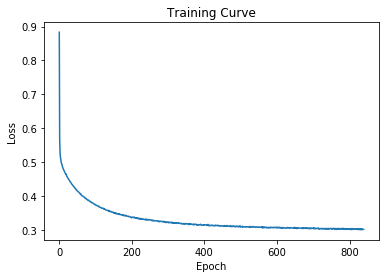

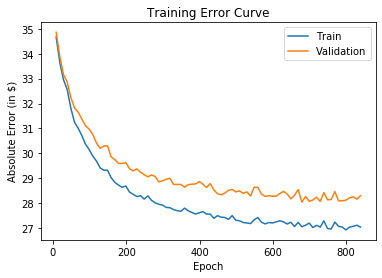

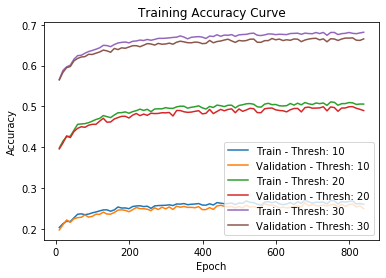

---[ITER 10] loss: 0.291697  time: 2.866
---[ITER 20] loss: 0.296823  time: 2.842
---[ITER 30] loss: 0.298841  time: 2.882
---[ITER 40] loss: 0.296657  time: 2.821
---[ITER 50] loss: 0.296981  time: 2.985
---[ITER 60] loss: 0.298472  time: 2.790
---[ITER 70] loss: 0.306398  time: 2.797
---[ITER 80] loss: 0.306242  time: 2.742
---[ITER 90] loss: 0.300752  time: 2.764
---[ITER 100] loss: 0.320131  time: 2.796
---[ITER 110] loss: 0.292806  time: 2.776
---[ITER 120] loss: 0.297862  time: 2.767
---[ITER 130] loss: 0.309660  time: 2.762
---[ITER 140] loss: 0.297971  time: 2.775
---[ITER 150] loss: 0.290980  time: 2.818
---[ITER 160] loss: 0.314899  time: 2.795
[EPOCH 841] loss: 0.301244  time: 47.127
---[ITER 10] loss: 0.305595  time: 2.799
---[ITER 20] loss: 0.300159  time: 2.742
---[ITER 30] loss: 0.305359  time: 2.807
---[ITER 40] loss: 0.307764  time: 2.837
---[ITER 50] loss: 0.307738  time: 2.820
---[ITER 60] loss: 0.299980  time: 2.851
---[ITER 70] loss: 0.300449  time: 2.824
---[ITER 

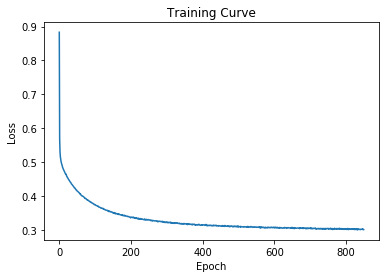

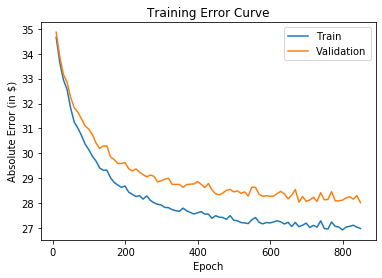

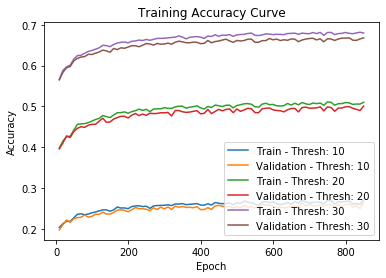

---[ITER 10] loss: 0.297608  time: 2.766
---[ITER 20] loss: 0.295213  time: 2.762
---[ITER 30] loss: 0.295789  time: 2.791
---[ITER 40] loss: 0.308786  time: 2.806
---[ITER 50] loss: 0.299148  time: 2.812
---[ITER 60] loss: 0.301510  time: 2.817
---[ITER 70] loss: 0.305476  time: 2.783
---[ITER 80] loss: 0.297525  time: 2.772
---[ITER 90] loss: 0.288044  time: 2.810
---[ITER 100] loss: 0.309449  time: 2.782
---[ITER 110] loss: 0.299160  time: 2.844
---[ITER 120] loss: 0.311172  time: 2.839
---[ITER 130] loss: 0.300047  time: 2.829
---[ITER 140] loss: 0.305633  time: 2.824
---[ITER 150] loss: 0.304489  time: 3.015
---[ITER 160] loss: 0.317155  time: 2.816
[EPOCH 851] loss: 0.302313  time: 47.211
---[ITER 10] loss: 0.299508  time: 2.801
---[ITER 20] loss: 0.294819  time: 2.796
---[ITER 30] loss: 0.305489  time: 2.704
---[ITER 40] loss: 0.301680  time: 2.790
---[ITER 50] loss: 0.296681  time: 2.780
---[ITER 60] loss: 0.306414  time: 2.787
---[ITER 70] loss: 0.302153  time: 2.765
---[ITER 

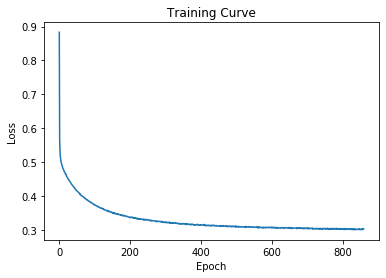

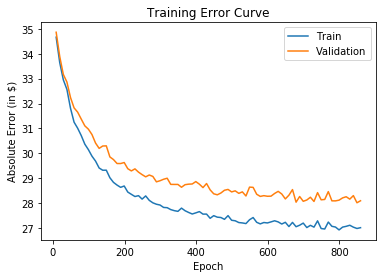

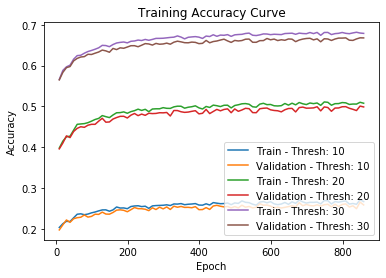

---[ITER 10] loss: 0.303351  time: 2.814
---[ITER 20] loss: 0.290110  time: 2.793
---[ITER 30] loss: 0.301572  time: 3.005
---[ITER 40] loss: 0.290236  time: 2.720
---[ITER 50] loss: 0.308508  time: 2.736
---[ITER 60] loss: 0.309975  time: 2.782
---[ITER 70] loss: 0.294607  time: 2.778
---[ITER 80] loss: 0.301860  time: 2.742
---[ITER 90] loss: 0.295785  time: 2.775
---[ITER 100] loss: 0.298159  time: 2.773
---[ITER 110] loss: 0.304600  time: 2.746
---[ITER 120] loss: 0.302548  time: 2.736
---[ITER 130] loss: 0.307967  time: 2.755
---[ITER 140] loss: 0.296736  time: 2.791
---[ITER 150] loss: 0.306903  time: 3.029
---[ITER 160] loss: 0.309927  time: 2.822
[EPOCH 861] loss: 0.301172  time: 46.907
---[ITER 10] loss: 0.305522  time: 2.891
---[ITER 20] loss: 0.293708  time: 2.741
---[ITER 30] loss: 0.287478  time: 2.770
---[ITER 40] loss: 0.315384  time: 2.792
---[ITER 50] loss: 0.298593  time: 2.836
---[ITER 60] loss: 0.297029  time: 2.787
---[ITER 70] loss: 0.299536  time: 2.708
---[ITER 

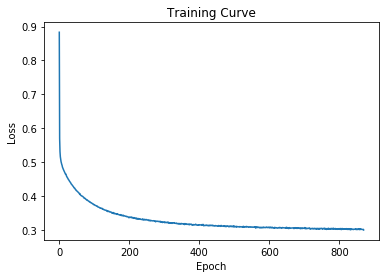

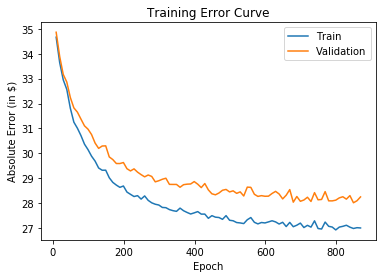

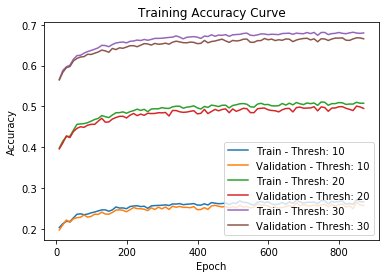

---[ITER 10] loss: 0.308657  time: 2.983
---[ITER 20] loss: 0.301852  time: 2.828
---[ITER 30] loss: 0.300732  time: 2.773
---[ITER 40] loss: 0.294373  time: 3.430
---[ITER 50] loss: 0.293841  time: 3.706
---[ITER 60] loss: 0.299745  time: 3.643
---[ITER 70] loss: 0.305644  time: 3.141
---[ITER 80] loss: 0.294989  time: 3.100
---[ITER 90] loss: 0.308976  time: 3.239
---[ITER 100] loss: 0.295168  time: 2.807
---[ITER 110] loss: 0.300699  time: 2.755
---[ITER 120] loss: 0.300659  time: 2.950
---[ITER 130] loss: 0.314943  time: 2.814
---[ITER 140] loss: 0.306402  time: 2.801
---[ITER 150] loss: 0.308108  time: 2.780
---[ITER 160] loss: 0.306076  time: 2.772
[EPOCH 871] loss: 0.302204  time: 50.658
---[ITER 10] loss: 0.307794  time: 2.745
---[ITER 20] loss: 0.293357  time: 2.820
---[ITER 30] loss: 0.313062  time: 2.816
---[ITER 40] loss: 0.296603  time: 2.743
---[ITER 50] loss: 0.300629  time: 2.787
---[ITER 60] loss: 0.306932  time: 2.788
---[ITER 70] loss: 0.296879  time: 2.797
---[ITER 

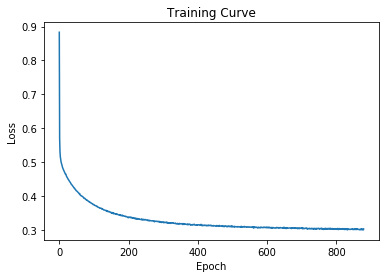

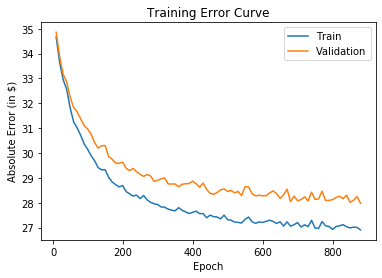

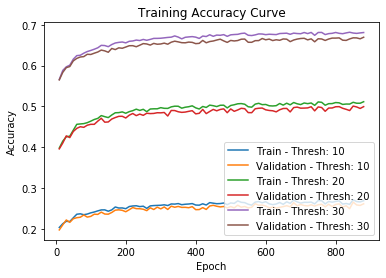

---[ITER 10] loss: 0.298629  time: 2.986
---[ITER 20] loss: 0.298576  time: 2.804
---[ITER 30] loss: 0.299199  time: 2.760
---[ITER 40] loss: 0.286927  time: 2.803
---[ITER 50] loss: 0.303339  time: 2.763
---[ITER 60] loss: 0.291144  time: 2.790
---[ITER 70] loss: 0.300891  time: 2.796
---[ITER 80] loss: 0.298274  time: 2.783
---[ITER 90] loss: 0.316793  time: 2.772
---[ITER 100] loss: 0.303056  time: 2.796
---[ITER 110] loss: 0.290848  time: 2.779
---[ITER 120] loss: 0.307193  time: 2.762
---[ITER 130] loss: 0.305132  time: 2.734
---[ITER 140] loss: 0.307528  time: 2.820
---[ITER 150] loss: 0.310063  time: 2.803
---[ITER 160] loss: 0.309384  time: 2.784
[EPOCH 881] loss: 0.301828  time: 46.861
---[ITER 10] loss: 0.305405  time: 2.764
---[ITER 20] loss: 0.311892  time: 2.847
---[ITER 30] loss: 0.308097  time: 2.856
---[ITER 40] loss: 0.295659  time: 2.795
---[ITER 50] loss: 0.296726  time: 2.764
---[ITER 60] loss: 0.298608  time: 2.948
---[ITER 70] loss: 0.315677  time: 2.728
---[ITER 

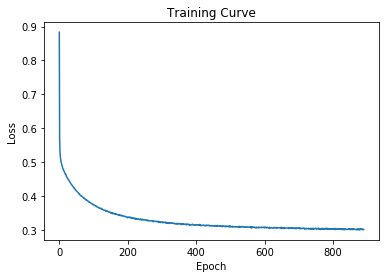

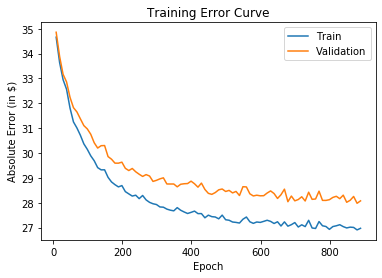

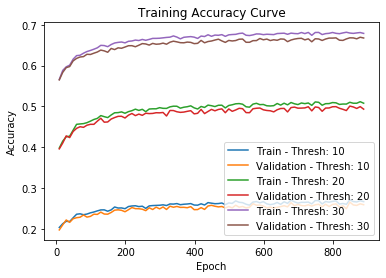

---[ITER 10] loss: 0.311060  time: 2.810
---[ITER 20] loss: 0.296290  time: 2.787
---[ITER 30] loss: 0.305046  time: 2.806
---[ITER 40] loss: 0.304519  time: 2.764
---[ITER 50] loss: 0.294265  time: 2.781
---[ITER 60] loss: 0.290434  time: 2.753
---[ITER 70] loss: 0.312013  time: 2.843
---[ITER 80] loss: 0.298892  time: 2.819
---[ITER 90] loss: 0.304814  time: 2.780
---[ITER 100] loss: 0.282347  time: 2.874
---[ITER 110] loss: 0.300067  time: 2.914
---[ITER 120] loss: 0.308259  time: 2.741
---[ITER 130] loss: 0.298907  time: 2.831
---[ITER 140] loss: 0.299027  time: 2.852
---[ITER 150] loss: 0.308106  time: 3.064
---[ITER 160] loss: 0.287389  time: 2.784
[EPOCH 891] loss: 0.300242  time: 47.323
---[ITER 10] loss: 0.304044  time: 2.878
---[ITER 20] loss: 0.301191  time: 2.793
---[ITER 30] loss: 0.302711  time: 2.770
---[ITER 40] loss: 0.288305  time: 2.771
---[ITER 50] loss: 0.300958  time: 2.804
---[ITER 60] loss: 0.308062  time: 2.822
---[ITER 70] loss: 0.295835  time: 2.795
---[ITER 

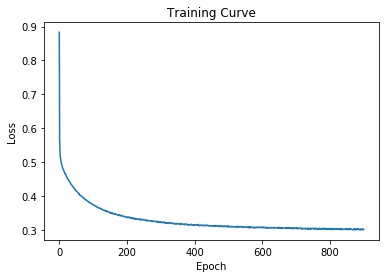

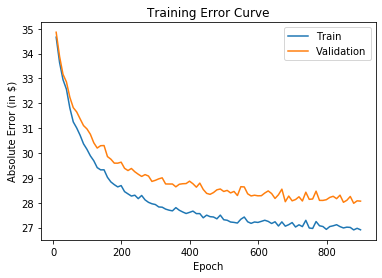

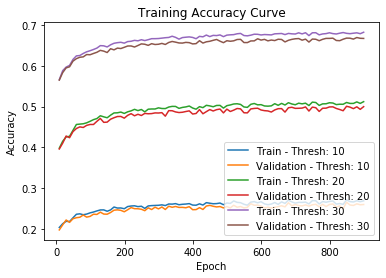

---[ITER 10] loss: 0.298939  time: 2.926
---[ITER 20] loss: 0.300876  time: 2.763
---[ITER 30] loss: 0.308560  time: 2.899
---[ITER 40] loss: 0.311891  time: 2.791
---[ITER 50] loss: 0.298987  time: 2.755
---[ITER 60] loss: 0.309732  time: 2.800
---[ITER 70] loss: 0.298383  time: 2.789
---[ITER 80] loss: 0.299310  time: 2.799
---[ITER 90] loss: 0.287980  time: 2.765
---[ITER 100] loss: 0.306386  time: 2.799
---[ITER 110] loss: 0.305753  time: 2.785
---[ITER 120] loss: 0.295627  time: 2.745
---[ITER 130] loss: 0.299607  time: 2.752
---[ITER 140] loss: 0.304576  time: 2.816
---[ITER 150] loss: 0.309372  time: 2.793
---[ITER 160] loss: 0.298044  time: 2.803
[EPOCH 901] loss: 0.301948  time: 46.994
---[ITER 10] loss: 0.299157  time: 2.792
---[ITER 20] loss: 0.311984  time: 2.776
---[ITER 30] loss: 0.305543  time: 2.940
---[ITER 40] loss: 0.314100  time: 2.865
---[ITER 50] loss: 0.290508  time: 2.767
---[ITER 60] loss: 0.301604  time: 2.788
---[ITER 70] loss: 0.298621  time: 2.744
---[ITER 

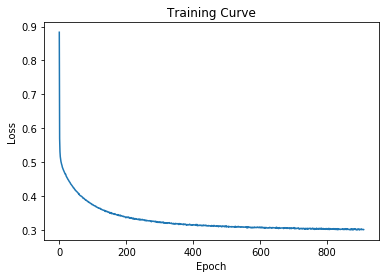

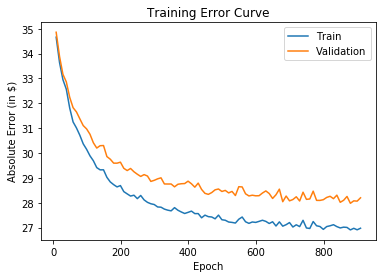

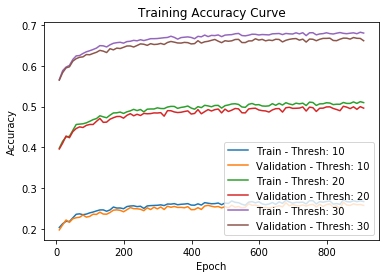

---[ITER 10] loss: 0.299936  time: 2.798
---[ITER 20] loss: 0.302602  time: 2.902
---[ITER 30] loss: 0.291888  time: 2.920
---[ITER 40] loss: 0.296306  time: 2.752
---[ITER 50] loss: 0.317948  time: 2.665
---[ITER 60] loss: 0.314561  time: 2.675
---[ITER 70] loss: 0.314069  time: 2.579
---[ITER 80] loss: 0.287752  time: 2.541
---[ITER 90] loss: 0.286604  time: 2.553
---[ITER 100] loss: 0.307378  time: 2.593
---[ITER 110] loss: 0.299208  time: 2.589
---[ITER 120] loss: 0.283040  time: 2.593
---[ITER 130] loss: 0.296855  time: 2.567
---[ITER 140] loss: 0.308616  time: 2.617
---[ITER 150] loss: 0.294347  time: 2.595
---[ITER 160] loss: 0.301236  time: 2.586
[EPOCH 911] loss: 0.301107  time: 44.516
---[ITER 10] loss: 0.301700  time: 2.558
---[ITER 20] loss: 0.300170  time: 2.616
---[ITER 30] loss: 0.300773  time: 2.590
---[ITER 40] loss: 0.298796  time: 2.556
---[ITER 50] loss: 0.285968  time: 2.545
---[ITER 60] loss: 0.299832  time: 2.570
---[ITER 70] loss: 0.295219  time: 2.605
---[ITER 

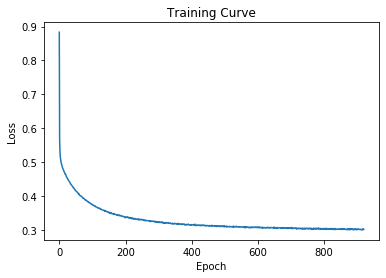

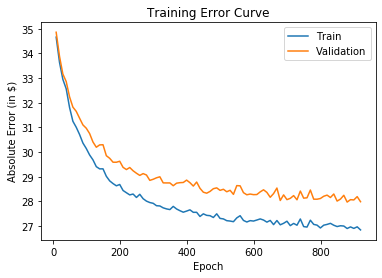

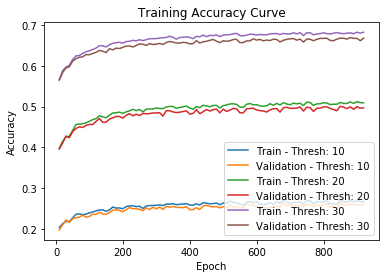

---[ITER 10] loss: 0.301916  time: 2.789
---[ITER 20] loss: 0.299169  time: 2.595
---[ITER 30] loss: 0.289476  time: 2.707
---[ITER 40] loss: 0.296274  time: 2.596
---[ITER 50] loss: 0.299758  time: 2.685
---[ITER 60] loss: 0.299624  time: 2.833
---[ITER 70] loss: 0.298885  time: 2.604
---[ITER 80] loss: 0.302822  time: 2.609
---[ITER 90] loss: 0.312546  time: 2.614
---[ITER 100] loss: 0.301367  time: 2.610
---[ITER 110] loss: 0.303629  time: 2.597
---[ITER 120] loss: 0.295913  time: 2.655
---[ITER 130] loss: 0.299661  time: 2.602
---[ITER 140] loss: 0.308749  time: 2.627
---[ITER 150] loss: 0.315560  time: 2.584
---[ITER 160] loss: 0.293330  time: 2.659
[EPOCH 921] loss: 0.301171  time: 44.387
---[ITER 10] loss: 0.306811  time: 2.610
---[ITER 20] loss: 0.300441  time: 2.621
---[ITER 30] loss: 0.300532  time: 2.644
---[ITER 40] loss: 0.296024  time: 2.748
---[ITER 50] loss: 0.300141  time: 2.918
---[ITER 60] loss: 0.309879  time: 2.661
---[ITER 70] loss: 0.297683  time: 2.731
---[ITER 

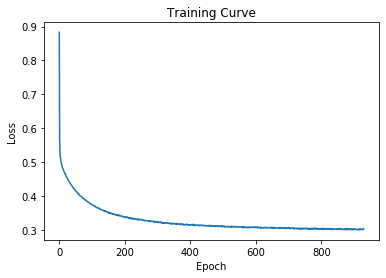

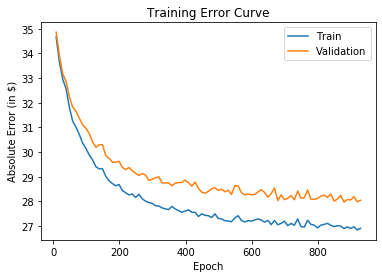

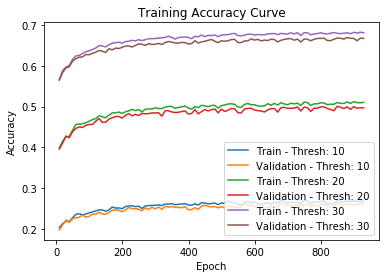

---[ITER 10] loss: 0.297714  time: 2.531
---[ITER 20] loss: 0.302578  time: 2.699
---[ITER 30] loss: 0.309949  time: 2.593
---[ITER 40] loss: 0.305599  time: 2.574
---[ITER 50] loss: 0.295876  time: 2.536
---[ITER 60] loss: 0.296950  time: 2.535
---[ITER 70] loss: 0.304048  time: 2.556
---[ITER 80] loss: 0.302394  time: 2.564
---[ITER 90] loss: 0.298232  time: 2.537
---[ITER 100] loss: 0.316060  time: 2.523
---[ITER 110] loss: 0.302041  time: 2.570
---[ITER 120] loss: 0.290241  time: 2.598
---[ITER 130] loss: 0.297562  time: 2.586
---[ITER 140] loss: 0.296261  time: 2.583
---[ITER 150] loss: 0.293394  time: 2.561
---[ITER 160] loss: 0.300956  time: 2.543
[EPOCH 931] loss: 0.300589  time: 43.096
---[ITER 10] loss: 0.305404  time: 2.629
---[ITER 20] loss: 0.299111  time: 2.580
---[ITER 30] loss: 0.304271  time: 2.695
---[ITER 40] loss: 0.309831  time: 2.667
---[ITER 50] loss: 0.290042  time: 2.612
---[ITER 60] loss: 0.316933  time: 2.663
---[ITER 70] loss: 0.303713  time: 2.571
---[ITER 

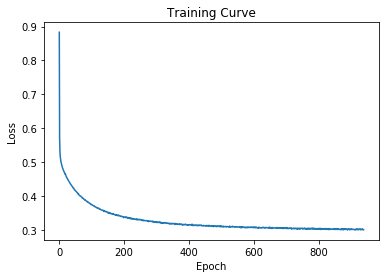

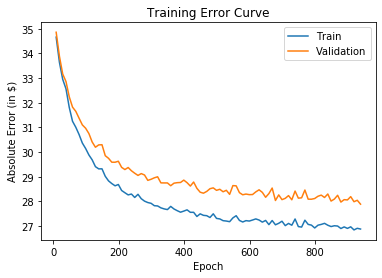

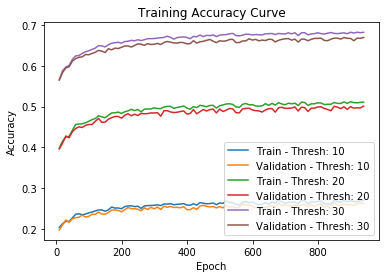

---[ITER 10] loss: 0.306745  time: 2.632
---[ITER 20] loss: 0.288559  time: 2.595
---[ITER 30] loss: 0.303379  time: 2.612
---[ITER 40] loss: 0.297151  time: 2.567
---[ITER 50] loss: 0.307416  time: 2.715
---[ITER 60] loss: 0.293884  time: 2.597
---[ITER 70] loss: 0.317671  time: 2.527
---[ITER 80] loss: 0.306031  time: 2.557
---[ITER 90] loss: 0.309341  time: 2.542
---[ITER 100] loss: 0.306596  time: 2.566
---[ITER 110] loss: 0.293292  time: 2.613
---[ITER 120] loss: 0.305612  time: 2.515
---[ITER 130] loss: 0.292707  time: 2.548
---[ITER 140] loss: 0.305292  time: 2.570
---[ITER 150] loss: 0.308879  time: 2.557
---[ITER 160] loss: 0.304293  time: 2.591
[EPOCH 941] loss: 0.301726  time: 43.275
---[ITER 10] loss: 0.303108  time: 2.557
---[ITER 20] loss: 0.307941  time: 2.589
---[ITER 30] loss: 0.303647  time: 2.534
---[ITER 40] loss: 0.297641  time: 2.756
---[ITER 50] loss: 0.293646  time: 2.657
---[ITER 60] loss: 0.305755  time: 2.574
---[ITER 70] loss: 0.304203  time: 2.646
---[ITER 

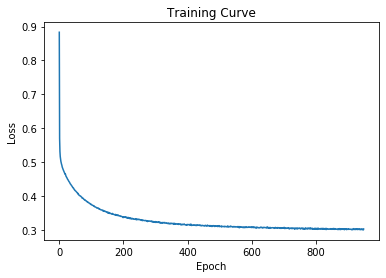

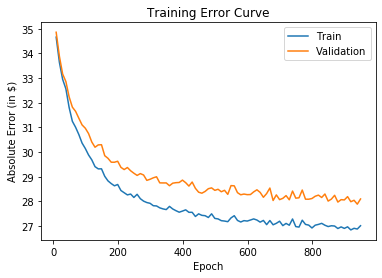

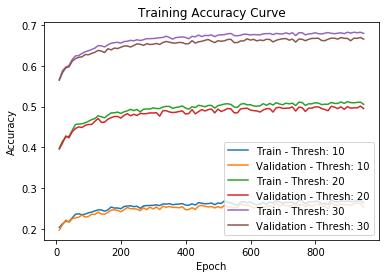

---[ITER 10] loss: 0.301045  time: 2.596
---[ITER 20] loss: 0.301213  time: 2.577
---[ITER 30] loss: 0.296770  time: 2.708
---[ITER 40] loss: 0.309082  time: 2.611
---[ITER 50] loss: 0.292152  time: 2.573
---[ITER 60] loss: 0.303501  time: 2.554
---[ITER 70] loss: 0.302569  time: 2.727
---[ITER 80] loss: 0.306341  time: 2.606
---[ITER 90] loss: 0.307034  time: 2.574
---[ITER 100] loss: 0.300063  time: 2.544
---[ITER 110] loss: 0.305298  time: 2.571
---[ITER 120] loss: 0.306962  time: 2.549
---[ITER 130] loss: 0.297855  time: 2.622
---[ITER 140] loss: 0.294696  time: 2.604
---[ITER 150] loss: 0.293380  time: 2.550
---[ITER 160] loss: 0.303692  time: 2.577
[EPOCH 951] loss: 0.301388  time: 43.523
---[ITER 10] loss: 0.303260  time: 2.610
---[ITER 20] loss: 0.307726  time: 2.605
---[ITER 30] loss: 0.293161  time: 2.797
---[ITER 40] loss: 0.303278  time: 2.586
---[ITER 50] loss: 0.304074  time: 2.641
---[ITER 60] loss: 0.289736  time: 2.524
---[ITER 70] loss: 0.303463  time: 2.649
---[ITER 

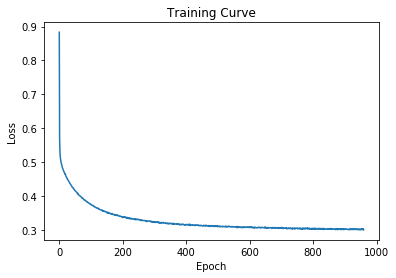

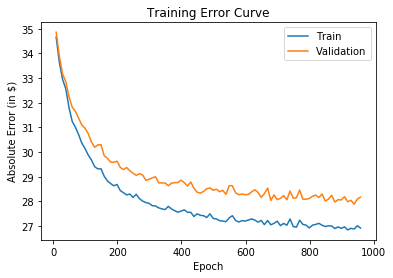

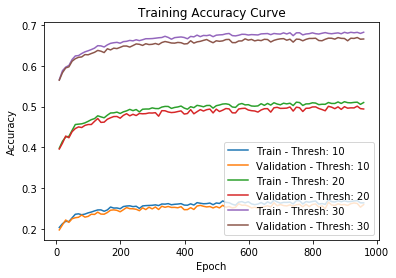

---[ITER 10] loss: 0.302746  time: 2.668
---[ITER 20] loss: 0.282902  time: 2.685
---[ITER 30] loss: 0.302181  time: 2.595
---[ITER 40] loss: 0.300862  time: 2.587
---[ITER 50] loss: 0.301011  time: 2.711
---[ITER 60] loss: 0.303241  time: 2.605
---[ITER 70] loss: 0.290269  time: 2.538
---[ITER 80] loss: 0.301337  time: 2.580
---[ITER 90] loss: 0.300937  time: 2.562
---[ITER 100] loss: 0.307136  time: 2.575
---[ITER 110] loss: 0.301359  time: 2.584
---[ITER 120] loss: 0.290874  time: 2.565
---[ITER 130] loss: 0.300804  time: 2.568
---[ITER 140] loss: 0.314240  time: 2.578
---[ITER 150] loss: 0.314689  time: 2.781
---[ITER 160] loss: 0.293453  time: 2.636
[EPOCH 961] loss: 0.301192  time: 43.830
---[ITER 10] loss: 0.299498  time: 2.563
---[ITER 20] loss: 0.293332  time: 2.630
---[ITER 30] loss: 0.306679  time: 2.595
---[ITER 40] loss: 0.309270  time: 2.563
---[ITER 50] loss: 0.292495  time: 2.537
---[ITER 60] loss: 0.306600  time: 2.578
---[ITER 70] loss: 0.289611  time: 2.589
---[ITER 

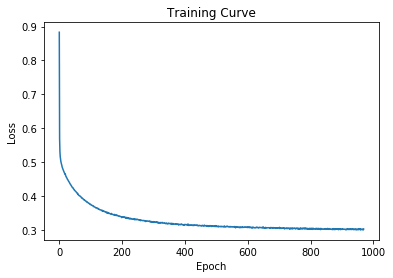

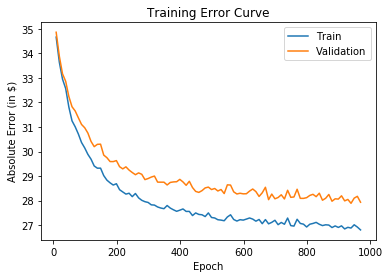

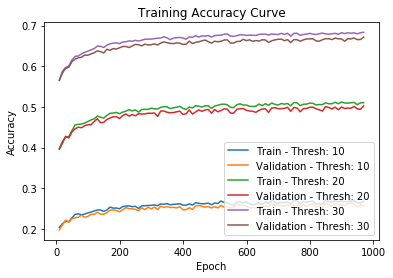

---[ITER 10] loss: 0.301611  time: 2.543
---[ITER 20] loss: 0.304421  time: 2.618
---[ITER 30] loss: 0.306259  time: 2.634
---[ITER 40] loss: 0.291128  time: 2.625
---[ITER 50] loss: 0.298215  time: 2.587
---[ITER 60] loss: 0.300364  time: 2.574
---[ITER 70] loss: 0.290126  time: 2.710
---[ITER 80] loss: 0.309984  time: 2.595
---[ITER 90] loss: 0.291949  time: 2.555
---[ITER 100] loss: 0.292809  time: 2.565
---[ITER 110] loss: 0.297516  time: 2.571
---[ITER 120] loss: 0.321091  time: 2.582
---[ITER 130] loss: 0.303328  time: 2.554
---[ITER 140] loss: 0.304294  time: 2.664
---[ITER 150] loss: 0.299728  time: 2.739
---[ITER 160] loss: 0.305779  time: 2.640
[EPOCH 971] loss: 0.301403  time: 43.795
---[ITER 10] loss: 0.293253  time: 2.585
---[ITER 20] loss: 0.292654  time: 2.643
---[ITER 30] loss: 0.299047  time: 2.574
---[ITER 40] loss: 0.296602  time: 2.553
---[ITER 50] loss: 0.306473  time: 2.535
---[ITER 60] loss: 0.295886  time: 2.590
---[ITER 70] loss: 0.294389  time: 2.574
---[ITER 

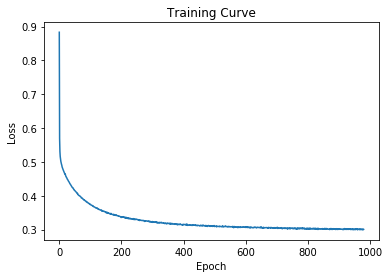

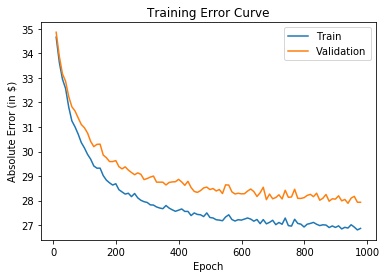

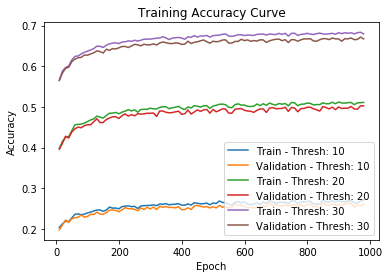

---[ITER 10] loss: 0.311184  time: 2.623
---[ITER 20] loss: 0.300104  time: 2.559
---[ITER 30] loss: 0.302317  time: 2.604
---[ITER 40] loss: 0.305323  time: 2.558
---[ITER 50] loss: 0.284071  time: 2.552
---[ITER 60] loss: 0.299309  time: 2.674
---[ITER 70] loss: 0.297937  time: 2.591
---[ITER 80] loss: 0.325264  time: 2.585
---[ITER 90] loss: 0.295782  time: 2.593
---[ITER 100] loss: 0.295026  time: 2.674
---[ITER 110] loss: 0.298899  time: 2.603
---[ITER 120] loss: 0.296940  time: 2.549
---[ITER 130] loss: 0.297856  time: 2.571
---[ITER 140] loss: 0.300972  time: 2.587
---[ITER 150] loss: 0.304619  time: 2.588
---[ITER 160] loss: 0.296710  time: 2.723
[EPOCH 981] loss: 0.301170  time: 43.694
---[ITER 10] loss: 0.295388  time: 2.586
---[ITER 20] loss: 0.305914  time: 2.662
---[ITER 30] loss: 0.296481  time: 2.616
---[ITER 40] loss: 0.292088  time: 2.531
---[ITER 50] loss: 0.305104  time: 2.550
---[ITER 60] loss: 0.302898  time: 2.552
---[ITER 70] loss: 0.291129  time: 2.568
---[ITER 

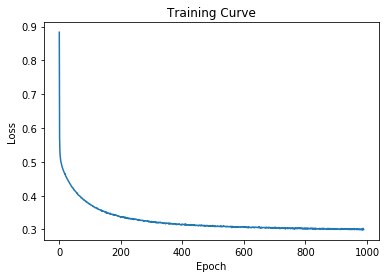

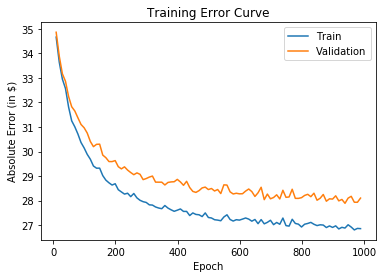

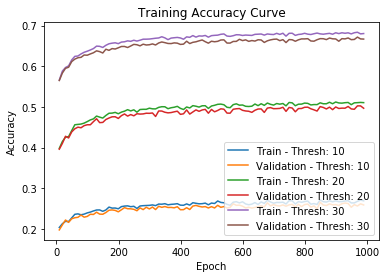

---[ITER 10] loss: 0.307252  time: 2.558
---[ITER 20] loss: 0.293209  time: 2.562
---[ITER 30] loss: 0.299326  time: 2.582
---[ITER 40] loss: 0.297271  time: 2.563
---[ITER 50] loss: 0.303329  time: 2.593
---[ITER 60] loss: 0.291373  time: 2.559
---[ITER 70] loss: 0.291750  time: 2.583
---[ITER 80] loss: 0.293810  time: 2.607
---[ITER 90] loss: 0.300297  time: 2.595
---[ITER 100] loss: 0.311108  time: 2.735
---[ITER 110] loss: 0.306733  time: 2.678
---[ITER 120] loss: 0.295733  time: 2.680
---[ITER 130] loss: 0.311582  time: 2.600
---[ITER 140] loss: 0.289972  time: 2.693
---[ITER 150] loss: 0.306759  time: 2.596
---[ITER 160] loss: 0.293805  time: 2.773
[EPOCH 991] loss: 0.299463  time: 44.024
---[ITER 10] loss: 0.304579  time: 2.623
---[ITER 20] loss: 0.297313  time: 2.679
---[ITER 30] loss: 0.299443  time: 2.588
---[ITER 40] loss: 0.297439  time: 2.516
---[ITER 50] loss: 0.306618  time: 2.579
---[ITER 60] loss: 0.292982  time: 2.594
---[ITER 70] loss: 0.302845  time: 2.568
---[ITER 

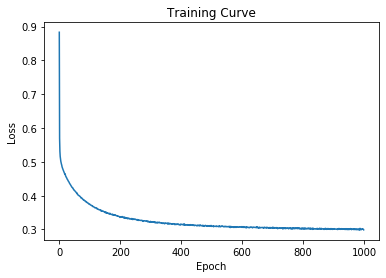

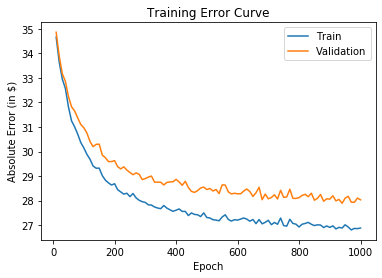

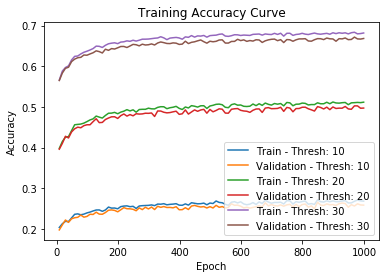

Training Completed...
[FINAL] loss: 0.299000  time: 49596.332


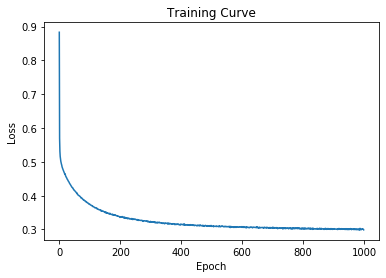

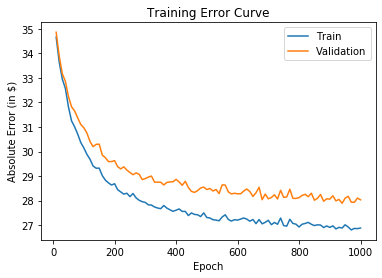

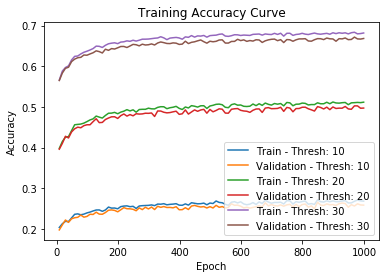

In [10]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1
And 
while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')But 
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.0001, num_epoch = 1000)